In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy
from scipy import interpolate
import scipy.stats as stats
from scipy import linalg
import warnings
import datetime
from numpy.lib import recfunctions

from netCDF4 import Dataset 
import pandas as pd
import xarray as xr

import gsw
from PyCO2SYS import CO2SYS
import oceans.sw_extras as oce

from IPython import display
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Functions

## 1. Calculations

In [2]:
## For calculating AOU: Potential temperature ITS-90, Oxygen concentration at saturation.
## From https://github.com/pyoceans/python-oceans/

def T68conv(T90):
    """
    Convert ITS-90 temperature to IPTS-68
    :math:`T68  = T90 * 1.00024`
    Parameters
    ----------
    t : array_like
           temperature [℃ (ITS-90)]
    Returns
    -------
    t : array_like
           temperature [℃ (IPTS-68)]
    Notes
    -----
    The International Practical Temperature Scale of 1968 (IPTS-68) need to be
    correct to the ITS-90. This linear transformation is accurate within
    0.5 ℃ for conversion between IPTS-68 and ITS-90 over the
    oceanographic temperature range.
    Examples
    --------
    >>> import seawater as sw
    >>> T68conv(19.995201151723585)
    20.0
    References
    ----------
    .. [1] Saunders, P. M., 1991: The International Temperature Scale of 1990,
       ITS-90. WOCE Newsletter, No. 10, WOCE International Project Office,
       Southampton, United Kingdom, 10.
    """
    T90 = np.asanyarray(T90)
    return T90 * 1.00024

## From https://github.com/pyoceans/python-oceans/

def o2sat(s, pt):
    """
    Calculate oxygen concentration at saturation.  Molar volume of oxygen
    at STP obtained from NIST website on the thermophysical properties of fluid
    systems (http://webbook.nist.gov/chemistry/fluid/).

    Parameters
    ----------
    s : array_like
        Salinity [pss-78]
    pt : array_like
         Potential Temperature [degC ITS-90]

    Returns
    -------
    osat : array_like
          Oxygen concentration at saturation [umol/kg]

    Examples
    --------
    >>> import os
    >>> from pandas import read_csv
    >>> import oceans.seawater.sw_extras as swe
    >>> path = os.path.split(os.path.realpath(swe.__file__))[0]
    # Table 9 pg. 732. Values in ml / kg
    >>> pt = np.array([-1, 0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22,
    ...                24, 26, 28, 30, 32, 34, 36, 38, 40]) / 1.00024
    >>> s = np.array([0, 10, 20, 30, 34, 35, 36, 38, 40])
    >>> s, pt = np.meshgrid(s, pt)
    >>> osat = swe.o2sat(s, pt) * 22.392 / 1000  # um/kg to ml/kg.
    >>> weiss_1979 = read_csv('%s/test/o2.csv' % path, index_col=0).values
    >>> np.testing.assert_almost_equal(osat.ravel()[2:],
    ...                                weiss_1979.ravel()[2:], decimal=3)


    References
    -----
    .. [1] The solubility of nitrogen, oxygen and argon in water and seawater -
    Weiss (1970) Deep Sea Research V17(4): 721-735.
    """

    t = T68conv(pt) + 273.15 #Kelvin
    # Eqn (4) of Weiss 1970 (the constants are used for units of ml O2/kg).
    a = (-177.7888, 255.5907, 146.4813, -22.2040)
    b = (-0.037362, 0.016504, -0.0020564)
    lnC = (a[0] + a[1] * (100. / t) + a[2] * np.log(t / 100.) + a[3] *
           (t / 100.) +
           s * (b[0] + b[1] * (t / 100.) + b[2] * (t / 100.) ** 2))
    osat = np.exp(lnC) * 1000. / 22.392  # Convert from ml/kg to um/kg.

    # The Apparent Oxygen Utilization (AOU) value was obtained by subtracting
    # the measured value from the saturation value computed at the potential
    # temperature of water and 1 atm total pressure using the following
    # expression based on the data of Murray and Riley (1969):

    # ln(O2 in µmol/kg) = - 173.9894 + 255.5907(100/TK) + 146.4813 ln(TK/100) -
    # 22.2040(TK/100) + Sal [-0.037362 + 0.016504(TK/100) - 0.0020564(TK/100)2],
    # where TK is temperature in °K and Sal in the Practical Salinity (SP) scale.

    return osat

## 2. Data formatting

In [3]:
# split dates for datetime formatting
def split_int_dt(m):
    '''
    Splits an integer date representation into its year, month, and day components.
    This function assumes that `m` is a numerical representation of a date
    in the format YYYYMMDD (e.g., 20240312 for March 12, 2024).
    
    Inputs:
    m : int or array-like
        An integer (or array of integers) representing a date in YYYYMMDD format.

    Returns:
    left : int or ndarray
        The year component (YYYY), with adjustments for negative values.
    mid : int or ndarray
        The month component (MM).
    right : int or ndarray
        The day component (DD).

    Example:
    >>> split_int_dt(20240312)
    (2024, 3, 12)
    '''
    
    # Convert input to an integer array (handles lists or single values)
    mint = np.array(m, dtype=int)
    
    # Identify negative values (for handling BC years or negative placeholders)    
    negative = mint < 0
    
    # Split
    left, right = np.divmod(mint, 100)
    left, mid = np.divmod(left, 100)
    
    ## Handle negative values
    if hasattr(m, 'ndim'):
        left[negative] = -1
    elif negative:
        left = -1
        
    return left, mid, right

In [4]:
def to_day(ymdhms):
    strings = []
    for entry in ymdhms:
        if len(entry) < 2:
            raise ValueError(f"Entry {entry} must have at least year and month.")

        # Fill missing parts: day=1, hour=0, min=0, sec=0
        filled = list(entry) + [1, 0, 0, 0][len(entry)-2:]
        y, m, d, hh, mm, ss = filled[:6]

        strings.append(f'{y:4d}-{m:02d}-{d:02d}T{hh:02d}:{mm:02d}:{ss:02d}')
    
    seconds = np.array(strings, dtype='datetime64[s]')
    return seconds.astype(float) / 86400

In [5]:
def concatenate_profiles(arr1d, var, grid):
    '''
    Concatenates and sorts profiles from multiple casts taken during the same cruise.
    This function is designed for data from the Hawaii Ocean Time-Series (HOT), where 
    each cruise typically has both a shallow (<200m) and a deep (>200m) cast for TA, DIC and pH samples.
    It groups bottle samples by cruise number ('crn'), retains valid samples for the given variable,
    sorts them by pressure, and filters based on predefined interpolation criteria.

    Inputs:
    arr1d : structured numpy array
        A structured array where each element represents a bottle sample. 
        The array must contain the fields: 
        - 'crn' (cruise number)
        - 'press' (pressure)
        - 'dt64' (datetime64 format for timestamps)
        - `var` (the variable to be processed, e.g., TA or DIC)

    var : str
        The name of the parameter (e.g., 'TA' or 'DIC') to be processed.

    grid : ndarray
        The pressure grid onto which the data will be interpolated.

    Returns:
    cruises : list of 1D structured arrays
        Each element in the list is a structured array containing concatenated and sorted 
        profiles for a given cruise, sorted by pressure.
    '''
    # Iterate through cruise numbers from the minimum to maximum value in the dataset, select valid samples
    cruises = []
    for i in range(arr1d['crn'].min(), arr1d['crn'].max(), 1):
        cr = arr1d[(arr1d['crn'] == i) & ~np.isnan(arr1d[var]) & (~np.isnat(arr1d['dt64']))]
        cr_sorted = np.sort(cr, order = 'press')
        cruises.append(cr_sorted)
    
    ## exclude cruises if all values for the variable are NaN 
    cruises = [t for t in cruises if ~np.isnan(sum(t[var]))] 
    
    ## matching interpolation criteria: more than four points, shallower than 250m.
    cruises = [t for t in cruises if len(t[t['press'] <= grid[-1]]) > 4 and t['press'][0] < 250] 
    
    return cruises  ## cruises is a list of elements where each element contains a 1-d array of concatenated profiles
                    ## sorted by pressure

In [6]:
## need to convert datetime index into decimal year to be able to assess trend. 
## from TOATS https://github.com/NOAA-PMEL/TOATS
def decimal_month(years, months, days):
    """Compute the decimal month (ex. March 15 would be 3.48 or 3 + 15/31). Account for number of days in February using year."""
    days_in_month = {1: 31, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}
    feb_days = {y: 29 if y%400 == 0 or (y%4 == 0 and not y%100==0) else 28 for y in np.unique(years)}
    output = []
    for y, m, d in zip(years, months, days):
        if m == 2:
            output.append(m + (d - 1) / feb_days[y])
        else:
            output.append(m + (d - 1) / days_in_month[m])
    return output

In [7]:
# from pycurrents
def mask_nonincreasing(_arr):
    """
    Given a 1-D sequence or masked array, return a 1-D float64 masked array
    in which the unmasked values are monotonically increasing.
    """
                    
    _arr = np.array(_arr, dtype=np.float64, copy=False, subok=True)
    N = len(_arr)
    bmask = np.empty((N,), dtype=np.uint8)
   
    if _arr.ndim != 1:
        raise ValueError("Only 1-D arrays are permitted.")

    if np.ma.isMaskedArray(_arr):
        mask = _arr.mask
        dat = _arr.data
    else:
        mask = False   
        dat = _arr

    if not isinstance(mask, np.ndarray):
        if mask:
            return _arr # all masked already; nothing more to do
        else:
            bmask[0] = 0
            last = dat[0]
            for i in range(1, N):
                if dat[i] > last:
                    last = dat[i]
                    bmask[i] = 0
                else:
                    bmask[i] = 1
    
    else:
        omask = mask.astype(np.uint8)
        i0 = 0
        while i0 < N and omask[i0]:
            bmask[i0] = 1
            i0 += 1
        if i0 < N:
            bmask[i0] = 0
            last = dat[i0]
            for i in range(i0+1, N):
                if omask[i] or dat[i] <= last:
                    bmask[i] = 1
                else:
                    bmask[i] = 0
                    last = dat[i]
            
    return np.ma.array(dat, mask=bmask, copy=False)

## 3. Interpolation

In [8]:
def interpolate_profiles(obj, gvar, vvar, grid, max_gap=500):
    '''
    This function interpolates profiles of specified variables in an input list to a specified grid.
    Profiles are sorted based on a grid variable, duplicates and reversals are removed, and interpolation
    on the specified grid is done using Piecewise Cubic Hermite Interpolation (PCHIP). 
    Specified gaps (default: 500) are masked.
    
    Inputs :
    obj is a list of profiles sorted (increasing) by the grid variable (a list of structured arrays)  
    gvar is the grid variable (e.g. pressure) as it is called in obj (string). 
    vvar is the variable to be interpolated, also as it is called in obj (string). 
    grid is the target grid to be interpolated to (1-D ndarray). 
    
    Returns: 
    An interpolated array of pressure vs. profile (2-D), a list of tuples with cast info for 
    the first sample of each profile, and ndarrays of just the first times for each cast, and of the cruise numbers
    for each profile.
    '''
    
    profiles = []
    cast_info = []
    times = []
    crns = []
    
    for prof in obj:
        g_orig = prof[gvar]
        v_orig = prof[vvar]
        
        # Select valid values.
        igood = ~np.isnan(v_orig)
        gg = g_orig[igood]
        vg = v_orig[igood]
        
        # remove duplicates or reversals
        gg = mask_nonincreasing(gg)
        igood = ~np.ma.getmaskarray(gg)
        gg = gg.compressed()
        vg = vg[igood]
        
        
        # check if there are enough points, and pressure ranges are satisfied
        if len(gg[gg <= grid[-1]]) > 4 and gg[0] < 250 and gg[-1] > 300 :
            v_grid = interpolate.pchip_interpolate(gg, vg, grid)
            
            # Mask values over large gaps
            gap_indices = np.where(np.diff(gg) > max_gap)[0]
            for idx in gap_indices:
                # Set values to NaN in the grid where large gaps are found
                v_grid[(grid > gg[idx]) & (grid < gg[idx + 1])] = np.nan
            
            
            v_grid[(grid < gg[0]) | (grid > gg[-1])] = np.nan
            profiles.append(v_grid)
            cast_info.append((prof['crn'][0], prof['dt64'][0]))
      
    ### convert profiles to ndarray
    profiles_array = np.asarray(profiles)
    
    for i in range(len(cast_info)):
        times.append(cast_info[i][1])
        crns.append(cast_info[i][0])
    times_array = np.asarray(times)
    crn_array = np.asarray(crns)
            
    return(profiles_array, cast_info, times_array, crn_array)

In [9]:
## further interpolation function with slightly adjusted criteria

def interpolate_profiles_shallow(obj, gvar, vvar, grid, max_gap=500):
    '''
    This function is the same as "interpolate_profiles", except the >300m criteria 
    for the deepest sample is removed, since some parameters are only measured in the upper
    250 m (Chlorophyll, PC)
    '''
    
    profiles = []
    cast_info = []
    times = []
    crns = []
    
    for prof in obj:
        g_orig = prof[gvar]
        v_orig = prof[vvar]
        
        # Select valid values.
        igood = ~np.isnan(v_orig)
        gg = g_orig[igood]
        vg = v_orig[igood]
        
        # remove duplicates or reversals
        gg = mask_nonincreasing(gg)
        igood = ~np.ma.getmaskarray(gg)
        gg = gg.compressed()
        vg = vg[igood]
        
        
        # check if there are enough points, and one is shallow enough
        if len(gg[gg <= grid[-1]]) > 2 and gg[0] < 250:
            v_grid = interpolate.pchip_interpolate(gg, vg, grid)
            
            # Mask interpolated values over large gaps
            gap_indices = np.where(np.diff(gg) > max_gap)[0]
            for idx in gap_indices:
                # Set values to NaN in the grid where large gaps are found
                v_grid[(grid > gg[idx]) & (grid < gg[idx + 1])] = np.nan
            
            
            v_grid[(grid < gg[0]) | (grid > gg[-1])] = np.nan
            profiles.append(v_grid)
            cast_info.append((prof['crn'][0], prof['dt64'][0]))
      
    ### convert profiles to ndarray
    profiles_array = np.asarray(profiles)
    
    for i in range(len(cast_info)):
        times.append(cast_info[i][1])
        crns.append(cast_info[i][0])
    times_array = np.asarray(times)
    crn_array = np.asarray(crns)
            
    return(profiles_array, cast_info, times_array, crn_array)

In [10]:
## further interpolation function with slightly adjusted criteria

def interpolate_single_variable(array, varname, max_gap=500):
    '''
    This function interpolates profiles of a single variable from an array to a pressure grid 
    using "interpolate_profiles".
    
    Output is an interpolated array of pressure vs. profile (2d), a list of tuples with cast info for 
    the first sample of each profile, and an ndarray of just the first times for each cast.
    '''
        
    keyvars = ['press','theta','sigma','temp','csal', varname]
    
    # Select profiles within the array that have the variable
    single = array[array[varname]>0]
    
    # Create a 2d arrray with bottle vs profile, profile as np.void object
    bottle_num = np.arange(1, 25)
    profile_codes = 1000 * single['crn'].astype(np.int64) + single['cast']
    code_sequence = sorted(np.unique(profile_codes))
    
    shape = (len(code_sequence), len(bottle_num))
    arr2d = np.empty(shape, dtype=single.dtype)  
    for name in keyvars:
        arr2d[name] = np.nan
    arr2d['dt64'] = 'NAT'
    
    # Filling the 2-D array with profiles based on profile codes
    for i, bottle in enumerate(single):
        icode = np.nonzero(code_sequence == profile_codes[i])[0][0]
        jbottle = bottle['ros'] - 1
        arr2d[icode, jbottle] = bottle
    
    # Change format to match the concatenated profiles 
    # (list of length keyvars where each item is a list of 1-D structured arrays, 
    # each 1-D array is a profile sorted by pressure)

    single_list = []
    for var in keyvars:
        profiles = []
        for i,prof in enumerate(arr2d):
            prof_sorted = np.sort(prof[~np.isnat(prof['dt64'])], order = 'press')
            prof_sorted = prof_sorted
            profiles.append(prof_sorted)
    
        ## exclude NaN only if there are any 
        profiles = [t for t in profiles if ~np.isnan(sum(t[var]))] 
        ## matching interpolation criteria: more than 4 points, shallower than 250m and deeper than 300m.
        profiles = [t for t in profiles if len(t[t['press'] <= grid[-1]]) > 4 and t['press'][0] < 250 and t['press'][-1] > 300] 
        single_list.append(profiles)
    
    # interpolate all variables
    interp_profiles = []
    prof_info = []
    prof_times = []
    prof_crns = []
    
    for var, name in zip(single_list, keyvars):
        var_interp, var_info, var_times, var_crns = interpolate_profiles(var, 'press', name, grid, max_gap)
        interp_profiles.append(var_interp)
        prof_info.append(var_info)
        prof_times.append(var_times)
        prof_crns.append(var_crns)
    
    # convert interpolated profiles to Xarray for further analysis
    
    interp_dsets = []
    for var, name, t in zip(interp_profiles, keyvars, range(len(prof_times))):
       
        # this disables an irrelevant warning about converting to nanosecond precision
        with warnings.catch_warnings(): 
            warnings.simplefilter('ignore')
            var_da = xr.DataArray(var, dims=['time', 'pressure'], coords={'time':prof_times[t], 'pressure': grid}).to_dataset(name=name)
       
        # add in the cruise number as a coordinate
        var_da = var_da.assign_coords(crn=("time", prof_crns[t]))
       
        ## this reduces time resolution to hourly so that profiles match along time index between variables:
        #var_da['time'] = var_da.indexes['time'].round('h')
        #var_da = var_da.sortby('time')
        
        interp_dsets.append(var_da)
    
    # plot the interpolated profiles 
    #for name, b, c in zip(keyvars, range(len(interp_dsets)), range(len(single_list))):
    #    for i in range(len(single_list[c])):
    #        fig, ax = plt.subplots()
    #        ax.plot(interp_dsets[b].sel(time=single_list[c][i][0][4])[name], 
    #                interp_dsets[b].sel(time=single_list[c][i][0][4]).pressure, color='xkcd:bluegreen')
    #        ax.plot(single_list[c][i][name], single_list[c][i]['press'], '.', color='xkcd:bubblegum')
    #        ax.set_title(f'cruise {single_list[c][i][0][0]}, {str(single_list[c][i][0][4])}')
    #        ax.legend(['interpolation', 'original sample'])
    #        ax.set_ylim(0,1000)
    #        ax.set_xlabel(name)
    #        ax.invert_yaxis()
    #        plt.savefig(fig_dir+f'{name}_interp_profile_{single_list[c][i][0][4]}_{varname}.png')
    #        plt.close()
    
    single_int = xr.merge(interp_dsets)
    
    return(single_int)

In [11]:
## further interpolation function with slightly adjusted criteria

def interpolate_chl(array, varname, max_gap=500):
    '''
    This function is the same as "interpolate_single_variable", except it uses "interpolate_profiles_shallow"
    and is therefore suitable for parameters only measured in the upper 250m.
    '''
    
    keyvars = ['press','theta','sigma','temp','csal', varname]
    
    # Select profiles within the array that have the variable
    single = array[array[varname]>0]
    
    # Create a 2d arrray with bottle vs profile, profile as np.void object
    bottle_num = np.arange(1, 25)
    profile_codes = 1000 * single['crn'].astype(np.int64) + single['cast']
    code_sequence = sorted(np.unique(profile_codes))
    
    shape = (len(code_sequence), len(bottle_num))
    arr2d = np.empty(shape, dtype=single.dtype)  
    for name in keyvars:
        arr2d[name] = np.nan
    arr2d['dt64'] = 'NAT'
    
    # Filling the 2-D array with profiles based on profile codes
    for i, bottle in enumerate(single):
        icode = np.nonzero(code_sequence == profile_codes[i])[0][0]
        jbottle = bottle['ros'] - 1
        arr2d[icode, jbottle] = bottle
    
    # Change format to match the concatenated profiles 
    # (list of length keyvars where each item is a list of 1-D structured arrays, 
    # each 1-D array is a profile sorted by pressure)

    single_list = []
    for var in keyvars:
        profiles = []
        for i,prof in enumerate(arr2d):
            prof_sorted = np.sort(prof[~np.isnat(prof['dt64'])], order = 'press')
            prof_sorted = prof_sorted
            profiles.append(prof_sorted)
    
        ## exclude NaN only if there are any 
        profiles = [t for t in profiles if ~np.isnan(sum(t[var]))] 
        ## matching interpolation criteria: more than 4 points, shallower than 250m 
        profiles = [t for t in profiles if len(t[t['press'] <= grid[-1]]) > 2 and t['press'][0] < 250 ] 
        single_list.append(profiles)
    
    # interpolate all variables
    interp_profiles = []
    prof_info = []
    prof_times = []
    prof_crns = []
    
    for var, name in zip(single_list, keyvars):
        var_interp, var_info, var_times, var_crns = interpolate_profiles_shallow(var, 'press', name, grid, max_gap)
        interp_profiles.append(var_interp)
        prof_info.append(var_info)
        prof_times.append(var_times)
        prof_crns.append(var_crns)
    
    # convert interpolated profiles to Xarray for further analysis
    
    interp_dsets = []
    for var, name, t in zip(interp_profiles, keyvars, range(len(prof_times))):
       
        # this disables an irrelevant warning about converting to nanosecond precision
        with warnings.catch_warnings(): 
            warnings.simplefilter('ignore')
            var_da = xr.DataArray(var, dims=['time', 'pressure'], coords={'time':prof_times[t], 'pressure': grid}).to_dataset(name=name)
       
        # add in the cruise number as a coordinate
        var_da = var_da.assign_coords(crn=("time", prof_crns[t]))
       
        ## this reduces time resolution to hourly so that profiles match along time index between variables:
        #var_da['time'] = var_da.indexes['time'].round('h')
        #var_da = var_da.sortby('time')
        
        interp_dsets.append(var_da)
            
    # plot the interpolated profiles 
    #for name, b, c in zip(keyvars, range(len(interp_dsets)), range(len(single_list))):
    #    for i in range(len(single_list[c])):
    #        fig, ax = plt.subplots()
    #        ax.plot(interp_dsets[b].sel(time=single_list[c][i][0][4])[name], 
    #                interp_dsets[b].sel(time=single_list[c][i][0][4]).pressure, color='xkcd:bluegreen')
    #        ax.plot(single_list[c][i][name], single_list[c][i]['press'], '.', color='xkcd:bubblegum')
    #        ax.set_title(f'cruise {single_list[c][i][0][0]}, {str(single_list[c][i][0][4])}')
    #        ax.legend(['interpolation', 'original sample'])
    #        ax.set_ylim(0,1000)
    #        ax.set_xlabel(name)
    #        ax.invert_yaxis()
    #        plt.savefig(fig_dir+f'{name}_interp_profile_{single_list[c][i][0][4]}_{varname}.png')
    #        plt.close()
    
    single_int = xr.merge(interp_dsets)
    
    return(single_int)

In [12]:
def minimum_annual_obs(x):
    min_obs = 6         ## at least six cruises in that year
    valid_obs = x.notnull().sum()
    if valid_obs < min_obs:
        return np.nan
    return x.mean()

## 4. Trend analysis

In [13]:
def trend (df):
    
    '''
    This function computes trends over time for columns of a pandas DataFrame.
    Inputs: df is a  pandas DataFrame that includes a column named "decimal_year"
    '''
    
    lines = []
    slopes = []
    intercepts = []
    rs = []
    ps = []
    errs = []
    
    for column in df:
        if len(df[df[column].notnull()]) > 0:    
            slope, intercept, r, p, stderr = stats.linregress(df[df[column].notnull()]['decimal_year'], df[df[column].notnull()][column])
            trend = slope * df[df[column].notnull()]['decimal_year'] + intercept
            lines.append(pd.Series(trend, index = df[df[column].notnull()].index, name=column))
            slopes.append((str(column), slope))
            intercepts.append((str(column), intercept))
            rs.append((str(column), r))
            ps.append((str(column), p))
            errs.append((str(column), stderr))
    
    trends = pd.DataFrame(lines).transpose()
    
    return (trends, slopes, intercepts, rs, ps, errs)

In [14]:
def detrend_deseason (df, cp):
    
    '''
    This function removes a linear trend and annual seasonal cycle from a time series.
    It fits a model that includes a linear trend and annual harmonic (cosine and sine terms) and 
    returns the residuals (anomalies) and the seasonal fit.

    Inputs:
    df : pandas DataFrame with a datetime index ('dt64') and a column named 'decimal_year'

    cp : An arbitrary near-center point (float) of the time series (e.g., 2004) used for 
        normalizing the time variable.

    Returns:
    anomalies : pandas DataFrame containing the residuals (anomalies) for each time series column.

    seasons : pandas DataFrame containing the fitted seasonal cycle for each column.

    '''

    yfits = []
    yresids = []
    
    for column in df:    
        freq = 1
        t = df[df[column].notnull()]['decimal_year'].values
        t0 = 2004  # Arbitrary near-center point
        tdm = t - t0
        nparams = 3  # parameters in the model
        xc = np.cos(2 * np.pi * freq * tdm)
        xs = np.sin(2 * np.pi * freq * tdm)
    
        nparams = 4  # parameters in the model
        xmod = np.ones((len(t), nparams), dtype=float)
        xmod[:,1] = xc
        xmod[:,2] = xs
        xmod[:,3] = tdm
    
        y = df[df[column].notnull()][column].values
        b = linalg.lstsq(xmod, y)[0] # ignore other outputs
        
        yfit = xmod @ b
        yfits.append(pd.Series(yfit, index=df[df[column].notnull()].index, name=column))
        
        yresid = y - yfit
        yresids.append(pd.Series(yresid, index=df[df[column].notnull()].index, name=column))
    
    anomalies = pd.DataFrame(yresids).transpose()
    seasons = pd.DataFrame(yfits).transpose()
    
    return (anomalies, seasons)

In [164]:
#def detrend_deseasonalize_dataset(ds):
#    '''
#    This function detrends and deseasonalizes all variables in an xarray Dataset and returns them as
#    another xarray Dataset.
#    
#    Inputs:
#        ds : xarray.Dataset
#            An xarray Dataset object with dimensions ('time', 'latitude', 'longitude')
#    
#    Returns:
#        new_ds : xarray.Dataset
#            A new xarray Dataset with the same variables, coordinates, and attributes as `ds`,
#            but with each variable detrended and deseasonalized.
#    '''
#    
#    # Create an empty dictionary to hold the processed variables
#    result_vars = {}
#
#    # Loop through each variable in the dataset
#    for var in ds.data_vars:
#        # Extract the variable data
#        var_data = ds[var]
#        
#        # Calculate time values as floats
#        time_values = var_data['time'].values.astype(float)
#        
#        # Initialize an empty array to store detrended and deseasonalized data
#        detrended_deseasonalized_data = np.zeros_like(var_data.values)
#        
#        # Iterate over latitude and longitude
#        for lat_idx, lat in enumerate(ds['latitude']):
#            for lon_idx, lon in enumerate(ds['longitude']):
#                # Extract the time series at this lat-lon pair
#                time_series = var_data[:, lat_idx, lon_idx]
#                
#                # Compute the linear trend coefficients (1st order polynomial fit)
#                trend_coef = np.polyfit(time_values, time_series, 1)
#                
#                # Calculate the linear trend values at each time point
#                linear_trend = np.polyval(trend_coef, time_values)
#                
#                # Remove the trend from the time series
#                detrended_series = time_series - linear_trend
#                
#                # Calculate the seasonal cycle (climatology) by averaging each calendar month
#                seasonal_cycle = time_series.groupby(var_data['time.month']).mean(dim='time')
#                
#                # Broadcast the seasonal cycle back to the original time dimension
#                seasonal_cycle_broadcast = seasonal_cycle.sel(month=var_data['time.month'])
#                
#                # Remove the seasonal cycle from the detrended series
#                deseasonalized_series = detrended_series - seasonal_cycle_broadcast
#                
#                # Assign the deseasonalized series back to the output array
#                detrended_deseasonalized_data[:, lat_idx, lon_idx] = deseasonalized_series
#
#        # Store the processed variable data and its dimensions in the result dictionary
#        result_vars[var] = (var_data.dims, detrended_deseasonalized_data)
#
#    # Build a new Dataset with the processed variables and the original coordinates
#    new_ds = xr.Dataset(result_vars, coords=ds.coords)
#    
#    return new_ds

In [165]:
def detrend_deseasonalize_dataset(ds):
    '''
    Detrends and deseasonalizes all variables in an xarray Dataset and returns them as
    another xarray Dataset.
    
    Inputs:
        ds : xarray.Dataset
            An xarray Dataset object with dimensions ('time', 'latitude', 'longitude')
    
    Returns:
        new_ds : xarray.Dataset
            A new xarray Dataset with the same variables, coordinates, and attributes as `ds`,
            but with each variable detrended and deseasonalized.
    '''
    result_vars = {}

    for var in ds.data_vars:
        var_data = ds[var]

        # Compute linear trend coefficients over time axis (polyfit degree 1)
        p = var_data.polyfit(dim='time', deg=1)

        # Evaluate the linear trend at each time point
        linear_trend = xr.polyval(ds['time'].astype(float), p.polyfit_coefficients)

        # Detrend by subtracting the trend
        detrended = var_data - linear_trend

        # Compute monthly climatology (seasonal cycle)
        seasonal_cycle = detrended.groupby('time.month').mean(dim='time')

        # Subtract seasonal cycle (broadcasted automatically by groupby)
        deseasonalized = detrended.groupby('time.month') - seasonal_cycle

        # Store the processed variable
        result_vars[var] = deseasonalized

    # Combine into new Dataset
    new_ds = xr.Dataset(result_vars, coords=ds.coords)

    return new_ds

## 5. Regressions

In [16]:
def regress_columns(df, xcol):
    """
    Perform linear regression between a specified column (xcol) and all other columns of the DataFrame,
    including itself, but append NaN for self-regression to maintain consistent list length.
    Handles NaN values correctly.
    """
    slopes, intercepts, ps, rs, errs = [], [], [], [], []

    for column in df.columns:
        if column == xcol:
            # Append NaNs for self-regression
            slopes.append(np.nan)
            intercepts.append(np.nan)
            rs.append(np.nan)
            ps.append(np.nan)
            errs.append(np.nan)
        else:
            non_nan_df = df[[xcol, column]].dropna()  # Handle NaNs by dropping rows with missing values
            if len(non_nan_df) > 1:  # Only regress if there are enough valid points
                result = stats.linregress(non_nan_df[xcol], non_nan_df[column])
                slopes.append(result.slope)
                intercepts.append(result.intercept)
                rs.append(result.rvalue)
                ps.append(result.pvalue)
                errs.append(result.stderr)
            else:  # Append NaNs if there aren't enough non-NaN values for a valid regression
                slopes.append(np.nan)
                intercepts.append(np.nan)
                rs.append(np.nan)
                ps.append(np.nan)
                errs.append(np.nan)

    return slopes, intercepts, ps, rs, errs

In [17]:
def annual_interpolation(df, usecols, maxgap):
    '''
    This function interpolates over a specified gap for a specified list of columns in a Pandas DataFrame.
    Equal length of columns is ensured and nan values at the ends are chopped off.
    '''
    df_i = df.interpolate(limit=maxgap)

    # Remove beginning/ending nans based on the shortest valid data span across all columns
    # Identify valid start and end based on shortest valid columns
    valid_start = df_i[usecols].apply(lambda col: col.first_valid_index()).max()
    valid_end = df_i[usecols].apply(lambda col: col.last_valid_index()).min()

    # 3. Keep only rows within the valid span (chopping off outer NaNs)
    df_i_final = df_i.loc[valid_start:valid_end]
    
    return df_i_final

In [18]:
def lagged_correlation(df, usecols, xcol):
    '''
    This function performs a lagged correlation of columns of a pandas DataFrame with one specific column. 
    It saves figures of cross correlated signals and their correlations at +ve and -ve lags and returns a list
    of lags, correlation coefficients, and the maximum correlation coefficient and its lag.
    Inputs: df is a pandas DataFrame, xcol is the column of interest, usecols are the columns to be correlated 
    with xcol.
    '''
    df_lags = []
    df_corrs = []
    df_maxlag = []
    
    for column in usecols:
        
        corr = scipy.signal.correlate((df[~np.isnan(df[column])][column]-np.mean(df[column])), (df[~np.isnan(df[column])][xcol]-df[~np.isnan(df[column])][xcol].mean()))   
        corr /= (len(df[~np.isnan(df[column])][xcol]) * np.std(df[~np.isnan(df[column])][column]) * np.std(df[~np.isnan(df[column])][xcol])) # Normalization (coefficients within -1/1)
    
        lags = scipy.signal.correlation_lags(len(df[~np.isnan(df[column])][xcol]), len(df[~np.isnan(df[column])][column]))
           
        lag = lags[np.argmax(abs(corr))]
        df_lags.append(lags)
        df_corrs.append(corr)
        df_maxlag.append(lag)
    
        fig, ax = plt.subplots(3, 1, figsize=(4.8, 4.8))
        
        ax[0].plot(df[~np.isnan(df[column])][xcol]-df[~np.isnan(df[column])][xcol].mean())
        ax[0].set_title(xcol)
        
        ax[1].plot(df[~np.isnan(df[column])][column]-np.mean(df[~np.isnan(df[column])][column]))
        ax[1].set_title(str(column))
        
        ax[2].plot(lags, corr)

        ax[2].axhline(0, linestyle = '-', linewidth=0.5, color='black')
    
        ax[2].set_title('Cross-correlated signal')
        ax[2].set_xlabel('Lag')
        
        ax[0].margins(0, 0.1)
        ax[1].margins(0, 0.1)
        ax[2].margins(0, 0.1)
        fig.tight_layout()
        plt.savefig(fig_dir+str(column)+'_lags.png', dpi=500)
        plt.close()
    
    return(df_lags, df_corrs, df_maxlag)

## Plotting

In [19]:
def coastal_mask(ds):
    '''
    This function creates a masked area adjacent to coasts (so that colorbars in plots don't get
    skewed by extreme values near the coast)
    '''
    
    # Create a land mask
    land_mask = np.isnan(ds.isel(time=0))  # Create a mask based on the first time slice
    
    # Extend the land mask to coastal areas
    coastal_mask = {}
    
    # Define neighborhood offsets (adjust as needed)
    neighbor_offsets = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # right, left, down, up
    
    # Iterate over variables in the dataset
    for var_name in ds.data_vars:
        var_mask = land_mask[var_name].copy()
        
        # Iterate over the land mask and mark adjacent cells as land
        for offset in neighbor_offsets:
            # Roll along latitude axis (axis=0)
            rolled_lat = np.roll(var_mask, offset[0], axis=0)
            # Roll along longitude axis (axis=1)
            rolled_lon = np.roll(var_mask, offset[1], axis=1)
            # Combine the rolls using logical OR
            var_mask |= rolled_lat | rolled_lon
    
        # Store the coastal mask as a DataArray for the variable
        coastal_mask[var_name] = xr.DataArray(var_mask,
                                              coords={'latitude': ds.latitude,
                                                      'longitude': ds.longitude},
                                              dims=['latitude', 'longitude'])
    
    # Apply the coastal mask to each variable in dataset
    ds_masked = xr.Dataset()
    
    for var_name in ds.data_vars:
        ds_masked[var_name] = ds[var_name].where(~coastal_mask[var_name], np.nan)
    
    return ds_masked

In [20]:
## Animation – from Eric Firing (efiring@hawaii.edu)

class QuickFlick:
    def __init__(self, da, interval=0.2):
        """
        da is a DataArray with dimensions time, latitude, longitude.
        """
        self.da = da
        vmin = self.da.min().values
        #vmax = -self.da.min().values
        vmax = self.da.max().values
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        fig, ax = plt.subplots(constrained_layout=True)
        blank = da.isel(time=0).values + np.nan
        #self.pc = ax.pcolormesh(da.longitude, da.latitude, blank, cmap = 'PiYG', norm=norm)
        self.pc = ax.pcolormesh(da.longitude, da.latitude, blank, cmap = 'plasma', norm=norm)
        self.cbar = fig.colorbar(self.pc, ax=ax)
        self.fig = fig
        self.ax = ax
        self.title = ax.set_title("")
        self.anim = FuncAnimation(self.fig, self.update, 
                                  frames=len(self.da.time),
                                  blit=True,
                                  interval=interval*1000)        
        
    def update(self, i):
        self.pc.set_array(self.da.isel(time=i).values)
        date = np.datetime_as_string(self.da.time[i].values, unit="M")
        self.title.set_text(date)
        return self.pc, self.title
        
    def show(self, type="jshtml"):
        if self.fig is None:
            raise RuntimeError("'show' has already been called; make a new QuickFlick instance")
        anim = self.anim
        if type == "jshtml":
            html_input = anim.to_jshtml()
        elif type == "html5":
            html_input = anim.to_html5_video()
        else:
            raise ValueError("type must be 'jshtml' or 'html5'")
        display.display(display.HTML(html_input))
        plt.close(self.fig)
        self.fig = None
        
def quick_flick(da, interval=0.2, type="jshtml"):
    """
    Make a minimal animation for a DataArray, 'da', with (time, latitude, longitude) dimensions.
    
    'interval' is time between frames in seconds.
    'type' is "jshtml" (default) for a Javascript viewer, or "html5" for an html5 video element.
    
    Returns None.
    """
    qf = QuickFlick(da, interval=interval)
    qf.show(type=type)

In [21]:
def add_slope_label(ax, trend, color, label_text, x_offset=2300, y_offset=0):
    """Adds a text label near the end of a given trend line."""
    x_pos = trend.index[-1]  # Last index (end of trend line)
    y_pos = trend.iloc[-1]  # Last y-value of trend line
    
    ax.text(x_pos - pd.Timedelta(days=x_offset), y_pos + y_offset, 
            label_text, color=color, fontsize=14, fontweight='bold')

# Data Import

## 1. Auxiliary Datasets

### Climate Indices

In [22]:
## NPGO North Pacific Gyre Oscillation from Observations Reprocessing
## DOI: 10.48670/moi-00221
## Source: Copernicus Marine Data Store 
## https://data.marine.copernicus.eu/product/OMI_EXTREME_CLIMVAR_PACIFIC_npgo_sla_eof_mode_projection/

fname = 'global_omi_climvar_npgo_sla_eof_mode_projection_19950115_P20230406.nc'
npgo = xr.open_dataset(fname)

npgo = npgo.to_dataframe()
npgo.index = pd.to_datetime(npgo.index)

In [23]:
## Pacific Decadal Oscillation: ERSST PDO Index
## Source: NOAA National Centers for Environmental Information (NCEI)
## https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat

fname = 'pdo.csv'
pdo = pd.read_csv(fname, index_col=0)
pdo = pdo[(pdo.index>1988) & (pdo.index <2023)]

In [24]:
## El Niño Southern Oscillation: Multivariate ENSO Index v.2 (MEI)
## Source: NOAA Physical Sciences Laboratory
## https://psl.noaa.gov/enso/mei/data/meiv2.data

fname = 'enso.csv'
enso = pd.read_csv(fname, index_col=0, skiprows=2)

### OceanSODA ETHZ

In [25]:
## a global gridded dataset of the curface ocean carbonate sytem
## Source: Gregor & Gruber (2021) DOI: 10.5194/essd-13-777-2021
## https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0220059

fname = 'OceanSODA-ETHZ_GRaCER_v2021a_1982-2020.nc'
soda = xr.open_dataset(fname)

## adjust longitude values
lon = soda.lon
lon = np.where(lon < 0, lon+360, lon)
soda.coords['lon'] = lon
soda = soda.sortby(soda.lon)

latslice = slice(5, 60)
lonslice = slice(140,240)

### Roemmich-Gilson Argo Climatology

#### Salinity

In [26]:
## Roemmich & Gilson (2009) 
## Argo Data DOI: 10.17882/42182 
## https://sio-argo.ucsd.edu/RG_Climatology.html 

fname = 'RG_ArgoClim_Salinity_2019.nc'
rg_clim = xr.open_dataset(fname, decode_times=False) 
## cannot automatically decode time in months since 2004-01-01, adjusted below

latslice = slice(5, 60)
lonslice = slice(140,240)

rg_clim = rg_clim.sel(LATITUDE = latslice, LONGITUDE=lonslice)
rg_clim = rg_clim.rename({'LATITUDE':'latitude', 'LONGITUDE':'longitude', 'TIME':'time', 'PRESSURE':'pressure'})

In [27]:
## Adjust time coordinate to datetime object

newtime = rg_clim.time - 0.5
rg_clim = rg_clim.assign_coords(newtime=("time", newtime.data))
rg_clim = rg_clim.drop_vars('time')
rg_clim = rg_clim.swap_dims({"time": "newtime"})  

# create array of months since origin
months_array = np.array(rg_clim.newtime.values).astype(int).flatten()

# convert to datetime
origin = pd.to_datetime('2004-01-01 00:00:00')
date_list = [origin + pd.DateOffset(months=x) for x in months_array]

## changing to new dimensions/coordinates
rg_clim = rg_clim.assign_coords(datetime=("newtime", pd.to_datetime(date_list)))
rg_clim = rg_clim.drop_vars('newtime')
rg_clim = rg_clim.swap_dims({'newtime': 'datetime'})  
rg_clim = rg_clim.rename({'datetime':'time'})

#### Temperature

In [28]:
## Roemmich & Gilson (2009) 
## Argo Data DOI: 10.17882/42182 
## https://sio-argo.ucsd.edu/RG_Climatology.html 

fname = 'RG_ArgoClim_Temperature_2019.nc'
rg_clim_temp = xr.open_dataset(fname, decode_times=False)
## cannot automatically decode time in months since 2004-01-01, adjusted below

rg_clim_temp = rg_clim_temp.sel(LATITUDE = latslice, LONGITUDE=lonslice)
rg_clim_temp = rg_clim_temp.rename({'LATITUDE':'latitude', 'LONGITUDE':'longitude', 'TIME':'time', 'PRESSURE':'pressure'})

In [29]:
## Adjust time coordinate to datetime object

newtime = rg_clim_temp.time - 0.5
rg_clim_temp = rg_clim_temp.assign_coords(newtime=("time", newtime.data))
rg_clim_temp = rg_clim_temp.drop_vars('time')
rg_clim_temp = rg_clim_temp.swap_dims({"time": "newtime"})  

# create array of months since origin
months_array = np.array(rg_clim_temp.newtime.values).astype(int).flatten()

# convert to datetime
origin = pd.to_datetime('2004-01-01 00:00:00')
date_list = [origin + pd.DateOffset(months=x) for x in months_array]

## changing to new dimensions/coordinates
rg_clim_temp = rg_clim_temp.assign_coords(datetime=("newtime", pd.to_datetime(date_list)))
rg_clim_temp = rg_clim_temp.drop_vars('newtime')
rg_clim_temp = rg_clim_temp.swap_dims({'newtime': 'datetime'})  
rg_clim_temp = rg_clim_temp.rename({'datetime':'time'})

In [30]:
## add temperature to Salinity Climatology

rg_clim['ARGO_TEMPERATURE_ANOMALY'] = rg_clim_temp['ARGO_TEMPERATURE_ANOMALY'] 
rg_clim['ARGO_TEMPERATURE_MEAN'] = rg_clim_temp['ARGO_TEMPERATURE_MEAN']

#### Extension since 2019

In [31]:
rg_clim_ext = xr.open_mfdataset('rg_argo/*.nc', decode_times=False)
rg_clim_ext = rg_clim_ext.sel(LATITUDE = latslice, LONGITUDE=lonslice)
rg_clim_ext = rg_clim_ext.rename({'LATITUDE':'latitude', 'LONGITUDE':'longitude', 'TIME':'time', 'PRESSURE':'pressure'})
rg_clim_ext['ARGO_TEMPERATURE_MEAN'] = rg_clim['ARGO_TEMPERATURE_MEAN']
rg_clim_ext['ARGO_SALINITY_MEAN'] = rg_clim['ARGO_SALINITY_MEAN']

In [32]:
## Adjust time coordinate to datetime object

newtime = rg_clim_ext.time - 0.5
rg_clim_ext = rg_clim_ext.assign_coords(newtime=("time", newtime.data))
rg_clim_ext = rg_clim_ext.drop_vars('time')
rg_clim_ext = rg_clim_ext.swap_dims({"time": "newtime"})  

# create array of months since origin
months_array = np.array(rg_clim_ext.newtime.values).astype(int).flatten()

# convert to datetime
origin = pd.to_datetime('2004-01-01 00:00:00')
date_list = [origin + pd.DateOffset(months=x) for x in months_array]

## changing to new dimensions/coordinates
rg_clim_ext = rg_clim_ext.assign_coords(datetime=("newtime", pd.to_datetime(date_list)))
rg_clim_ext = rg_clim_ext.drop_vars('newtime')
rg_clim_ext = rg_clim_ext.swap_dims({'newtime': 'datetime'})  
rg_clim_ext = rg_clim_ext.rename({'datetime':'time'})

#### Combine Argo datasets and derive additional variables

In [33]:
rg_clim = xr.concat([rg_clim, rg_clim_ext], dim='time')

In [34]:
rg_clim['ARGO_SALINITY'] = rg_clim['ARGO_SALINITY_ANOMALY'] + rg_clim['ARGO_SALINITY_MEAN']
rg_clim['ARGO_TEMPERATURE'] = rg_clim['ARGO_TEMPERATURE_ANOMALY'] + rg_clim['ARGO_TEMPERATURE_MEAN']

In [35]:
## create a pressure grid that's 4-d
rg_clim['PRESSURE'] = rg_clim['ARGO_TEMPERATURE'] - rg_clim['ARGO_TEMPERATURE'] + rg_clim['pressure']

In [36]:
# compute absolute salinity, potential temperature, sigma-theta, spice
sa = gsw.SA_from_SP(rg_clim['ARGO_SALINITY'], rg_clim['PRESSURE'], rg_clim['longitude'], rg_clim['latitude'])
pt = gsw.pt0_from_t(sa, rg_clim['ARGO_TEMPERATURE'], rg_clim['PRESSURE'])
sigma_theta = oce.sigma_t(rg_clim['ARGO_SALINITY'], rg_clim['ARGO_TEMPERATURE'], rg_clim['PRESSURE'])
spice = oce.spice(s=rg_clim['ARGO_SALINITY'], t=rg_clim['ARGO_TEMPERATURE'], p=rg_clim['PRESSURE'])

In [37]:
rg_clim['THETA'] = (['time','pressure','latitude','longitude'], pt.data)
rg_clim['SIGMA_THETA'] = (['time','pressure','latitude','longitude'], sigma_theta.data)
rg_clim['SPICE'] = (['time','pressure', 'latitude','longitude'], spice.data)

### Preformed Properties (Carter et al. 2021)

In [38]:
## Preformed Properties for Marine Organic Matter and Carbonate Mineral Cycling Quantification
## Source: Carter et al. (2021), DOI 10.1029/2020GB006623
## https://github.com/BRCScienceProducts/PreformedPropertyEstimates

fname = 'PreformedPropertiesDefault_v1.nc'
pp = xr.open_dataset(fname)

## Select smaller area
pp = pp.where((pp.Latitude > 10) & (pp.Latitude < 40) & (pp.Longitude < 250) & (pp.Longitude > 150), drop=True)

## 2. Station ALOHA Data: Hawai‘i Ocean Time-series Bottle Data

In [39]:
## From  The Hawaii Ocean Time-series Data Organization & Graphical System (HOT-DOGS)
## Dataset info: www.bco-dmo.org/project/2101
## Download: https://hahana.soest.hawaii.edu/hot/hot-dogs/bextraction.html

fname = 'hd113191.nc' # through 2023

In [40]:
dset = Dataset(fname)

# Different files have different sets of variables, but we expect the first
# 6 to be consistent and common to all of them.
varnames = list(dset.variables.keys())

# Extract variable names 
intvars = varnames[1:5] 
dtvars = varnames[5:7]
fvars = varnames[7:]

# Specify datetime type
dt64_type = np.dtype('M8[s]')

# Specify variable data types
typelist = [('crn', np.int16),
                  ('stn', np.int8),
                  ('cast', np.int8),
                  ('ros', np.int8),
                  ('dt64', dt64_type)]
for name in fvars:
    typelist.append((name, np.float64))
    
dtype = np.dtype(typelist)

# Create structured NumPy array to store dataset and fill with data
arr_aloha = np.empty((dset.dimensions['crn'].size,), dtype=dtype)

for vname in intvars:
    arr_aloha[vname][:] = dset[vname][:]
    
for vname in fvars:
    arr_aloha[vname][:] = dset[vname][:]
    # -9 is the standard bad value
    arr_aloha[vname][arr_aloha[vname] == -9] = np.nan

# Process date and times from the dataset, which is stored as integers
# Handle invalid dates and times (-1 is a placeholder for missing values)
mdate = dset['mdate'][:]
m, d, y = split_int_dt(mdate)
bad_date = (m == -1)
y[bad_date] = 70  # 1970
m[bad_date] = 1
d[bad_date] = 1

mtime = dset['mtime'][:]
hh, mm, ss = split_int_dt(mtime)
bad_time = (hh == -1)
hh[bad_time] = 0
mm[bad_time] = 0
ss[bad_time] = 0

y += 1900
y[y<=1950] += 100

ymdhms = np.column_stack((y, m, d, hh, mm, ss))
dd = to_day(ymdhms)
dd[dd < 0] = np.nan

arr_aloha['dt64'] = (dd * 86400).astype(dt64_type)
arr_aloha['dt64'][bad_date] = 'NAT'

# Data Processing and Interpolation

## 1. Calculation of additional variables

In [41]:
## salinity-normalized TA & DIC
salk = np.array([arr_aloha['alk'] / arr_aloha['csal'] * np.nanmean(arr_aloha['csal'])], dtype=np.dtype([('salk', float)]))
sdic = np.array([arr_aloha['dic'] / arr_aloha['csal'] * np.nanmean(arr_aloha['csal'])], dtype=np.dtype([('sdic', float)]))

## TA–DIC
alk_dic = np.array([arr_aloha['alk'] - arr_aloha['dic']], dtype=np.dtype([('alk_dic', float)]))

## Oxygen condentration at saturation and AOU
osat = np.array([o2sat(arr_aloha['csal'], arr_aloha['theta'])], dtype=np.dtype([('osat', float)]))
aou_b = np.array([osat['osat'].flatten() - arr_aloha['boxy']], dtype=np.dtype([('aou', float)]))

## Spice
spice = np.array([oce.spice(s=arr_aloha['csal'], t=arr_aloha['temp'], p=arr_aloha['press'])], dtype=np.dtype([('spice',float)]))

## PO (Broecker 1974)
po = np.array([arr_aloha['boxy'] - (-170) * arr_aloha['phos']], dtype=np.dtype([('po', float)]))

In [42]:
# Add in new variables

merged_array = recfunctions.merge_arrays((arr_aloha, salk, sdic, alk_dic, osat, aou_b, spice, po), usemask=False, asrecarray=True, flatten=True)
arr_aloha = merged_array

In [43]:
## Preformed alkalinity (Gruber et al. 1996)
alk0 = np.array([367.5 + 54.9 * arr_aloha['csal'] + 0.074 * arr_aloha['po']], dtype=np.dtype([('alk0',float)]))

In [44]:
merged_array = recfunctions.merge_arrays((arr_aloha, alk0), usemask=False, asrecarray=True, flatten=True)
arr_aloha = merged_array

In [45]:
# Update variable lists

newvars = ['salk', 'sdic', 'alk_dic', 'aou', 'osat', 'spice','po','alk0']
carvars = ['press','theta','sigma','temp','csal','spice','dic','alk','ph','salk', 'sdic',
           'alk_dic']
donutvars = ['boxy','phos','nit','sil','aou','pc','doc','chl','hplc','osat']
allvars = fvars + newvars

## 2. Concatenate profiles with carbonate system measurements

In [46]:
# Select only profiles that have carbon system variables
car_aloha = arr_aloha[(arr_aloha['alk']>0)|(arr_aloha['dic']>0)|(arr_aloha['ph'] >0)]

In [47]:
# Create a 2d arrray with bottle vs profile, profile as np.void object

bottle_num = np.arange(1, 25)
profile_codes = 1000 * car_aloha['crn'].astype(np.int64) + car_aloha['cast']
code_sequence = sorted(np.unique(profile_codes))

shape = (len(code_sequence), len(bottle_num))
arr2d = np.empty(shape, dtype=car_aloha.dtype)
for name in carvars:  
    arr2d[name] = np.nan
arr2d['dt64'] = 'NAT'
print(shape)

(1073, 24)


In [48]:
# Filling the 2-D array with profiles based on profile codes

for i, bottle in enumerate(car_aloha):
    icode = np.nonzero(code_sequence == profile_codes[i])[0][0]
    jbottle = bottle['ros'] - 1
    arr2d[icode, jbottle] = bottle

In [49]:
# Create a 1-D array for interpolation

car_arr1d = arr2d.flatten()

In [50]:
# Concatenate profiles that have carbon system variables (one shallow and one deep cast for each cruise)
# output: list of length carvars where each item is a list of concatenated profiles (one profile for each cruise)

# Specify pressure grid at 1 dbar spacing up to 1000 dbar
grid = np.arange(0,1001,1)

concat_profiles = []
for var in carvars:
    var_profiles = concatenate_profiles(car_arr1d, var, grid)
    concat_profiles.append(var_profiles)

## 3. Interpolate profiles for carbonate system variables

In [51]:
# Interpolate all variables
interp_profiles = []
prof_info = []
prof_times = []
prof_crns = []

for var, varname in zip(concat_profiles, carvars):
    var_interp, var_info, var_times, var_crns = interpolate_profiles(var, 'press', f'{varname}', grid)
    interp_profiles.append(var_interp)
    prof_info.append(var_info)
    prof_times.append(var_times)
    prof_crns.append(var_crns)

In [52]:
## Display the amount of valid interpolated profiles for each variable
for name, i in zip(carvars, range(len(prof_times))):
    print(name, len(prof_times[i]))

press 329
theta 329
sigma 329
temp 329
csal 329
spice 329
dic 324
alk 320
ph 240
salk 320
sdic 324
alk_dic 312


In [53]:
# Convert interpolated profiles to Xarray for further analysis

interp_dsets = []
for var, varname, t in zip(interp_profiles, carvars, range(len(prof_times))):
   
    # this disables an irrelevant warning about converting to nanosecond precision
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        var_da = xr.DataArray(var, dims=['time', 'pressure'], coords={'time':prof_times[t], 'pressure': grid}).to_dataset(name=f'{varname}')
    
    # add in the cruise number as a coordinate
    var_da = var_da.assign_coords(crn=("time", prof_crns[t]))
    
    interp_dsets.append(var_da)

In [54]:
# Combine all profiles for carbonate system variables into one dataset

car_aloha_int = xr.merge(interp_dsets)

## 4. Interpolate ancillary variables

In [55]:
## Dissolved oxygen
boxy = interpolate_single_variable(arr_aloha, 'boxy')

## AOU
aou = interpolate_single_variable(arr_aloha, 'aou')

## DO @ saturation
osat = interpolate_single_variable(arr_aloha, 'osat')

## Phosphate
phos = interpolate_single_variable(arr_aloha, 'phos')

## N+N
nit = interpolate_single_variable(arr_aloha, 'nit')

## Silicate
sil = interpolate_single_variable(arr_aloha, 'sil')

## Chlorophyll a (fluorometric)
chl = interpolate_chl(arr_aloha, 'chl')

## Chlorophyll a (HPLC)
hplc = interpolate_chl(arr_aloha, 'hplc')

## Particulate carbon
pc = interpolate_chl(arr_aloha, 'pc')

## Dissolved organic carbon
doc = interpolate_single_variable(arr_aloha, 'doc')

## PO
po = interpolate_single_variable(arr_aloha, 'po')

## preformed TA
alk0 = interpolate_single_variable(arr_aloha, 'alk0')


In [56]:
# Stratification as ρ@200m-ρ2@5m
ρ_200 = boxy.sel(pressure=200).sigma
ρ_25 =  boxy.sel(pressure=25).sigma
strat_200 = ρ_200 - ρ_25

In [57]:
# Save as dataframes to add in as external variables later for lagged analysis
strat_200_re = strat_200.to_dataframe()
npgo_re = npgo[(npgo.index > pd.to_datetime('1988-10-01')) & (npgo.index < pd.to_datetime('2022-11-01'))]

## 4. Combine carbonate system & ancillary interpolated profiles

In [58]:
## Compute the cruise mean (for carbonate system variables, this only takes a mean of one profile per cruise.
## this is just equivalent to reindexing to cruise number to be consistent with all variables)
car_aloha_cr = car_aloha_int.groupby('crn').mean()
boxy_cr = boxy.groupby('crn').mean()
aou_cr = aou.groupby('crn').mean()
osat_cr = osat.groupby('crn').mean()
phos_cr = phos.groupby('crn').mean()
nit_cr = nit.groupby('crn').mean()
sil_cr = sil.groupby('crn').mean()
chl_cr = chl.groupby('crn').mean()
hplc_cr = hplc.groupby('crn').mean()
pc_cr = pc.groupby('crn').mean()
doc_cr = doc.groupby('crn').mean()
po_cr = po.groupby('crn').mean()
alk0_cr = alk0.groupby('crn').mean()

In [59]:
## Remove one bad N+N profile for cruise 340 (manually)
nit_cr['nit'].loc[340, :] = np.nan

In [60]:
## Append ancillary variables to carbonate system dataset
car_aloha_cr['boxy'] = boxy_cr['boxy']
car_aloha_cr['phos'] = phos_cr['phos']
car_aloha_cr['sil'] = sil_cr['sil']
car_aloha_cr['nit'] = nit_cr['nit']
car_aloha_cr['aou'] = aou_cr['aou']
car_aloha_cr['osat'] = osat_cr['osat']
car_aloha_cr['chl'] = chl_cr['chl']
car_aloha_cr['hplc'] = hplc_cr['hplc']
car_aloha_cr['pc'] = pc_cr['pc']
car_aloha_cr['doc'] = doc_cr['doc']
car_aloha_cr['po'] = po_cr['po']
car_aloha_cr['alk0'] = alk0_cr['alk0']

## 5. Constrain the carbonate system with CO2SYS

In [61]:
## CO2SYS calculation
par1type =    1 # The first parameter supplied is of type "1", which is "alkalinity"
par1     = car_aloha_cr['alk'].values # value of the first parameter
par2type =    2 # The second parameter supplied is of type "2", which is "tco2"
par2     = car_aloha_cr['dic'].values # value of the second parameter, which is a long vector of different DIC's!
sal      = car_aloha_cr['csal'].values # Salinity of the sample
tempin   = car_aloha_cr['temp'].values # Temperature at input conditions
presin   = car_aloha_cr['press'].values # Pressure at input conditions
tempout  = 25 # Temperature at output conditions - doesn't matter in this example
presout  = 0 # Pressure    at output conditions - doesn't matter in this example
sil      = car_aloha_cr['sil'].values # Concentration of silicate  in the sample (in umol/kg)
po4      = car_aloha_cr['phos'].values # Concentration of phosphate in the sample (in umol/kg)
pHscale  =    1 # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c    =    10 # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("10" means "Lueker 2000")
kso4c    =    1 # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
DICT = CO2SYS(par1, par2, par1type, par2type, sal, tempin, tempout, presin, 
              presout, sil, po4, pHscale, k1k2c, kso4c)#[0]

In [62]:
## Append CO2SYS variables to carbonate system dataset
car_aloha_cr['OmegaARin'] = (('crn','pressure'),DICT['OmegaARin'].reshape(329, 1001))
car_aloha_cr['pHin'] = (('crn','pressure'),DICT['pHin'].reshape(329, 1001))
car_aloha_cr['RFin'] = (('crn','pressure'),DICT['RFin'].reshape(329, 1001))
car_aloha_cr['pCO2in'] = (('crn','pressure'),DICT['pCO2in'].reshape(329, 1001))
car_aloha_cr['pHout'] = (('crn','pressure'),DICT['pHout'].reshape(329, 1001))
car_aloha_cr['fHout'] = (('crn','pressure'),DICT['fHoutput'].reshape(329, 1001))
car_aloha_cr['fH'] = (('crn','pressure'),DICT['fHinput'].reshape(329, 1001))
car_aloha_cr['Hfree'] = (('crn','pressure'),DICT['Hfreeout'].reshape(329, 1001))

In [63]:
## Change to datetime coordinates
car_aloha_cr = car_aloha_cr.assign_coords(crn=("crn", prof_times[1]))
car_aloha_cr = car_aloha_cr.rename({'crn':'time'})

/var/folders/nj/szt8lwtn2rb8rksl6pt521wh0000gp/T/ipykernel_4973/3226271487.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  car_aloha_cr = car_aloha_cr.assign_coords(crn=("crn", prof_times[1]))


In [225]:
# Export interpolated profiles
export = car_aloha_cr.to_netcdf('LK_interpolated_profiles.nc')

# Data Analysis: Water mass subsets

In [65]:
## Identify water masses based on density/pressure ranges

## Surface: upper 30 dbar
surf = car_aloha_cr.where(car_aloha_cr['pressure'] <= 30).mean(dim='pressure').to_dataframe()

## North Pacific Tropical Water: 24.3-24.7 density
nptw = car_aloha_cr.where((car_aloha_cr['sigma']<=24.7) & (car_aloha_cr['sigma']>=24.3) & (car_aloha_cr['pressure']>100)).mean(dim='pressure').to_dataframe()

## Subsurface Salinity Minima: 25.1-26.2 density
ssm = car_aloha_cr.where((car_aloha_cr['sigma']<=26.2) & (car_aloha_cr['sigma']>=25.1)).mean(dim='pressure').to_dataframe()

## Drop Chlorophyll columns from NPIW & AAIW since they are not measured below 250m
## North Pacific Intermediate Water: 26.6-26.8
npiw = car_aloha_cr.where((car_aloha_cr['sigma']>=26.6) & (car_aloha_cr['sigma']<=26.8)).mean(dim='pressure').to_dataframe().drop(columns=['chl', 'hplc'])

## Antarctic Intermediate Water: 27.1-27.3
aaiw = car_aloha_cr.where((car_aloha_cr['sigma']>=27.1) & (car_aloha_cr['sigma']<=27.3)).mean(dim='pressure').to_dataframe().drop(columns=['chl', 'hplc'])

In [66]:
## Combine water masses in list
wms = [surf, nptw, ssm, npiw, aaiw]

In [67]:
## Print average ±SD depths (pressures)
for i in wms:
    print(i.press.mean(), i.press.std())

18.10244648318043 1.2784409154413057
135.67410590277777 19.7274400809066
280.659822868523 20.490859921498014
517.3287037037037 20.466444867076355
803.18125 20.358194263433866


In [68]:
nptw_press_mean = nptw.press.mean()
ssm_press_mean = ssm.press.mean()
npiw_press_mean = npiw.press.mean()
aaiw_press_mean = aaiw.press.mean()

In [69]:
nptw_press_std = nptw.press.std()
ssm_press_std = ssm.press.std()
npiw_press_std = npiw.press.std()
aaiw_press_std = aaiw.press.std()

## Figure 1: Average profiles

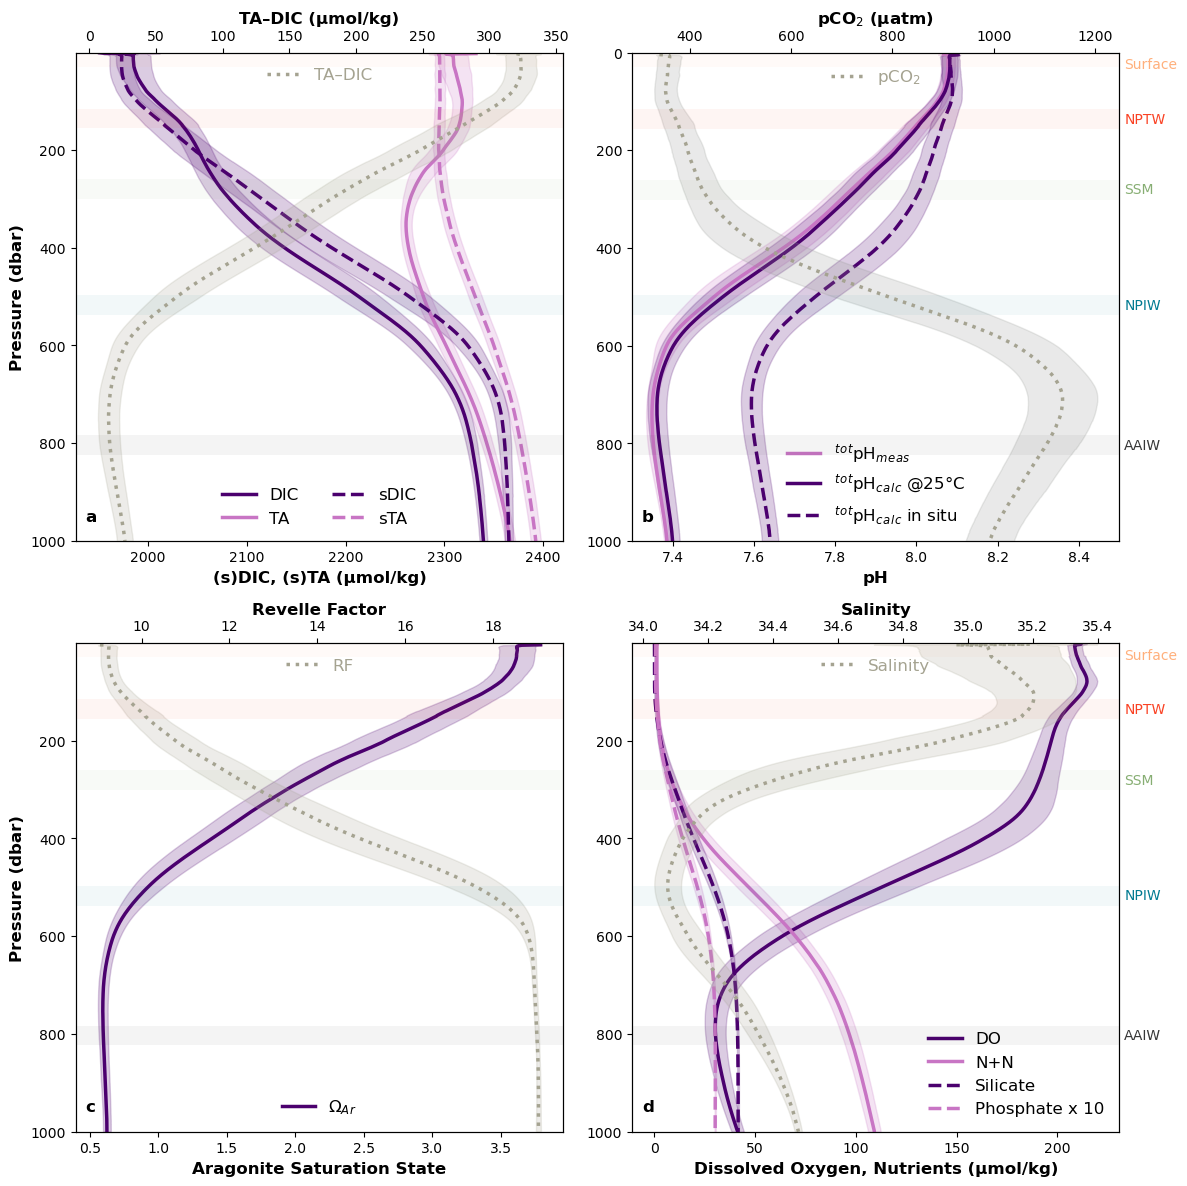

In [70]:
fig, axs = plt.subplots(2,2, figsize=(12,12))

warnings.filterwarnings("ignore", category=RuntimeWarning) ## warning about treatment of nans in the fill_between function

# Flatten the 2D array of axes for easier indexing
axs = axs.flatten()

## TA & DIC
ax = axs[0]

car_aloha_cr.mean(dim='time', skipna=True)['dic'].plot(y='pressure', linewidth=2.5, color='xkcd:royal purple', ax=ax)
car_aloha_cr.mean(dim='time', skipna=True)['alk'].plot(y='pressure', linewidth=2.5, color='xkcd:orchid', ax=ax)
car_aloha_cr.mean(dim='time', skipna=True)['sdic'].plot(y='pressure', linewidth=2.5, linestyle='--', color='xkcd:royal purple',  ax=ax)
car_aloha_cr.mean(dim='time', skipna=True)['salk'].plot(y='pressure', linewidth=2.5, linestyle='--', color='xkcd:orchid',  ax=ax)

ax.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             car_aloha_cr.mean(dim='time', skipna=True)['salk'] - car_aloha_cr.std(dim='time', skipna=True)['salk'], 
             car_aloha_cr.mean(dim='time', skipna=True)['salk'] + car_aloha_cr.std(dim='time', skipna=True)['salk'], 
             color='xkcd:orchid', alpha=0.2)

ax.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             car_aloha_cr.mean(dim='time', skipna=True)['dic'] - car_aloha_cr.std(dim='time', skipna=True)['dic'], 
             car_aloha_cr.mean(dim='time', skipna=True)['dic'] + car_aloha_cr.std(dim='time', skipna=True)['dic'], 
             color='xkcd:royal purple', alpha=0.2)

ax.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             car_aloha_cr.mean(dim='time', skipna=True)['alk'] - car_aloha_cr.std(dim='time', skipna=True)['alk'], 
             car_aloha_cr.mean(dim='time', skipna=True)['alk'] + car_aloha_cr.std(dim='time', skipna=True)['alk'], 
             color='xkcd:orchid', alpha=0.2)

ax.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             car_aloha_cr.mean(dim='time', skipna=True)['sdic'] - car_aloha_cr.std(dim='time', skipna=True)['sdic'], 
             car_aloha_cr.mean(dim='time', skipna=True)['sdic'] + car_aloha_cr.std(dim='time', skipna=True)['sdic'], 
             color='xkcd:royal purple', alpha=0.2)

ax2 = ax.twiny()  
car_aloha_cr.mean(dim='time', skipna=True)['alk_dic'].plot(y='pressure', linewidth=2.5, linestyle=':', color='xkcd:cement', ax=ax2)
ax2.set_xlabel('TA–DIC (µmol/kg)', color='black', fontsize=12, fontweight='bold')
#ax2.spines['top'].set_color('xkcd:cement')
#ax2.tick_params(axis='x', colors='xkcd:cement')

legend_ax2 = ax2.legend(['TA–DIC'], loc='upper center',fontsize=12,  frameon=False)
plt.setp(legend_ax2.get_texts(), color='xkcd:cement')

ax2.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             car_aloha_cr.mean(dim='time', skipna=True)['alk_dic'] - car_aloha_cr.std(dim='time', skipna=True)['alk_dic'], 
             car_aloha_cr.mean(dim='time', skipna=True)['alk_dic'] + car_aloha_cr.std(dim='time', skipna=True)['alk_dic'], 
             color='xkcd:cement', alpha=0.2)

plt.axhspan(1, 30, facecolor='xkcd:peach', alpha=0.05)
plt.axhspan(nptw.press.mean()-nptw.press.std(), nptw.press.mean()+nptw.press.std(), facecolor='xkcd:orangey red', alpha=0.05)
plt.axhspan(ssm.press.mean()-ssm.press.std(), ssm.press.mean()+ssm.press.std(), facecolor='xkcd:sage', alpha=0.05)
plt.axhspan(npiw.press.mean()-npiw.press.std(), npiw.press.mean()+npiw.press.std(), facecolor='xkcd:ocean', alpha=0.05)
plt.axhspan(aaiw.press.mean()-aaiw.press.std(), aaiw.press.mean()+aaiw.press.std(), facecolor='xkcd:dark grey', alpha=0.05)


legend_ax = ax.legend(['DIC','TA','sDIC','sTA'], loc='lower center', fontsize=12, ncols=2, frameon=False)
plt.setp(legend_ax.get_texts(), color='black')#xkcd:orchid')

ax.set_ylabel('Pressure (dbar)', fontsize=12, fontweight='bold')
#ax.spines['bottom'].set_color('xkcd:orchid')
ax.tick_params(axis='x')#, colors='xkcd:orchid')
ax.set_xlabel('(s)DIC, (s)TA (µmol/kg)', fontsize=12, fontweight='bold')#, color='xkcd:orchid')

ax.set_ylim(1,1000)
ax.invert_yaxis()


##pH
ax = axs[1]

car_aloha_cr.mean(dim='time')['ph'].plot(y='pressure', linewidth=2.5, color='xkcd:orchid', ax=ax)
car_aloha_cr.mean(dim='time')['pHout'].plot(y='pressure', linewidth=2.5, color='xkcd:royal purple', ax=ax)
car_aloha_cr.mean(dim='time')['pHin'].plot(y='pressure', linewidth=2.5, linestyle='--', color='xkcd:royal purple', ax=ax)

ax.fill_betweenx(car_aloha_int.mean(dim='time').pressure,
             car_aloha_cr.mean(dim='time')['ph'] - car_aloha_cr.std(dim='time')['ph'], 
             car_aloha_cr.mean(dim='time')['ph'] + car_aloha_cr.std(dim='time')['ph'], 
             color='xkcd:orchid', alpha=0.2)

ax.fill_betweenx(car_aloha_int.mean(dim='time').pressure,
             car_aloha_cr.mean(dim='time')['pHout'] - car_aloha_cr.std(dim='time')['pHout'], 
             car_aloha_cr.mean(dim='time')['pHout'] + car_aloha_cr.std(dim='time')['pHout'], 
             color='xkcd:royal purple', alpha=0.2)

ax.fill_betweenx(car_aloha_int.mean(dim='time').pressure,
             car_aloha_cr.mean(dim='time')['pHin'] - car_aloha_cr.std(dim='time')['pHin'], 
             car_aloha_cr.mean(dim='time')['pHin'] + car_aloha_cr.std(dim='time')['pHin'], 
             color='xkcd:royal purple', alpha=0.2)

ax2 = ax.twiny()  
car_aloha_cr.mean(dim='time')['pCO2in'].plot(y='pressure', linewidth=2.5, linestyle=':', color='xkcd:cement', ax=ax2)
ax2.set_xlabel('pCO$_2$ (µatm)', fontsize=12, fontweight='bold', color='black')
#ax2.spines['top'].set_color('xkcd:cement')
#ax2.tick_params(axis='x', colors='xkcd:cement')

legend_ax2 = ax2.legend(['pCO$_2$'], ncols=1, loc='upper center', fontsize=12, frameon=False)
plt.setp(legend_ax2.get_texts(), color='xkcd:cement')


ax2.fill_betweenx(car_aloha_int.mean(dim='time').pressure,
             car_aloha_cr.mean(dim='time')['pCO2in'] - car_aloha_cr.std(dim='time')['pCO2in'], 
             car_aloha_cr.mean(dim='time')['pCO2in'] + car_aloha_cr.std(dim='time')['pCO2in'], 
             color='xkcd:grey', alpha=0.2)


legend_ax = ax.legend(['$^t$$^o$$^t$pH$_m$$_e$$_a$$_s$','$^t$$^o$$^t$pH$_c$$_a$$_l$$_c$ @25°C','$^t$$^o$$^t$pH$_c$$_a$$_l$$_c$ in situ'], ncols=1, 
                      fontsize=12, loc='lower center', frameon=False)

plt.axhspan(1, 30, facecolor='xkcd:peach', alpha=0.05)
ax.text(1.01, 25, 'Surface', color='xkcd:peach', ha='left', va='center',transform=ax.get_yaxis_transform())
plt.axhspan(nptw.press.mean()-nptw.press.std(), nptw.press.mean()+nptw.press.std(), facecolor='xkcd:orangey red', alpha=0.05)
ax.text(1.01, nptw.press.mean(), 'NPTW', color='xkcd:orangey red', ha='left', va='center', transform=ax.get_yaxis_transform())
plt.axhspan(ssm.press.mean()-ssm.press.std(), ssm.press.mean()+ssm.press.std(), facecolor='xkcd:sage', alpha=0.05)
ax.text(1.01, ssm.press.mean(), 'SSM', color='xkcd:sage', ha='left', va='center', transform=ax.get_yaxis_transform())
plt.axhspan(npiw.press.mean()-npiw.press.std(), npiw.press.mean()+npiw.press.std(), facecolor='xkcd:ocean', alpha=0.05)
ax.text(1.01, npiw.press.mean(), 'NPIW', color='xkcd:ocean', ha='left', va='center', transform=ax.get_yaxis_transform())
plt.axhspan(aaiw.press.mean()-aaiw.press.std(), aaiw.press.mean()+aaiw.press.std(), facecolor='xkcd:dark grey', alpha=0.05)
ax.text(1.01, aaiw.press.mean(), 'AAIW', color='xkcd:dark grey', ha='left', va='center', transform=ax.get_yaxis_transform())

ax.set_xlabel('pH', fontsize=12, fontweight='bold')

ax.set_xlim(7.3, 8.5)

ax.set_ylim(0,1000)
ax.invert_yaxis()
ax.set_ylabel(None)

## RF & Omega
ax = axs[2]

car_aloha_cr.mean(dim='time', skipna=True)['OmegaARin'].plot(y='pressure', linewidth=2.5, color='xkcd:royal purple', ax=ax)

ax.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             car_aloha_cr.mean(dim='time', skipna=True)['OmegaARin'] - car_aloha_cr.std(dim='time', skipna=True)['OmegaARin'], 
             car_aloha_cr.mean(dim='time', skipna=True)['OmegaARin'] + car_aloha_cr.std(dim='time', skipna=True)['OmegaARin'], 
             color='xkcd:royal purple', alpha=0.2)

ax2 = ax.twiny()  

car_aloha_cr.mean(dim='time', skipna=True)['RFin'].plot(y='pressure', linewidth=2.5, linestyle=':', color='xkcd:cement', ax=ax2)
ax2.set_xlabel('Revelle Factor', color='black', fontsize=12, fontweight='bold')
#ax2.spines['top'].set_color('xkcd:cement')
#ax2.tick_params(axis='x', colors='xkcd:cement')
legend_ax2 = ax2.legend(['RF'], loc='upper center',fontsize=12,  frameon=False)
plt.setp(legend_ax2.get_texts(), color='xkcd:cement')

ax2.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             car_aloha_cr.mean(dim='time', skipna=True)['RFin'] - car_aloha_cr.std(dim='time', skipna=True)['RFin'], 
             car_aloha_cr.mean(dim='time', skipna=True)['RFin'] + car_aloha_cr.std(dim='time', skipna=True)['RFin'], 
             color='xkcd:cement', alpha=0.2)

plt.axhspan(1, 30, facecolor='xkcd:peach', alpha=0.05)
plt.axhspan(nptw.press.mean()-nptw.press.std(), nptw.press.mean()+nptw.press.std(), facecolor='xkcd:orangey red', alpha=0.05)
plt.axhspan(ssm.press.mean()-ssm.press.std(), ssm.press.mean()+ssm.press.std(), facecolor='xkcd:sage', alpha=0.05)
plt.axhspan(npiw.press.mean()-npiw.press.std(), npiw.press.mean()+npiw.press.std(), facecolor='xkcd:ocean', alpha=0.05)
plt.axhspan(aaiw.press.mean()-aaiw.press.std(), aaiw.press.mean()+aaiw.press.std(), facecolor='xkcd:dark grey', alpha=0.05)

legend_ax = ax.legend(['Ω$_A$$_r$'], loc='lower center', fontsize=12, ncols=2, frameon=False)
plt.setp(legend_ax.get_texts(), color='black')#xkcd:orchid')

ax.set_ylabel('Pressure (dbar)', fontsize=12, fontweight='bold')
#ax.spines['bottom'].set_color('xkcd:orchid')
ax.tick_params(axis='x')#, colors='xkcd:orchid')
ax.set_xlabel('Aragonite Saturation State', fontsize=12, fontweight='bold')#, color='xkcd:orchid')

ax.set_ylim(1,1000)
ax.invert_yaxis()

## nutrients and DO

ax = axs[3]

car_aloha_cr.mean(dim='time', skipna=True)['boxy'].plot(y='pressure', linewidth=2.5, color='xkcd:royal purple', ax=ax)
car_aloha_cr.mean(dim='time', skipna=True)['sil'].plot(y='pressure', linewidth=2.5, color='xkcd:orchid', ax=ax)
car_aloha_cr.mean(dim='time', skipna=True)['nit'].plot(y='pressure', linewidth=2.5, linestyle='--', color='xkcd:royal purple',  ax=ax)
(car_aloha_cr.mean(dim='time', skipna=True)['phos']*10).plot(y='pressure', linewidth=2.5, linestyle='--', color='xkcd:orchid',  ax=ax)

ax.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             (car_aloha_cr.mean(dim='time', skipna=True)['phos']*10) - (car_aloha_cr.std(dim='time', skipna=True)['phos']*10), 
             (car_aloha_cr.mean(dim='time', skipna=True)['phos']*10) + (car_aloha_cr.std(dim='time', skipna=True)['phos']*10), 
             color='xkcd:orchid', alpha=0.2)

ax.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             car_aloha_cr.mean(dim='time', skipna=True)['sil'] - car_aloha_cr.std(dim='time', skipna=True)['sil'], 
             car_aloha_cr.mean(dim='time', skipna=True)['sil'] + car_aloha_cr.std(dim='time', skipna=True)['sil'], 
             color='xkcd:orchid', alpha=0.2)

ax.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             car_aloha_cr.mean(dim='time', skipna=True)['nit'] - car_aloha_cr.std(dim='time', skipna=True)['nit'], 
             car_aloha_cr.mean(dim='time', skipna=True)['nit'] + car_aloha_cr.std(dim='time', skipna=True)['nit'], 
             color='xkcd:royal purple', alpha=0.2)


ax.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             car_aloha_cr.mean(dim='time', skipna=True)['boxy'] - car_aloha_cr.std(dim='time', skipna=True)['boxy'], 
             car_aloha_cr.mean(dim='time', skipna=True)['boxy'] + car_aloha_cr.std(dim='time', skipna=True)['boxy'], 
             color='xkcd:royal purple', alpha=0.2)

ax2 = ax.twiny()  
car_aloha_cr.mean(dim='time', skipna=True)['csal'].plot(y='pressure', linewidth=2.5, linestyle=':', color='xkcd:cement', ax=ax2)
ax2.set_xlabel('Salinity', color='black', fontsize=12, fontweight='bold')
#ax2.spines['top'].set_color('xkcd:cement')
#ax2.tick_params(axis='x', colors='xkcd:cement')
#ax2.set_xlim(0,500)
legend_ax2 = ax2.legend(['Salinity'], loc='upper center',fontsize=12,  frameon=False)
plt.setp(legend_ax2.get_texts(), color='xkcd:cement')

ax2.fill_betweenx(car_aloha_int.mean(dim='time', skipna=True).pressure,
             car_aloha_cr.mean(dim='time', skipna=True)['csal'] - car_aloha_cr.std(dim='time', skipna=True)['csal'], 
             car_aloha_cr.mean(dim='time', skipna=True)['csal'] + car_aloha_cr.std(dim='time', skipna=True)['csal'], 
             color='xkcd:cement', alpha=0.2)

plt.axhspan(1, 30, facecolor='xkcd:peach', alpha=0.05)
ax.text(1.01, 25, 'Surface', color='xkcd:peach', ha='left', va='center',transform=ax.get_yaxis_transform())
plt.axhspan(nptw.press.mean()-nptw.press.std(), nptw.press.mean()+nptw.press.std(), facecolor='xkcd:orangey red', alpha=0.05)
ax.text(1.01, nptw.press.mean(), 'NPTW', color='xkcd:orangey red', ha='left', va='center', transform=ax.get_yaxis_transform())
plt.axhspan(ssm.press.mean()-ssm.press.std(), ssm.press.mean()+ssm.press.std(), facecolor='xkcd:sage', alpha=0.05)
ax.text(1.01, ssm.press.mean(), 'SSM', color='xkcd:sage', ha='left', va='center', transform=ax.get_yaxis_transform())
plt.axhspan(npiw.press.mean()-npiw.press.std(), npiw.press.mean()+npiw.press.std(), facecolor='xkcd:ocean', alpha=0.05)
ax.text(1.01, npiw.press.mean(), 'NPIW', color='xkcd:ocean', ha='left', va='center', transform=ax.get_yaxis_transform())
plt.axhspan(aaiw.press.mean()-aaiw.press.std(), aaiw.press.mean()+aaiw.press.std(), facecolor='xkcd:dark grey', alpha=0.05)
ax.text(1.01, aaiw.press.mean(), 'AAIW', color='xkcd:dark grey', ha='left', va='center', transform=ax.get_yaxis_transform())

legend_ax = ax.legend(['DO', 'N+N','Silicate','Phosphate x 10'], loc='lower right', fontsize=12, ncols=1, frameon=False)
plt.setp(legend_ax.get_texts(), color='black')#xkcd:orchid')

ax.set_ylabel('Pressure (dbar)', fontweight='bold')
#ax.spines['bottom'].set_color('xkcd:orchid')
ax.tick_params(axis='x')#, colors='xkcd:orchid')
ax.set_xlabel('Dissolved Oxygen, Nutrients (µmol/kg)', fontsize=12, fontweight='bold')#, color='xkcd:orchid')

ax.set_ylim(1,1000)
ax.invert_yaxis()
ax.set_ylabel(None)

# Add labels for each subplot
axs[0].text(0.02, 0.05, 'a', transform=axs[0].transAxes, ha='left', va='center', fontsize=12, fontweight='bold')
axs[1].text(0.02, 0.05, 'b', transform=axs[1].transAxes, ha='left', va='center', fontsize=12, fontweight='bold')
axs[2].text(0.02, 0.05, 'c', transform=axs[2].transAxes, ha='left', va='center', fontsize=12, fontweight='bold')
axs[3].text(0.02, 0.05, 'd', transform=axs[3].transAxes, ha='left', va='center', fontsize=12, fontweight='bold')

fig.tight_layout(pad=1.2)

plt.savefig('LK_Fig1.png', dpi=300)

# Data Analysis: Trend Analysis

In [71]:
## Generate decimal year 
for wm in wms:
    wm['year'] = wm.index.year
    wm['month'] = wm.index.month
    wm['day'] = wm.index.day
    wm['decimal_month'] = decimal_month(wm['year'], wm['month'], wm['day'])
    wm['decimal_year'] = wm['year'] + (wm['decimal_month'] - 1) / 12

In [72]:
## Calculate trends

surf_trends, surf_slopes, surf_intercepts, surf_rs, surf_ps, surf_errs = trend(surf)
nptw_trends, nptw_slopes, nptw_intercepts, nptw_rs, nptw_ps, nptw_errs = trend(nptw)
ssm_trends, ssm_slopes, ssm_intercepts, ssm_rs, ssm_ps, ssm_errs = trend(ssm)
npiw_trends, npiw_slopes, npiw_intercepts, npiw_rs, npiw_ps, npiw_errs = trend(npiw)
aaiw_trends, aaiw_slopes, aaiw_intercepts, aaiw_rs, aaiw_ps, aaiw_errs = trend(aaiw)

In [73]:
## Data detrended, with seasonal cycle

surf_detrended = surf - surf_trends + surf.mean()
nptw_detrended = nptw - nptw_trends + nptw.mean()
ssm_detrended = ssm - ssm_trends + ssm.mean()
npiw_detrended = npiw - npiw_trends + npiw.mean()
aaiw_detrended = aaiw - aaiw_trends + aaiw.mean()

In [74]:
## Full model with trend and seasonal cycle, generating the model fit and the residuals (anomalies)

surf_anom, surf_fit = detrend_deseason(surf, 2004) ## anomalies and model
surf_season = surf_fit - surf_trends   ## seasonal cycle model 
surf_deseasoned = surf - surf_season ## deseasoned data (with trend)

nptw_anom, nptw_fit = detrend_deseason(nptw, 2004) ## anomalies and model
nptw_season = nptw_fit - nptw_trends   ## seasonal cycle model 
nptw_deseasoned = nptw - nptw_season ## deseasoned data (with trend)

ssm_anom, ssm_fit = detrend_deseason(ssm, 2004) ## anomalies and model
ssm_season = ssm_fit - ssm_trends   ## seasonal cycle model 
ssm_deseasoned = ssm - ssm_season ## deseasoned data (with trend)

npiw_anom, npiw_fit = detrend_deseason(npiw, 2004) ## anomalies and model
npiw_season = npiw_fit - npiw_trends   ## seasonal cycle model 
npiw_deseasoned = npiw - npiw_season ## deseasoned data (with trend)

aaiw_anom, aaiw_fit = detrend_deseason(aaiw, 2004) ## anomalies and model
aaiw_season = aaiw_fit - aaiw_trends   ## seasonal cycle model 
aaiw_deseasoned = aaiw - aaiw_season ## deseasoned data (with trend) 

In [75]:
plotting_names = ['Pressure','Theta','Density (σθ)','Temperature','Salinity','Spice','DIC','TA','pH$_m$$_e$$_a$$_s$}',
                 'sTA','sDIC','TA–DIC','DO','Phosphate','Silicate','N+N', 'AOU', 'O$_2$@sat', 'Chl a (fl)',
                 'Chl a (HPLC)', 'PC','DOC','PO','TA0','ΩAr','pH$_c$$_a$$_l$$_c$, in situ', 'RF','pCO$_2$',
                  'pH$_c$$_a$$_l$$_c$, 25°C','fH, 25°C','fH','free H+']

usecols = range(3,31)

plotting_names_npiw = ['Pressure','Theta','Density (σθ)','Temperature','Salinity','Spice','DIC','TA','pH$_m$$_e$$_a$$_s$}',
                 'sTA','sDIC','TA–DIC','DO','Phosphate','Silicate','N+N', 'AOU', 'O$_2$@sat', 'PC','DOC','PO','TA0','ΩAr','pH$_c$$_a$$_l$$_c$, in situ', 'RF','pCO$_2$',
                  'pH$_c$$_a$$_l$$_c$, 25°C','fH, 25°C','fH','free H+']

usecols_npiw = range(3,28)

In [76]:
## plot the model: Surface

for name, column in zip([plotting_names[i] for i in usecols], surf.columns[usecols]):
    
    fig, ax = plt.subplots(3, sharex=True)
    
    ax[0].plot(surf.index, surf[column], marker='.')
    ax[0].plot(surf_detrended.index, surf_detrended[column], marker='.')
    ax[0].legend(['Data', 'Detrended'], fontsize=5)
    
    ax[1].plot(surf_fit.index, surf_fit[column])
    ax[1].plot(surf_trends.index, surf_trends[column])
    ax[1].plot(surf_season.index, (surf_season[column]+surf.mean()[column]))
    ax[1].legend(['complete model', 'linear trend', 'seasonal fit'], fontsize=5)
    
    ax[2].plot(surf_detrended.index, surf_detrended[column], '.')
    ax[2].plot(surf_anom.index, (surf_anom[column]+surf.mean()[column]), '.')
    ax[2].legend(['Detrended', 'Detrended and deseasoned (residuals)'], fontsize=5)
    
    ax[0].set_title(f'{name} Model Fit (Trend and Seasonal Cycle) and Residuals (Surface)')
    
    plt.savefig(f'LK_FigS3_surf_{column}_model.png', dpi=300)
    plt.close()

In [77]:
## plot the model: nptw

for name, column in zip([plotting_names[i] for i in usecols], nptw.columns[usecols]):
    
    fig, ax = plt.subplots(3, sharex=True)
    
    ax[0].plot(nptw.index, nptw[column], marker='.')
    ax[0].plot(nptw_detrended.index, nptw_detrended[column], marker='.')
    ax[0].legend(['Data', 'Detrended'], fontsize=5)
    
    ax[1].plot(nptw_fit.index, nptw_fit[column])
    ax[1].plot(nptw_trends.index, nptw_trends[column])
    ax[1].plot(nptw_season.index, (nptw_season[column]+nptw.mean()[column]))
    ax[1].legend(['complete model', 'linear trend', 'seasonal fit'], fontsize=5)
    
    ax[2].plot(nptw_detrended.index, nptw_detrended[column], '.')
    ax[2].plot(nptw_anom.index, (nptw_anom[column]+nptw.mean()[column]), '.')
    ax[2].legend(['Detrended', 'Detrended and deseasoned (residuals)'], fontsize=5)
    
    ax[0].set_title(f'{name} Model Fit (Trend and Seasonal Cycle) and Residuals (NPTW)')
    
    plt.savefig(f'LK_FigS3_nptw_{column}_model.png', dpi=300)
    plt.close()

In [78]:
## plot the model: ssm

for name, column in zip([plotting_names[i] for i in usecols], ssm.columns[usecols]):
    
    fig, ax = plt.subplots(3, sharex=True)
    
    ax[0].plot(ssm.index, ssm[column], marker='.')
    ax[0].plot(ssm_detrended.index, ssm_detrended[column], marker='.')
    ax[0].legend(['Data', 'Detrended'], fontsize=5)
    
    ax[1].plot(ssm_fit.index, ssm_fit[column])
    ax[1].plot(ssm_trends.index, ssm_trends[column])
    ax[1].plot(ssm_season.index, (ssm_season[column]+ssm.mean()[column]))
    ax[1].legend(['complete model', 'linear trend', 'seasonal fit'], fontsize=5)
    
    ax[2].plot(ssm_detrended.index, ssm_detrended[column], '.')
    ax[2].plot(ssm_anom.index, (ssm_anom[column]+ssm.mean()[column]), '.')
    ax[2].legend(['Detrended', 'Detrended and deseasoned (residuals)'], fontsize=5)
    
    ax[0].set_title(f'{name} Model Fit (Trend and Seasonal Cycle) and Residuals (SSM)')
    
    plt.savefig(f'LK_FigS3_ssm_{column}_model.png', dpi=300)
    plt.close()

In [79]:
## plot the model: npiw

for name, column in zip([plotting_names_npiw[i] for i in usecols_npiw], npiw.columns[usecols_npiw]):
    
    fig, ax = plt.subplots(3, sharex=True)
    
    ax[0].plot(npiw.index, npiw[column], marker='.')
    ax[0].plot(npiw_detrended.index, npiw_detrended[column], marker='.')
    ax[0].legend(['Data', 'Detrended'], fontsize=5)
    
    ax[1].plot(npiw_fit.index, npiw_fit[column])
    ax[1].plot(npiw_trends.index, npiw_trends[column])
    ax[1].plot(npiw_season.index, (npiw_season[column]+npiw.mean()[column]))
    ax[1].legend(['complete model', 'linear trend', 'seasonal fit'], fontsize=5)
    
    ax[2].plot(npiw_detrended.index, npiw_detrended[column], '.')
    ax[2].plot(npiw_anom.index, (npiw_anom[column]+npiw.mean()[column]), '.')
    ax[2].legend(['Detrended', 'Detrended and deseasoned (residuals)'], fontsize=5)
    
    ax[0].set_title(f'{name} Model Fit (Trend and Seasonal Cycle) and Residuals (NPIW)')
    
    plt.savefig(f'LK_FigS3_npiw_{column}_model.png', dpi=300)
    plt.close()

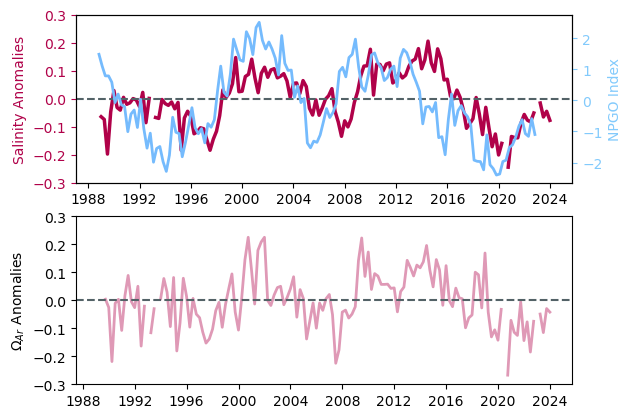

In [80]:
fig, axs = plt.subplots(2)
axs[0].plot(nptw_anom.resample('3ME').mean().index, nptw_anom.resample('3ME').mean()['csal'], linewidth=2.5, color='xkcd:raspberry')
axs[0].set_ylim(-0.3,0.3)
#axs[0].spines['left'].set_color('xkcd:raspberry')
axs[0].tick_params(axis='y', colors='xkcd:raspberry')
axs[0].set_ylabel('Salinity Anomalies', color='xkcd:raspberry')

ax2 = axs[0].twinx()
ax2.plot(npgo_re.resample('3ME').mean().index, npgo_re.resample('3ME').mean()['npgo'], linewidth=2, color='xkcd:sky blue')

#ax2.spines['right'].set_color('xkcd:sky')
ax2.tick_params(axis='y', colors='xkcd:sky')
ax2.set_ylabel('NPGO Index', color='xkcd:sky')

axs[0].axhline(0, linestyle='--', color='xkcd:gunmetal')

axs[1].plot(nptw_anom.resample('3ME').mean().index, nptw_anom.resample('3ME').mean()['OmegaARin'], linewidth=2, color='xkcd:raspberry', alpha=0.4)
axs[1].set_ylim(-0.3,0.3)
axs[1].axhline(0, linestyle='--', color='xkcd:gunmetal')
axs[1].set_ylabel('Ω$_A$$_r$ Anomalies')
plt.savefig(fig_dir+'LK_Fig6_NPGO_ΩAr.png',dpi=300)

In [81]:
# Deseasoned trends 
surf_deseasoned_trends, surf_deseasoned_slopes, surf_deseasoned_intercepts, surf_deseasoned_rs, surf_deseasoned_ps, surf_deseasoned_errs = trend(surf_deseasoned)
nptw_deseasoned_trends, nptw_deseasoned_slopes, nptw_deseasoned_intercepts, nptw_deseasoned_rs, nptw_deseasoned_ps, nptw_deseasoned_errs = trend(nptw_deseasoned)
ssm_deseasoned_trends, ssm_deseasoned_slopes, ssm_deseasoned_intercepts, ssm_deseasoned_rs, ssm_deseasoned_ps, ssm_deseasoned_errs = trend(ssm_deseasoned)
npiw_deseasoned_trends, npiw_deseasoned_slopes, npiw_deseasoned_intercepts, npiw_deseasoned_rs, npiw_deseasoned_ps, npiw_deseasoned_errs = trend(npiw_deseasoned)
aaiw_deseasoned_trends, aaiw_deseasoned_slopes, aaiw_deseasoned_intercepts, aaiw_deseasoned_rs, aaiw_deseasoned_ps, aaiw_deseasoned_errs = trend(aaiw_deseasoned)

In [82]:
## create Dataframes with slopes and slope errors for each variable in each water mass (Table 2)

surf_slope = pd.DataFrame([t[1] for t in surf_deseasoned_slopes], index=[t[0] for t in surf_deseasoned_slopes], columns=['surf_slope'])
surf_err = pd.DataFrame([t[1] for t in surf_deseasoned_errs], index=[t[0] for t in surf_deseasoned_errs], columns=['surf_err'])

nptw_slope = pd.DataFrame([t[1] for t in nptw_deseasoned_slopes], index=[t[0] for t in nptw_deseasoned_slopes], columns=['nptw_slope'])
nptw_err = pd.DataFrame([t[1] for t in nptw_deseasoned_errs], index=[t[0] for t in nptw_deseasoned_errs], columns=['nptw_err'])

ssm_slope = pd.DataFrame([t[1] for t in ssm_deseasoned_slopes], index=[t[0] for t in ssm_deseasoned_slopes], columns=['ssm_slope'])
ssm_err = pd.DataFrame([t[1] for t in ssm_deseasoned_errs], index=[t[0] for t in ssm_deseasoned_errs], columns=['ssm_err'])

npiw_slope = pd.DataFrame([t[1] for t in npiw_deseasoned_slopes], index=[t[0] for t in npiw_deseasoned_slopes], columns=['npiw_slope'])
npiw_err = pd.DataFrame([t[1] for t in npiw_deseasoned_errs], index=[t[0] for t in npiw_deseasoned_errs], columns=['npiw_err'])

aaiw_slope = pd.DataFrame([t[1] for t in aaiw_deseasoned_slopes], index=[t[0] for t in aaiw_deseasoned_slopes], columns=['aaiw_slope'])
aaiw_err = pd.DataFrame([t[1] for t in aaiw_deseasoned_errs], index=[t[0] for t in aaiw_deseasoned_errs], columns=['aaiw_err'])

In [83]:
## Extract variables with significant slopes (p<0.005)
surf_sig_vars = [t[0] for t in surf_deseasoned_ps if t[1] < 0.005]
nptw_sig_vars = [t[0] for t in nptw_deseasoned_ps if t[1] < 0.005]
ssm_sig_vars = [t[0] for t in ssm_deseasoned_ps if t[1] < 0.005]
npiw_sig_vars = [t[0] for t in npiw_deseasoned_ps if t[1] < 0.005]
aaiw_sig_vars = [t[0] for t in aaiw_deseasoned_ps if t[1] < 0.005]

In [84]:
## Select only variables with significant slopes
surf_slope = surf_slope.loc[surf_sig_vars].drop(['decimal_year', 'year'])
nptw_slope = nptw_slope.loc[nptw_sig_vars].drop(['decimal_year','year'])
ssm_slope = ssm_slope.loc[ssm_sig_vars].drop(['decimal_year','year'])
npiw_slope = npiw_slope.loc[npiw_sig_vars].drop(['decimal_year','year'])
aaiw_slope = aaiw_slope.loc[aaiw_sig_vars].drop(['decimal_year','year'])

In [85]:
## Create DataFrame with significant slopes for all water masses – values in Table 2, Figure 4

all_slopes = surf_slope.merge(nptw_slope, left_index=True, right_index = True, how='outer').merge(ssm_slope, left_index=True, right_index = True, how='outer').merge(npiw_slope, left_index=True, right_index = True, how='outer').merge(aaiw_slope, left_index=True, right_index = True, how='outer')
all_slopes = all_slopes.transpose()
export = all_slopes.to_csv('LK_Table2_significant_trends_full_timeseries.csv')

In [86]:
## Create DataFrame with slope errors for all water masses – uncertainty in Table 2, Figure 4

all_errs = surf_err.merge(nptw_err, left_index=True, right_index = True, how='outer').merge(ssm_err, left_index=True, right_index = True, how='outer').merge(npiw_err, left_index=True, right_index = True, how='outer').merge(aaiw_err, left_index=True, right_index = True, how='outer')
all_errs = all_errs.transpose()
export = all_errs.to_csv('LK_Table2_slope_errors_full_timeseries.csv')

/var/folders/nj/szt8lwtn2rb8rksl6pt521wh0000gp/T/ipykernel_4973/3183286011.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['Surface\n0-30m','NPTW\n24.3-24.7\n~135m',
/var/folders/nj/szt8lwtn2rb8rksl6pt521wh0000gp/T/ipykernel_4973/3183286011.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['Surface\n0-30m','NPTW\n24.3-24.7\n~135m',


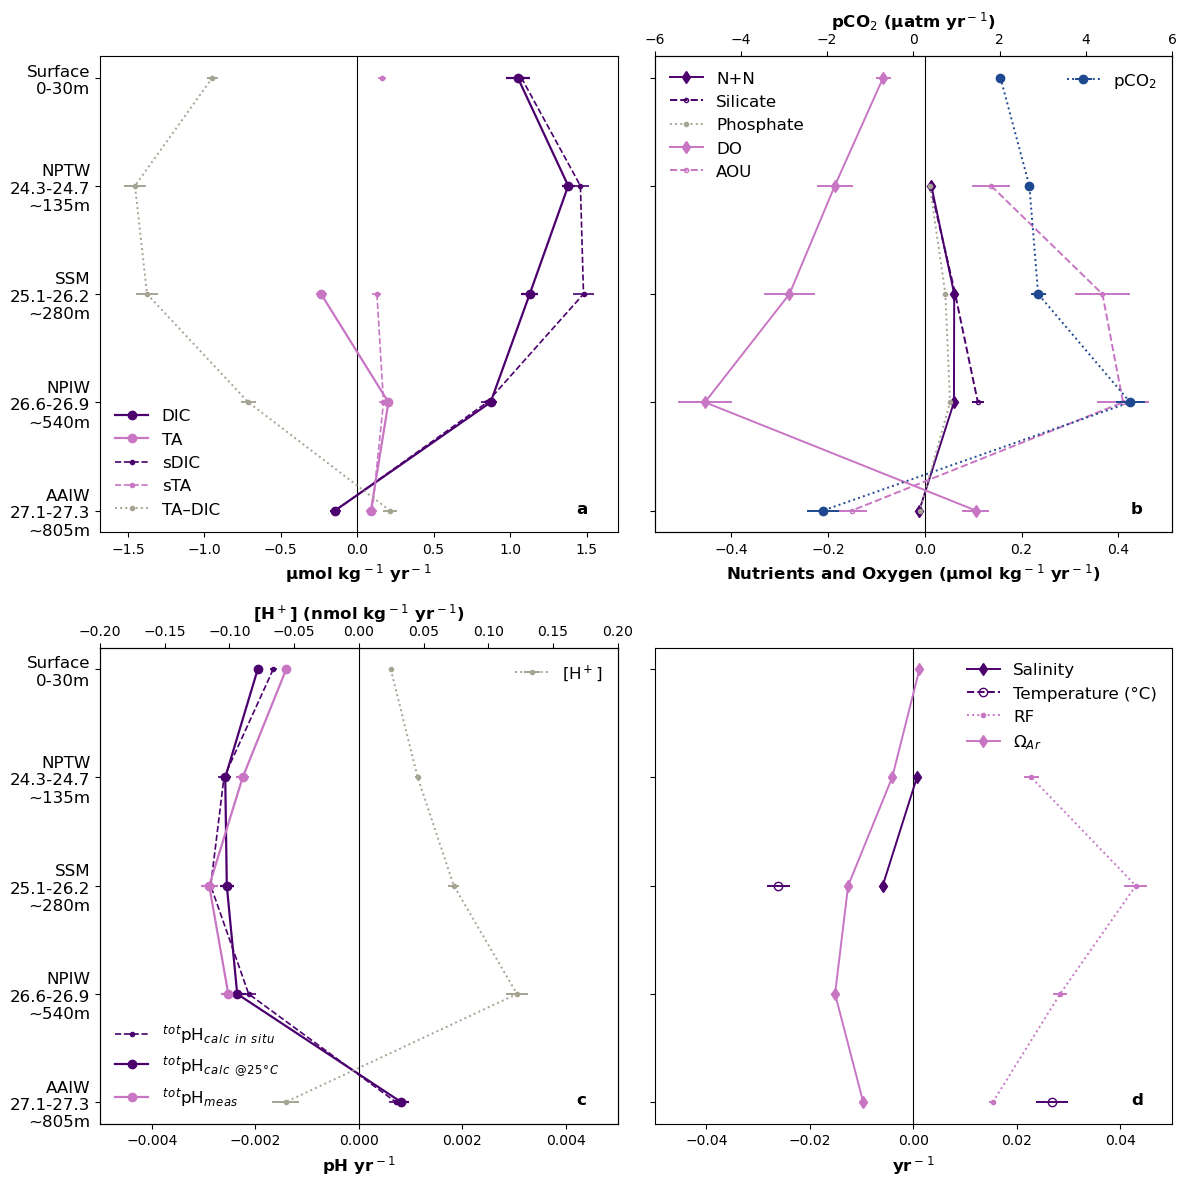

In [87]:
fig, axs = plt.subplots(2,2, figsize=(12,12))

# Flatten the 2D array of axes for easier indexing
axs = axs.flatten()

## TA & DIC
ax = axs[0]

ax.errorbar(all_slopes['dic'], all_slopes.index, 
            xerr=all_errs['dic'],marker='o', color='xkcd:royal purple', linewidth=1.6)

ax.errorbar(all_slopes['alk'], all_slopes.index, 
            xerr=all_errs['alk'],marker='o', color='xkcd:orchid', linewidth=1.6)

ax.errorbar(all_slopes['sdic'], all_slopes.index, 
            xerr=all_errs['sdic'],marker='.', color='xkcd:royal purple', linestyle='--', linewidth=1.2)       

ax.errorbar(all_slopes['salk'], all_slopes.index, 
            xerr=all_errs['salk'],marker='.', color='xkcd:orchid', linestyle='--', linewidth=1.2)
        
ax.errorbar(all_slopes['alk_dic'], all_slopes.index, 
            xerr=all_errs['alk_dic'],marker='.', color='xkcd:cement', linestyle=':', linewidth=1.4)       
        
ax.set_yticklabels(['Surface\n0-30m','NPTW\n24.3-24.7\n~135m',
                    'SSM\n25.1-26.2\n~280m','NPIW\n26.6-26.9\n~540m',
                   'AAIW\n27.1-27.3\n~805m'], fontsize=12)
legend_handles = [
    Line2D([0], [0], marker='o', color='xkcd:royal purple', linewidth=1.6, label='DIC'),
    Line2D([0], [0], marker='o', color='xkcd:orchid', linewidth=1.6, label='TA'),
    Line2D([0], [0], marker='.',  color='xkcd:royal purple', linestyle='--', linewidth=1.2, label='sDIC'),
    Line2D([0], [0], marker='.',  color='xkcd:orchid', linestyle='--', linewidth=1.2, label='sTA'),
    Line2D([0], [0], marker='.', color='xkcd:cement', linestyle=':', linewidth=1.4, label='TA–DIC')
]

ax.legend(handles=legend_handles, frameon=False, fontsize=12, loc='lower left')

ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('µmol kg$^-$$^1$ yr$^-$$^1$', fontweight='bold', fontsize=12)
ax.invert_yaxis()


## nutrients, oxygen, pco2
ax = axs[1]

ax.errorbar(all_slopes['nit'], all_slopes.index, 
            xerr=all_errs['nit'],marker='d', color='xkcd:royal purple', linewidth=1.4)

ax.errorbar(all_slopes['sil'], all_slopes.index, 
            xerr=all_errs['sil'],marker='.', markerfacecolor='none', color='xkcd:royal purple', linestyle='--', linewidth=1.4)       

ax.errorbar(all_slopes['phos']*10, all_slopes.index, 
            xerr=all_errs['phos']*10,marker='.', color='xkcd:cement', linestyle=':', linewidth=1.4)       

ax.errorbar(all_slopes['boxy'], all_slopes.index, 
            xerr=all_errs['boxy'],marker='d', color='xkcd:orchid', linewidth=1.4)

ax.errorbar(all_slopes['aou'], all_slopes.index, 
            xerr=all_errs['aou'],marker='.', markerfacecolor='none', color='xkcd:orchid', linestyle='--', linewidth=1.4)
        
ax.set_yticklabels([])
legend_handles = [
    Line2D([0], [0], marker='d', color='xkcd:royal purple', linewidth=1.4, label='N+N'),
    Line2D([0], [0], marker='.', markerfacecolor='none',  color='xkcd:royal purple', linestyle='--', linewidth=1.4, label='Silicate'),
    Line2D([0], [0], marker='.', color='xkcd:cement', linestyle=':', linewidth=1.4, label='Phosphate'),
    Line2D([0], [0], marker='d',  color='xkcd:orchid', linewidth=1.4, label='DO'),
    Line2D([0], [0], marker='.', markerfacecolor='none', color='xkcd:orchid', linestyle='--', linewidth=1.4, label='AOU')
]

ax.legend(handles=legend_handles, frameon=False, loc='upper left', fontsize=12)
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Nutrients and Oxygen (µmol kg$^-$$^1$ yr$^-$$^1$)', fontweight='bold', fontsize=12)
ax.invert_yaxis()

ax2 = ax.twiny()
ax2.errorbar(all_slopes['pCO2in'], all_slopes.index, 
            xerr=all_errs['pCO2in'],marker='o', color='xkcd:cobalt', linestyle=':', linewidth=1.4)       
ax2.legend(['pCO$_2$'],  loc='upper right', frameon=False, fontsize=12)
ax2.set_xlabel('pCO$_2$ (µatm yr$^-$$^1$)', fontweight='bold', color='black', fontsize=12)
#ax2.spines['top'].set_color('xkcd:cobalt')
#ax2.tick_params(axis='x', colors='xkcd:cobalt')
ax2.set_xlim(-6,6)

## pH & H+
ax = axs[2]

ax.errorbar(all_slopes['pHin'], all_slopes.index, 
            xerr=all_errs['pHin'],marker='o', color='xkcd:royal purple', linewidth=1.6)

ax.errorbar(all_slopes['pHout'], all_slopes.index, 
            xerr=all_errs['pHout'],marker='.', color='xkcd:royal purple', linestyle='--', linewidth=1.2) 

ax.errorbar(all_slopes['ph'], all_slopes.index, 
            xerr=all_errs['ph'],marker='o', color='xkcd:orchid', linewidth=1.6)

ax.set_yticklabels(['Surface\n0-30m','NPTW\n24.3-24.7\n~135m',
                    'SSM\n25.1-26.2\n~280m','NPIW\n26.6-26.9\n~540m',
                   'AAIW\n27.1-27.3\n~805m'], fontsize=12)
legend_handles = [
    Line2D([0], [0], marker='.',  color='xkcd:royal purple', linestyle='--', linewidth=1.2, 
           label='$^t$$^o$$^t$pH$_c$$_a$$_l$$_c$ $_i$$_n$$_ $$_s$$_i$$_t$$_u$'),
    Line2D([0], [0], marker='o', color='xkcd:royal purple', linewidth=1.6, label='$^t$$^o$$^t$pH$_c$$_a$$_l$$_c$ $_@$$_2$$_5$$_°$$_C$'),
    Line2D([0], [0], marker='o', color='xkcd:orchid', linewidth=1.6, label='$^t$$^o$$^t$pH$_m$$_e$$_a$$_s$'),
]

ax.legend(handles=legend_handles, frameon=False, fontsize=12, loc='lower left')

ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('pH yr$^-$$^1$', fontweight='bold', fontsize=12)
ax.set_xlim(-0.005, 0.005)  
ax.invert_yaxis()     
ax2 = ax.twiny()
ax2.errorbar((all_slopes['Hfree']*1000), all_slopes.index, 
            xerr=(all_errs['Hfree']*1000),marker='.', color='xkcd:cement', linestyle=':', linewidth=1.4)       
ax2.legend(['[H$^+$]'],  loc='upper right', fontsize=12, frameon=False)
ax2.set_xlabel('[H$^+$] (nmol kg$^-$$^1$ yr$^-$$^1$)', color='black', fontweight='bold', fontsize=12)
#ax2.spines['top'].set_color('xkcd:cement')
#ax2.tick_params(axis='x', colors='xkcd:cement')
ax2.set_xlim((-0.20), (+0.20))       

## T, S, ΩAr, RF
ax = axs[3]

ax.errorbar(all_slopes['csal'], all_slopes.index, 
            xerr=all_errs['csal'],marker='d', color='xkcd:royal purple', linewidth=1.4)

ax.errorbar(all_slopes['temp'], all_slopes.index, 
            xerr=all_errs['temp'],marker='o', markerfacecolor='none', color='xkcd:royal purple', linestyle='--', linewidth=1.4)       

ax.errorbar(all_slopes['RFin'], all_slopes.index, 
            xerr=all_errs['RFin'],marker='.', color='xkcd:orchid', linestyle=':', linewidth=1.4)       
        
ax.errorbar(all_slopes['OmegaARin'], all_slopes.index, 
            xerr=all_errs['OmegaARin'],marker='d', color='xkcd:orchid', linewidth=1.4)

ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('yr$^-$$^1$', fontsize=12, fontweight='bold')
ax.set_yticklabels([])

legend_handles = [
    Line2D([0], [0], marker='d', color='xkcd:royal purple', linewidth=1.4, label='Salinity'),
    Line2D([0], [0], marker='o', markerfacecolor='none',  color='xkcd:royal purple', linestyle='--', linewidth=1.4, label='Temperature (°C)'),
    Line2D([0], [0], marker='.', color='xkcd:orchid', linestyle=':', linewidth=1.4, label='RF'),
    Line2D([0], [0], marker='d',  color='xkcd:orchid', linewidth=1.4, label='Ω$_A$$_r$'),
]

ax.legend(handles=legend_handles, frameon=False, loc='upper right', fontsize=12)
ax.set_xlim(-0.05,0.05)
                      
# Add labels for each subplot
axs[0].text(0.92, 0.05, 'a', transform=axs[0].transAxes, ha='left', va='center', fontsize=12, fontweight='bold')
axs[1].text(0.92, 0.05, 'b', transform=axs[1].transAxes, ha='left', va='center', fontsize=12, fontweight='bold')
axs[2].text(0.92, 0.05, 'c', transform=axs[2].transAxes, ha='left', va='center', fontsize=12, fontweight='bold')
axs[3].text(0.92, 0.05, 'd', transform=axs[3].transAxes, ha='left', va='center', fontsize=12, fontweight='bold')


fig.tight_layout(pad=1.2)

plt.savefig('LK_Fig4.png', dpi=300)

# Data Analysis: Lagged Correlations

In [88]:
## Annual mean
surf_dd = surf_anom.resample('YE').apply(minimum_annual_obs)
nptw_dd = nptw_anom.resample('YE').apply(minimum_annual_obs)
ssm_dd = ssm_anom.resample('YE').apply(minimum_annual_obs)
npiw_dd = npiw_anom.resample('YE').apply(minimum_annual_obs)
aaiw_dd = aaiw_anom.resample('YE').apply(minimum_annual_obs)

wms_dd = [surf_dd, nptw_dd, ssm_dd, npiw_dd, aaiw_dd]

In [90]:
npgo_an = npgo_re.resample('YE').mean()['npgo']
npgo_an.index = npgo_an.index.year

strat_200_an = strat_200_re.resample('YE').mean()['sigma']
strat_200_an.index = strat_200_an.index.year

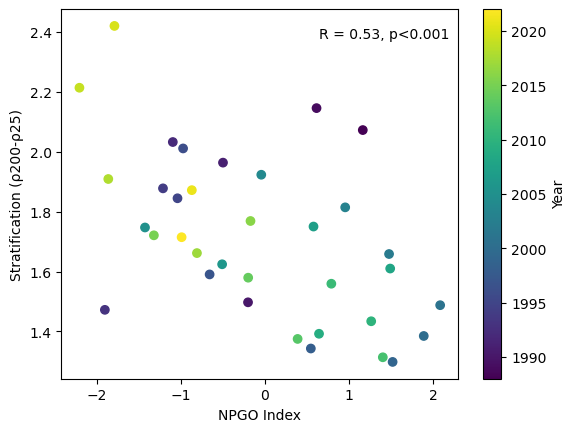

In [223]:
x = npgo_an
y = strat_200_an[strat_200_an.index <= 2022]
c = x.index  

fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=c, cmap='viridis')  # or 'plasma', 'coolwarm', etc.

ax.text(0.65, 0.95, 'R = 0.53, p<0.001', transform=ax.transAxes, fontsize=10,
        verticalalignment='top')


# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Year')  

# Labels and save
ax.set_ylabel('Stratification (ρ200-ρ25)')
ax.set_xlabel('NPGO Index')
plt.savefig('LK_Fig7.png', dpi=500)

In [215]:
stats.linregress(npgo_an, strat_200_an[(strat_200_an.index <= 2022)])

LinregressResult(slope=-0.12295242963463177, intercept=1.7061084930450252, rvalue=-0.5358689563127604, pvalue=0.0009076565782531855, stderr=0.03372243580839313, intercept_stderr=0.04014686798721197)

In [91]:
# Add in NPGO and stratification

for wm in wms_dd:
    wm.index = wm.index.year
    wm['npgo'] = npgo_an 
    wm['strat200'] = strat_200_an 
    wm['pdo'] = pdo['Mean']
    wm['enso'] = enso['Mean']
    wm = wm.drop(columns=['year', 'month','day','decimal_month','decimal_year'], inplace=True)

In [92]:
intervals = np.diff(nptw_dd.index)
print(f"Monotonic? {(intervals.astype(int) > 0).all()}")
print(f"minimum: {intervals.min().astype('m8[D]')}")
print(f"maximum: {intervals.max().astype('m8[D]')}")

Monotonic? True
minimum: 1 days
maximum: 1 days


## Correlation without lag: NPGO

In [93]:
surf_npgo_slopes, surf_npgo_intercepts, surf_npgo_ps, surf_npgo_rs, surf_npgo_errs = regress_columns(surf_dd, 'npgo')

print('Correlations of surface variables with NPGO')
for column,i in zip(surf_dd, range(len(surf_npgo_rs))): 
    print(str(column),': R=', "{:.2f}".format(surf_npgo_rs[i]),
          ', p =',"{:.3f}".format(surf_npgo_ps[i]))

Correlations of surface variables with NPGO
press : R= 0.08 , p = 0.656
theta : R= -0.52 , p = 0.003
sigma : R= 0.65 , p = 0.000
temp : R= -0.52 , p = 0.003
csal : R= 0.65 , p = 0.000
spice : R= 0.30 , p = 0.099
dic : R= 0.70 , p = 0.000
alk : R= 0.66 , p = 0.000
ph : R= -0.49 , p = 0.017
salk : R= 0.01 , p = 0.967
sdic : R= 0.41 , p = 0.021
alk_dic : R= -0.14 , p = 0.455
boxy : R= 0.39 , p = 0.032
phos : R= 0.18 , p = 0.360
sil : R= -0.21 , p = 0.263
nit : R= 0.53 , p = 0.030
aou : R= nan , p = nan
osat : R= 0.43 , p = 0.013
chl : R= 0.32 , p = 0.072
hplc : R= 0.14 , p = 0.467
pc : R= 0.31 , p = 0.094
doc : R= nan , p = nan
po : R= 0.23 , p = 0.264
alk0 : R= 0.70 , p = 0.000
OmegaARin : R= -0.23 , p = 0.264
pHin : R= -0.16 , p = 0.432
RFin : R= 0.40 , p = 0.040
pCO2in : R= 0.42 , p = 0.032
pHout : R= -0.54 , p = 0.005
fHout : R= 0.65 , p = 0.000
fH : R= 0.56 , p = 0.001
Hfree : R= 0.50 , p = 0.009
npgo : R= nan , p = nan
strat200 : R= -0.54 , p = 0.001
pdo : R= -0.46 , p = 0.006
enso 

In [94]:
nptw_npgo_slopes, nptw_npgo_intercepts, nptw_npgo_ps, nptw_npgo_rs, nptw_npgo_errs = regress_columns(nptw_dd, 'npgo')
print('Correlations of NPTW variables with NPGO')
for column,i in zip(nptw_dd, range(len(nptw_npgo_rs))): 
    print(str(column),': R=', "{:.2f}".format(nptw_npgo_rs[i]),
          ', p =',"{:.3f}".format(nptw_npgo_ps[i]))

Correlations of NPTW variables with NPGO
press : R= -0.16 , p = 0.387
theta : R= 0.64 , p = 0.000
sigma : R= 0.12 , p = 0.528
temp : R= 0.64 , p = 0.000
csal : R= 0.61 , p = 0.000
spice : R= 0.63 , p = 0.000
dic : R= 0.41 , p = 0.020
alk : R= 0.57 , p = 0.001
ph : R= 0.40 , p = 0.061
salk : R= 0.21 , p = 0.267
sdic : R= -0.36 , p = 0.044
alk_dic : R= 0.41 , p = 0.028
boxy : R= 0.36 , p = 0.046
phos : R= -0.32 , p = 0.084
sil : R= -0.45 , p = 0.011
nit : R= -0.40 , p = 0.027
aou : R= -0.42 , p = 0.018
osat : R= -0.62 , p = 0.000
chl : R= 0.35 , p = 0.050
hplc : R= 0.18 , p = 0.323
pc : R= -0.01 , p = 0.961
doc : R= nan , p = nan
po : R= -0.08 , p = 0.685
alk0 : R= 0.63 , p = 0.000
OmegaARin : R= 0.43 , p = 0.019
pHin : R= 0.24 , p = 0.204
RFin : R= -0.41 , p = 0.027
pCO2in : R= -0.24 , p = 0.219
pHout : R= 0.38 , p = 0.042
fHout : R= 0.61 , p = 0.000
fH : R= -0.64 , p = 0.000
Hfree : R= -0.39 , p = 0.037
npgo : R= nan , p = nan
strat200 : R= -0.54 , p = 0.001
pdo : R= -0.46 , p = 0.006


In [95]:
ssm_npgo_slopes, ssm_npgo_intercepts, ssm_npgo_ps, ssm_npgo_rs, ssm_npgo_errs = regress_columns(ssm_dd, 'npgo')
print('Correlations of SSM variables with NPGO')
for column,i in zip(ssm_dd, range(len(ssm_npgo_rs))): 
    print(str(column),': R=', "{:.2f}".format(ssm_npgo_rs[i]),
          ', p =',"{:.3f}".format(ssm_npgo_ps[i])) 

Correlations of SSM variables with NPGO
press : R= 0.46 , p = 0.008
theta : R= -0.04 , p = 0.825
sigma : R= -0.15 , p = 0.412
temp : R= -0.04 , p = 0.835
csal : R= -0.13 , p = 0.477
spice : R= -0.07 , p = 0.717
dic : R= 0.08 , p = 0.662
alk : R= 0.12 , p = 0.520
ph : R= 0.15 , p = 0.497
salk : R= 0.24 , p = 0.204
sdic : R= 0.13 , p = 0.491
alk_dic : R= 0.08 , p = 0.670
boxy : R= -0.17 , p = 0.366
phos : R= -0.09 , p = 0.638
sil : R= -0.41 , p = 0.019
nit : R= -0.10 , p = 0.570
aou : R= 0.14 , p = 0.459
osat : R= -0.16 , p = 0.373
chl : R= 0.19 , p = 0.877
hplc : R= nan , p = nan
pc : R= -0.18 , p = 0.327
doc : R= 0.48 , p = 0.115
po : R= -0.14 , p = 0.439
alk0 : R= -0.10 , p = 0.599
OmegaARin : R= 0.02 , p = 0.921
pHin : R= 0.02 , p = 0.905
RFin : R= -0.05 , p = 0.794
pCO2in : R= -0.01 , p = 0.956
pHout : R= 0.04 , p = 0.832
fHout : R= -0.13 , p = 0.477
fH : R= 0.03 , p = 0.891
Hfree : R= -0.03 , p = 0.865
npgo : R= nan , p = nan
strat200 : R= -0.54 , p = 0.001
pdo : R= -0.46 , p = 0.0

In [96]:
npiw_npgo_slopes, npiw_npgo_intercepts, npiw_npgo_ps, npiw_npgo_rs, npiw_npgo_errs = regress_columns(npiw_dd, 'npgo')
print('Correlations of NPIW variables with NPGO')
for column,i in zip(npiw_dd, range(len(npiw_npgo_rs))): 
    print(str(column),': R=', "{:.2f}".format(npiw_npgo_rs[i]),
          ', p =',"{:.3f}".format(npiw_npgo_ps[i])) 

Correlations of NPIW variables with NPGO
press : R= 0.38 , p = 0.030
theta : R= -0.21 , p = 0.248
sigma : R= 0.01 , p = 0.953
temp : R= -0.21 , p = 0.257
csal : R= -0.23 , p = 0.198
spice : R= -0.24 , p = 0.188
dic : R= -0.12 , p = 0.531
alk : R= -0.02 , p = 0.928
ph : R= -0.06 , p = 0.787
salk : R= 0.04 , p = 0.831
sdic : R= -0.06 , p = 0.741
alk_dic : R= 0.05 , p = 0.789
boxy : R= 0.04 , p = 0.842
phos : R= -0.08 , p = 0.677
sil : R= -0.31 , p = 0.094
nit : R= -0.02 , p = 0.903
aou : R= 0.01 , p = 0.949
osat : R= 0.08 , p = 0.648
pc : R= 0.01 , p = 0.977
doc : R= 0.67 , p = 0.016
po : R= -0.01 , p = 0.970
alk0 : R= -0.14 , p = 0.441
OmegaARin : R= 0.00 , p = 0.982
pHin : R= 0.04 , p = 0.843
RFin : R= -0.02 , p = 0.937
pCO2in : R= -0.07 , p = 0.731
pHout : R= 0.05 , p = 0.789
fHout : R= -0.23 , p = 0.198
fH : R= 0.20 , p = 0.272
Hfree : R= -0.06 , p = 0.756
npgo : R= nan , p = nan
strat200 : R= -0.54 , p = 0.001
pdo : R= -0.46 , p = 0.006
enso : R= -0.40 , p = 0.019


In [97]:
aaiw_npgo_slopes, aaiw_npgo_intercepts, aaiw_npgo_ps, aaiw_npgo_rs, aaiw_npgo_errs = regress_columns(aaiw_dd, 'npgo')
print('Correlations of AAIW variables with NPGO')
for column,i in zip(aaiw_dd, range(len(aaiw_npgo_rs))): 
    print(str(column),': R=', "{:.2f}".format(aaiw_npgo_rs[i]),
          ', p =',"{:.3f}".format(aaiw_npgo_ps[i])) 

Correlations of AAIW variables with NPGO
press : R= 0.16 , p = 0.389
theta : R= -0.30 , p = 0.091
sigma : R= -0.42 , p = 0.018
temp : R= -0.30 , p = 0.092
csal : R= -0.38 , p = 0.034
spice : R= -0.37 , p = 0.036
dic : R= 0.04 , p = 0.840
alk : R= 0.10 , p = 0.608
ph : R= -0.15 , p = 0.503
salk : R= 0.22 , p = 0.238
sdic : R= 0.14 , p = 0.464
alk_dic : R= -0.02 , p = 0.933
boxy : R= -0.17 , p = 0.354
phos : R= -0.17 , p = 0.374
sil : R= 0.13 , p = 0.503
nit : R= 0.07 , p = 0.692
aou : R= 0.24 , p = 0.184
osat : R= 0.31 , p = 0.081
pc : R= -0.04 , p = 0.910
doc : R= 0.66 , p = 0.020
po : R= -0.26 , p = 0.158
alk0 : R= -0.46 , p = 0.010
OmegaARin : R= -0.06 , p = 0.769
pHin : R= -0.01 , p = 0.967
RFin : R= -0.02 , p = 0.940
pCO2in : R= -0.00 , p = 0.994
pHout : R= -0.03 , p = 0.880
fHout : R= -0.38 , p = 0.034
fH : R= 0.28 , p = 0.114
Hfree : R= 0.04 , p = 0.851
npgo : R= nan , p = nan
strat200 : R= -0.54 , p = 0.001
pdo : R= -0.46 , p = 0.006
enso : R= -0.40 , p = 0.019


## Correlation without lag: PDO

In [98]:
surf_pdo_slopes, surf_pdo_intercepts, surf_pdo_ps, surf_pdo_rs, surf_pdo_errs = regress_columns(surf_dd, 'pdo')
print('Correlations of surface variables with PDO')
for column,i in zip(surf_dd, range(len(surf_pdo_rs))): 
    print(str(column),': R=', "{:.2f}".format(surf_pdo_rs[i]),
          ', p =',"{:.3f}".format(surf_pdo_ps[i]))

Correlations of surface variables with PDO
press : R= -0.16 , p = 0.385
theta : R= 0.48 , p = 0.005
sigma : R= -0.36 , p = 0.041
temp : R= 0.48 , p = 0.005
csal : R= -0.21 , p = 0.246
spice : R= 0.24 , p = 0.183
dic : R= -0.36 , p = 0.045
alk : R= -0.26 , p = 0.170
ph : R= 0.40 , p = 0.058
salk : R= -0.17 , p = 0.367
sdic : R= -0.52 , p = 0.003
alk_dic : R= 0.37 , p = 0.049
boxy : R= -0.38 , p = 0.036
phos : R= -0.28 , p = 0.136
sil : R= -0.03 , p = 0.860
nit : R= -0.21 , p = 0.413
aou : R= nan , p = nan
osat : R= -0.50 , p = 0.004
chl : R= -0.39 , p = 0.026
hplc : R= -0.16 , p = 0.411
pc : R= -0.11 , p = 0.568
doc : R= nan , p = nan
po : R= -0.42 , p = 0.034
alk0 : R= -0.45 , p = 0.022
OmegaARin : R= 0.54 , p = 0.005
pHin : R= 0.10 , p = 0.640
RFin : R= -0.62 , p = 0.001
pCO2in : R= -0.30 , p = 0.139
pHout : R= 0.63 , p = 0.001
fHout : R= -0.21 , p = 0.245
fH : R= -0.46 , p = 0.008
Hfree : R= -0.63 , p = 0.001
npgo : R= -0.46 , p = 0.006
strat200 : R= 0.25 , p = 0.156
pdo : R= nan , p

In [99]:
nptw_pdo_slopes, nptw_pdo_intercepts, nptw_pdo_ps, nptw_pdo_rs, nptw_pdo_errs = regress_columns(nptw_dd, 'pdo')
print('Correlations of NPTW variables with PDO')
for column,i in zip(nptw_dd, range(len(nptw_pdo_rs))): 
    print(str(column),': R=', "{:.2f}".format(nptw_pdo_rs[i]),
          ', p =',"{:.3f}".format(nptw_pdo_ps[i]))

Correlations of NPTW variables with PDO
press : R= 0.04 , p = 0.825
theta : R= -0.24 , p = 0.194
sigma : R= 0.03 , p = 0.880
temp : R= -0.24 , p = 0.194
csal : R= -0.20 , p = 0.264
spice : R= -0.22 , p = 0.221
dic : R= -0.29 , p = 0.111
alk : R= -0.23 , p = 0.223
ph : R= -0.06 , p = 0.777
salk : R= -0.30 , p = 0.109
sdic : R= 0.03 , p = 0.886
alk_dic : R= -0.11 , p = 0.566
boxy : R= 0.00 , p = 0.999
phos : R= -0.07 , p = 0.700
sil : R= 0.20 , p = 0.291
nit : R= 0.01 , p = 0.967
aou : R= 0.07 , p = 0.711
osat : R= 0.28 , p = 0.121
chl : R= -0.22 , p = 0.217
hplc : R= -0.25 , p = 0.174
pc : R= -0.05 , p = 0.786
doc : R= nan , p = nan
po : R= -0.19 , p = 0.309
alk0 : R= -0.23 , p = 0.216
OmegaARin : R= -0.10 , p = 0.624
pHin : R= 0.03 , p = 0.892
RFin : R= 0.03 , p = 0.875
pCO2in : R= -0.06 , p = 0.745
pHout : R= -0.04 , p = 0.840
fHout : R= -0.20 , p = 0.263
fH : R= 0.24 , p = 0.183
Hfree : R= 0.02 , p = 0.928
npgo : R= -0.46 , p = 0.006
strat200 : R= 0.25 , p = 0.156
pdo : R= nan , p = 

In [100]:
ssm_pdo_slopes, ssm_pdo_intercepts, ssm_pdo_ps, ssm_pdo_rs, ssm_pdo_errs = regress_columns(ssm_dd, 'pdo')
print('Correlations of SSM variables with PDO')
for column,i in zip(ssm_dd, range(len(ssm_pdo_rs))): 
    print(str(column),': R=', "{:.2f}".format(ssm_pdo_rs[i]),
          ', p =',"{:.3f}".format(ssm_pdo_ps[i]))

Correlations of SSM variables with PDO
press : R= -0.19 , p = 0.289
theta : R= 0.01 , p = 0.952
sigma : R= 0.01 , p = 0.956
temp : R= 0.01 , p = 0.957
csal : R= -0.00 , p = 0.984
spice : R= -0.00 , p = 0.986
dic : R= -0.22 , p = 0.229
alk : R= -0.24 , p = 0.204
ph : R= -0.02 , p = 0.930
salk : R= -0.28 , p = 0.130
sdic : R= -0.16 , p = 0.389
alk_dic : R= -0.01 , p = 0.977
boxy : R= 0.22 , p = 0.223
phos : R= -0.15 , p = 0.425
sil : R= 0.07 , p = 0.712
nit : R= -0.12 , p = 0.504
aou : R= -0.21 , p = 0.244
osat : R= 0.16 , p = 0.384
chl : R= -0.93 , p = 0.236
hplc : R= nan , p = nan
pc : R= 0.02 , p = 0.903
doc : R= -0.25 , p = 0.433
po : R= -0.05 , p = 0.789
alk0 : R= 0.03 , p = 0.889
OmegaARin : R= -0.03 , p = 0.868
pHin : R= 0.01 , p = 0.970
RFin : R= -0.01 , p = 0.966
pCO2in : R= -0.06 , p = 0.766
pHout : R= -0.00 , p = 0.993
fHout : R= -0.00 , p = 0.985
fH : R= -0.01 , p = 0.948
Hfree : R= -0.03 , p = 0.885
npgo : R= -0.46 , p = 0.006
strat200 : R= 0.25 , p = 0.156
pdo : R= nan , p 

In [101]:
aaiw_pdo_slopes, aaiw_pdo_intercepts, aaiw_pdo_ps, aaiw_pdo_rs, aaiw_pdo_errs = regress_columns(aaiw_dd, 'pdo')
print('Correlations of aaiwace variables with PDO')
for column,i in zip(aaiw_dd, range(len(aaiw_pdo_rs))): 
    print(str(column),': R=', "{:.2f}".format(aaiw_pdo_rs[i]),
          ', p =',"{:.3f}".format(aaiw_pdo_ps[i]))

Correlations of aaiwace variables with PDO
press : R= -0.21 , p = 0.253
theta : R= 0.16 , p = 0.369
sigma : R= 0.28 , p = 0.118
temp : R= 0.16 , p = 0.373
csal : R= 0.23 , p = 0.212
spice : R= 0.20 , p = 0.261
dic : R= -0.23 , p = 0.221
alk : R= 0.06 , p = 0.743
ph : R= 0.31 , p = 0.152
salk : R= -0.05 , p = 0.778
sdic : R= -0.28 , p = 0.145
alk_dic : R= 0.12 , p = 0.522
boxy : R= 0.10 , p = 0.606
phos : R= 0.21 , p = 0.250
sil : R= -0.27 , p = 0.153
nit : R= -0.12 , p = 0.529
aou : R= -0.15 , p = 0.421
osat : R= -0.12 , p = 0.496
pc : R= -0.28 , p = 0.472
doc : R= -0.47 , p = 0.126
po : R= 0.27 , p = 0.153
alk0 : R= 0.34 , p = 0.066
OmegaARin : R= 0.25 , p = 0.203
pHin : R= 0.23 , p = 0.243
RFin : R= 0.19 , p = 0.333
pCO2in : R= -0.23 , p = 0.242
pHout : R= 0.24 , p = 0.226
fHout : R= 0.23 , p = 0.212
fH : R= -0.15 , p = 0.419
Hfree : R= -0.25 , p = 0.209
npgo : R= -0.46 , p = 0.006
strat200 : R= 0.25 , p = 0.156
pdo : R= nan , p = nan
enso : R= 0.77 , p = 0.000


## Lagged Correlation: NPGO

In [102]:
# specify colormap for plotting
colors = mpl.colormaps['PiYG']

In [103]:
# variables to plot
# Specify the variables and the shortest column (all have to be the same length)
usecols_lag = ['temp','csal','press','dic','alk','alk_dic','salk','sdic','OmegaARin','pCO2in',
               'pHin','pHout','Hfree','RFin','boxy','aou','phos','sil','nit']
plotting_names_lag = ['Temperature','Salinity','Pressure','DIC','TA','TA–DIC','sTA','sDIC','Ω$_A$$_r$','pCO$_2$',
                      'pH$_c$$_a$$_l$$_c$$_,$$_ $$_i$$_n$$_ $$_s$$_i$$_t$$_u$', 
                      'pH$_c$$_a$$_l$$_c$$_,$$_ $$_2$$_5$$_°$$_C$','free H$^+$','RF','DO','AOU', 
                      'Phosphate','Silicate','N+N']

### NPTW

In [104]:
# interpolate annual means
nptw_ddi_final = annual_interpolation(nptw_dd, usecols=usecols_lag, maxgap=2)

In [105]:
# calculate lags
nptw_lags, nptw_corrs, nptw_maxlag = lagged_correlation(nptw_ddi_final, usecols=usecols_lag, xcol='npgo')

In [106]:
# lagtime with highest correlation in months
for column,i in zip(plotting_names_lag, range(len(nptw_maxlag))):
    print(str(column),':',nptw_maxlag[i]*12, 'months')

Temperature : 24 months
Salinity : 24 months
Pressure : 12 months
DIC : 36 months
TA : 24 months
TA–DIC : 24 months
sTA : -60 months
sDIC : 24 months
Ω$_A$$_r$ : 24 months
pCO$_2$ : 24 months
pH$_c$$_a$$_l$$_c$$_,$$_ $$_i$$_n$$_ $$_s$$_i$$_t$$_u$ : 24 months
pH$_c$$_a$$_l$$_c$$_,$$_ $$_2$$_5$$_°$$_C$ : 24 months
free H$^+$ : 24 months
RF : 24 months
DO : 12 months
AOU : 12 months
Phosphate : 24 months
Silicate : 24 months
N+N : 24 months


In [107]:
# maximum correlation coefficient at that lag
for column,i in zip(plotting_names_lag, range(len(nptw_corrs))):
    print(column, max(abs(nptw_corrs[i])))

Temperature 0.7831366938355966
Salinity 0.795756921909749
Pressure 0.41489174939935086
DIC 0.4423480256693777
TA 0.7615582374935848
TA–DIC 0.6728226519033405
sTA 0.41954966387682713
sDIC 0.6319764275602571
Ω$_A$$_r$ 0.6899132006020319
pCO$_2$ 0.5565397434705632
pH$_c$$_a$$_l$$_c$$_,$$_ $$_i$$_n$$_ $$_s$$_i$$_t$$_u$ 0.5453838322636623
pH$_c$$_a$$_l$$_c$$_,$$_ $$_2$$_5$$_°$$_C$ 0.6583158445857733
free H$^+$ 0.6814991763235384
RF 0.6945814593872749
DO 0.5903380925065603
AOU 0.6271698569049406
Phosphate 0.7380351163135371
Silicate 0.6088465838881032
N+N 0.6288579133442126


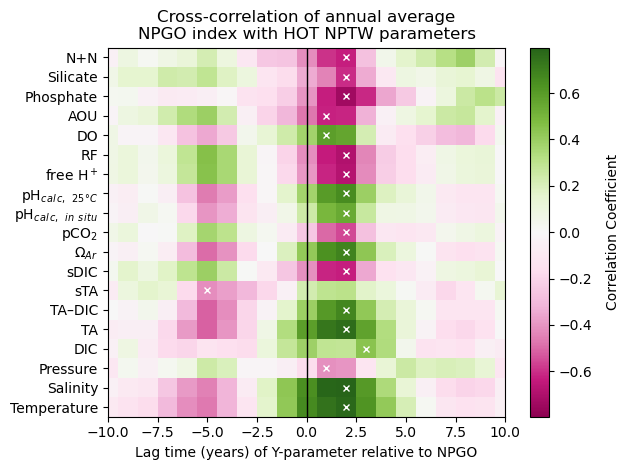

In [108]:
# Figure 8

Z = np.array(nptw_corrs)

x = nptw_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(nptw_maxlag))):
    ax.plot(nptw_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(nptw_corrs)), vmax=abs(np.amax(nptw_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to NPGO')
ax.set_title('Cross-correlation of annual average\nNPGO index with HOT NPTW parameters')

plt.tight_layout()
plt.savefig("LK_Fig8.png", dpi=500)

### SSM

In [109]:
# interpolate annual means
ssm_ddi_final = annual_interpolation(ssm_dd, usecols=usecols_lag, maxgap=2)

# calculate lags
ssm_lags, ssm_corrs, ssm_maxlag = lagged_correlation(ssm_ddi_final, usecols=usecols_lag, xcol='npgo')

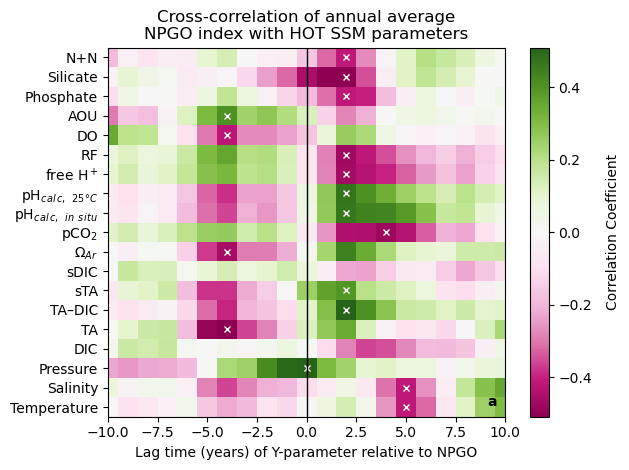

In [110]:
Z = np.array(ssm_corrs)

x = ssm_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(ssm_maxlag))):
    ax.plot(ssm_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(ssm_corrs)), vmax=abs(np.amax(ssm_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to NPGO')
ax.set_title('Cross-correlation of annual average\nNPGO index with HOT SSM parameters')
ax.text(0.98, 0.02, 'a', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3a.png", dpi=500)

### NPIW

In [111]:
# interpolate annual means
npiw_ddi_final = annual_interpolation(npiw_dd, usecols=usecols_lag, maxgap=2)

# calculate lags
npiw_lags, npiw_corrs, npiw_maxlag = lagged_correlation(npiw_ddi_final, usecols=usecols_lag, xcol='npgo')

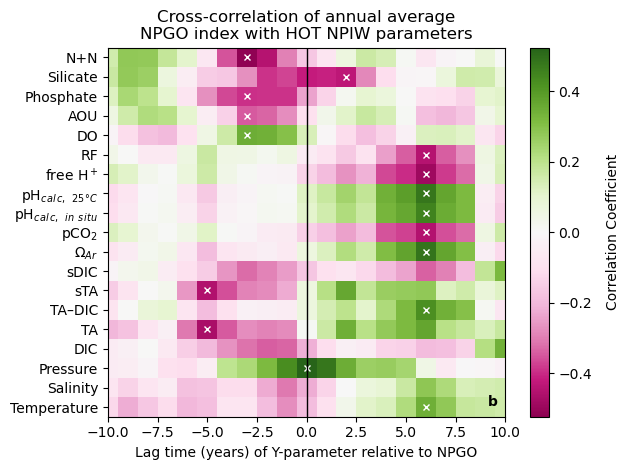

In [112]:
Z = np.array(npiw_corrs)

x = npiw_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(npiw_maxlag))):
    ax.plot(npiw_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(npiw_corrs)), vmax=abs(np.amax(npiw_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to NPGO')
ax.set_title('Cross-correlation of annual average\nNPGO index with HOT NPIW parameters')
ax.text(0.98, 0.02, 'b', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3b.png", dpi=500)

### AAIW

In [113]:
# interpolate annual means
aaiw_ddi_final = annual_interpolation(aaiw_dd, usecols=usecols_lag, maxgap=2)

# calculate lags
aaiw_lags, aaiw_corrs, aaiw_maxlag = lagged_correlation(aaiw_ddi_final, usecols=usecols_lag, xcol='npgo')

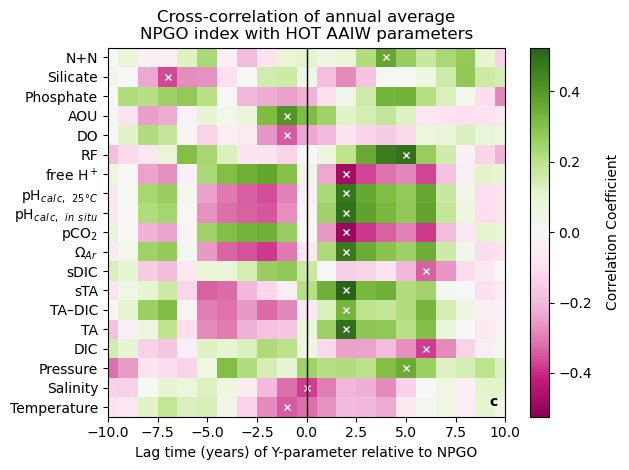

In [114]:
Z = np.array(aaiw_corrs)

x = aaiw_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(aaiw_maxlag))):
    ax.plot(aaiw_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(aaiw_corrs)), vmax=abs(np.amax(aaiw_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to NPGO')
ax.set_title('Cross-correlation of annual average\nNPGO index with HOT AAIW parameters')

ax.text(0.98, 0.02, 'c', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3c.png", dpi=500)

### Surface

In [115]:
# variables to plot – removing AOU and pressure for the surface
usecols_lag_surf = ['temp','csal','dic','alk','alk_dic','salk','sdic','OmegaARin','pCO2in',
               'pHin','pHout','Hfree','RFin','boxy','phos','sil']
plotting_names_lag_surf = ['Temperature','Salinity','DIC','TA','TA–DIC','sTA','sDIC','Ω$_A$$_r$','pCO$_2$',
                      'pH$_c$$_a$$_l$$_c$$_,$$_ $$_i$$_n$$_ $$_s$$_i$$_t$$_u$', 
                      'pH$_c$$_a$$_l$$_c$$_,$$_ $$_2$$_5$$_°$$_C$','free H$^+$','RF','DO', 
                      'Phosphate','Silicate']

In [116]:
# interpolate annual means
surf_ddi_final = annual_interpolation(surf_dd, usecols=usecols_lag_surf, maxgap=2)

# calculate lags
surf_lags, surf_corrs, surf_maxlag = lagged_correlation(surf_ddi_final, usecols=usecols_lag_surf, xcol='npgo')

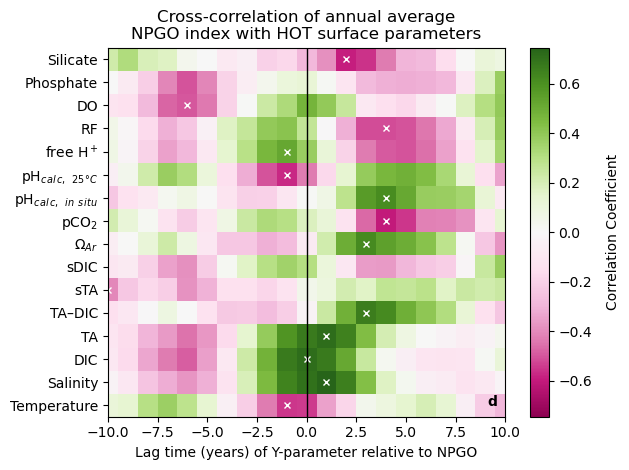

In [117]:
Z = np.array(surf_corrs)

x = surf_lags[1]
y = usecols_lag_surf

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag_surf, range(len(surf_maxlag))):
    ax.plot(surf_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag_surf)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(surf_corrs)), vmax=abs(np.amax(surf_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to NPGO')
ax.set_title('Cross-correlation of annual average\nNPGO index with HOT surface parameters')

ax.text(0.98, 0.02, 'd', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3d.png", dpi=500)

## Lagged Correlation: PDO

### Surface

In [118]:
# calculate lags
surf_lags, surf_corrs, surf_maxlag = lagged_correlation(surf_ddi_final, usecols=usecols_lag_surf, xcol='pdo')

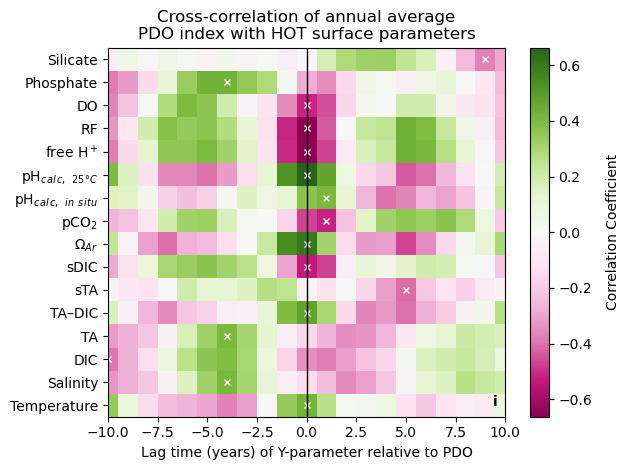

In [119]:
Z = np.array(surf_corrs)

x = surf_lags[1]
y = usecols_lag_surf

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag_surf, range(len(surf_maxlag))):
    ax.plot(surf_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag_surf)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(surf_corrs)), vmax=abs(np.amax(surf_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to PDO')
ax.set_title('Cross-correlation of annual average\nPDO index with HOT surface parameters')

ax.text(0.98, 0.02, 'i', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3i.png", dpi=500)

### NPTW

In [120]:
# calculate lags
nptw_lags, nptw_corrs, nptw_maxlag = lagged_correlation(nptw_ddi_final, usecols=usecols_lag, xcol='pdo')

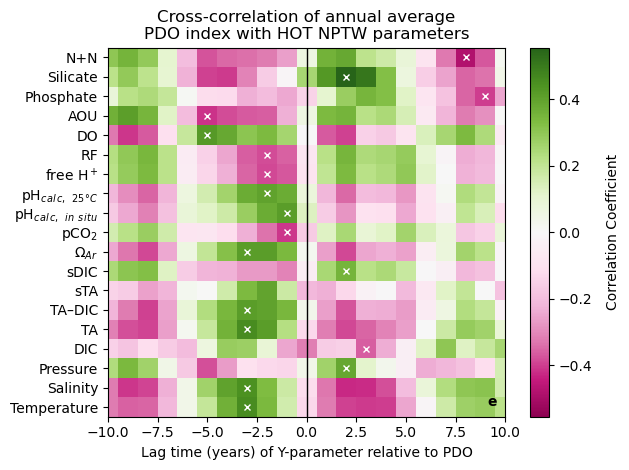

In [121]:
Z = np.array(nptw_corrs)

x = nptw_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(nptw_maxlag))):
    ax.plot(nptw_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(nptw_corrs)), vmax=abs(np.amax(nptw_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to PDO')
ax.set_title('Cross-correlation of annual average\nPDO index with HOT NPTW parameters')

ax.text(0.98, 0.02, 'e', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3e.png", dpi=500)

### SSM

In [122]:
# calculate lags
ssm_lags, ssm_corrs, ssm_maxlag = lagged_correlation(ssm_ddi_final, usecols=usecols_lag, xcol='pdo')

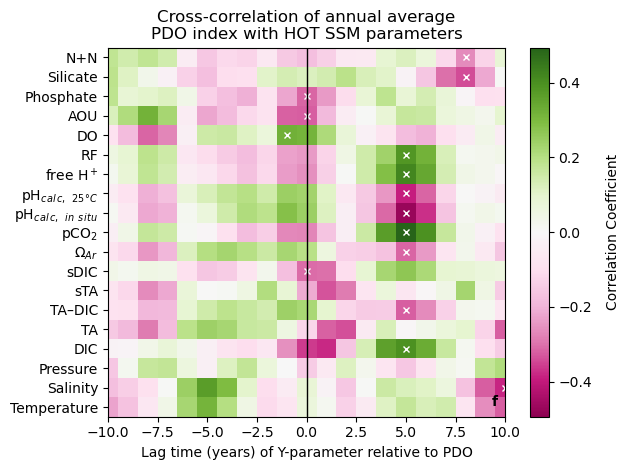

In [123]:
Z = np.array(ssm_corrs)

x = ssm_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(ssm_maxlag))):
    ax.plot(ssm_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(ssm_corrs)), vmax=abs(np.amax(ssm_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to PDO')
ax.set_title('Cross-correlation of annual average\nPDO index with HOT SSM parameters')

ax.text(0.98, 0.02, 'f', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3f.png", dpi=500)

### NPIW

In [124]:
# calculate lags
npiw_lags, npiw_corrs, npiw_maxlag = lagged_correlation(npiw_ddi_final, usecols=usecols_lag, xcol='pdo')

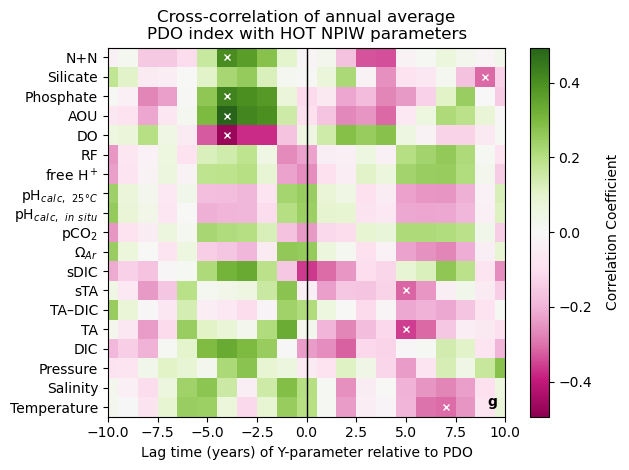

In [125]:
Z = np.array(npiw_corrs)

x = npiw_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(npiw_maxlag))):
    ax.plot(npiw_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(npiw_corrs)), vmax=abs(np.amax(npiw_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to PDO')
ax.set_title('Cross-correlation of annual average\nPDO index with HOT NPIW parameters')

ax.text(0.98, 0.02, 'g', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3g.png", dpi=500)

### AAIW

In [126]:
# calculate lags
aaiw_lags, aaiw_corrs, aaiw_maxlag = lagged_correlation(aaiw_ddi_final, usecols=usecols_lag, xcol='pdo')

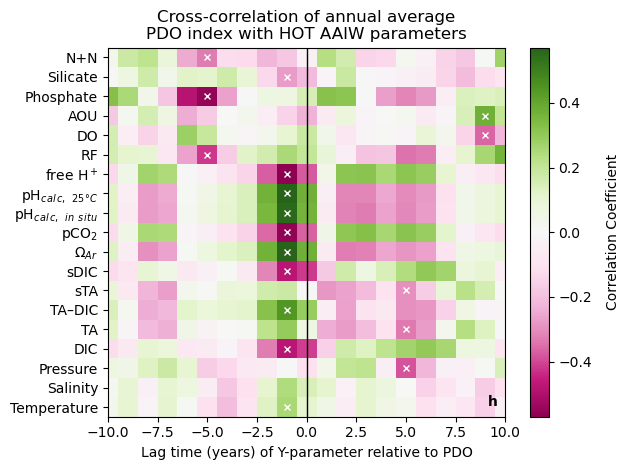

In [127]:
Z = np.array(aaiw_corrs)

x = aaiw_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(aaiw_maxlag))):
    ax.plot(aaiw_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(aaiw_corrs)), vmax=abs(np.amax(aaiw_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to PDO')
ax.set_title('Cross-correlation of annual average\nPDO index with HOT AAIW parameters')

ax.text(0.98, 0.02, 'h', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3h.png", dpi=500)

## Lagged Correlation: ENSO MEIv.2

### NPTW

In [128]:
# calculate lags
nptw_lags, nptw_corrs, nptw_maxlag = lagged_correlation(nptw_ddi_final, usecols=usecols_lag, xcol='enso')

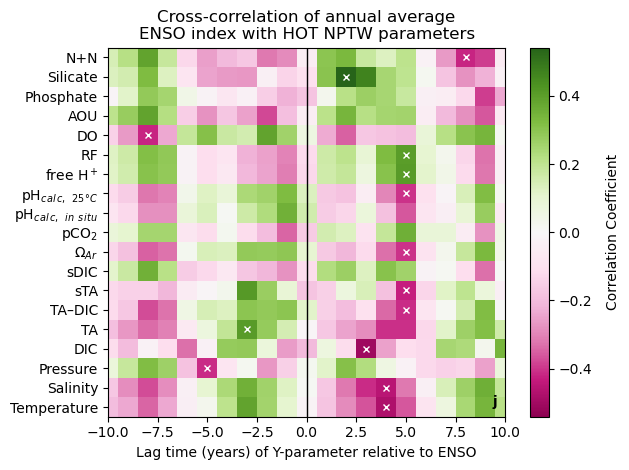

In [129]:
Z = np.array(nptw_corrs)

x = nptw_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(nptw_maxlag))):
    ax.plot(nptw_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(nptw_corrs)), vmax=abs(np.amax(nptw_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to ENSO')
ax.set_title('Cross-correlation of annual average\nENSO index with HOT NPTW parameters')

ax.text(0.98, 0.02, 'j', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3j.png", dpi=500)

### SSM

In [130]:
# calculate lags
ssm_lags, ssm_corrs, ssm_maxlag = lagged_correlation(ssm_ddi_final, usecols=usecols_lag, xcol='enso')

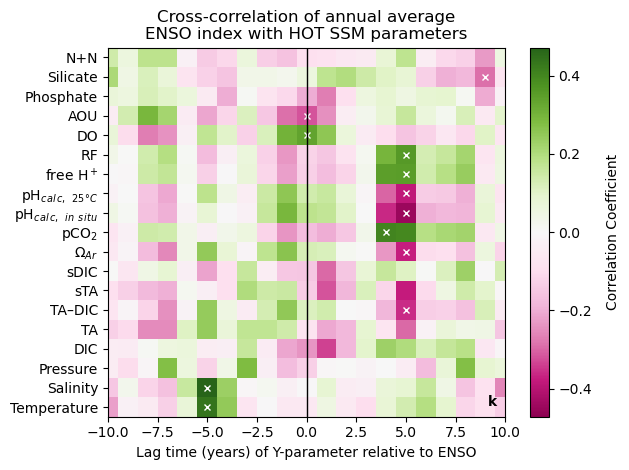

In [131]:
Z = np.array(ssm_corrs)

x = ssm_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(ssm_maxlag))):
    ax.plot(ssm_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(ssm_corrs)), vmax=abs(np.amax(ssm_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to ENSO')
ax.set_title('Cross-correlation of annual average\nENSO index with HOT SSM parameters')

ax.text(0.98, 0.02, 'k', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3k.png", dpi=500)

### NPIW

In [132]:
# calculate lags
npiw_lags, npiw_corrs, npiw_maxlag = lagged_correlation(npiw_ddi_final, usecols=usecols_lag, xcol='enso')

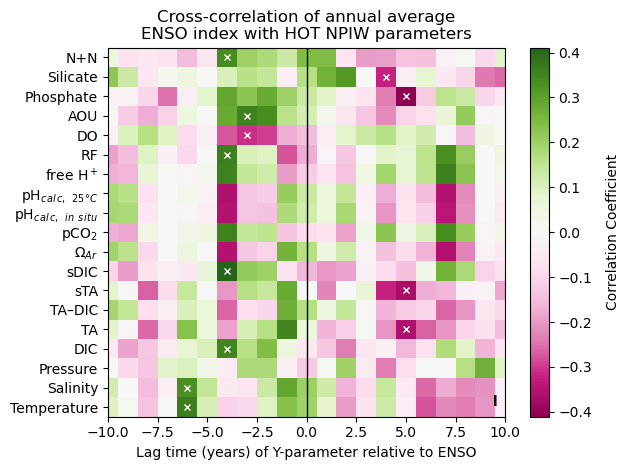

In [133]:
Z = np.array(npiw_corrs)

x = npiw_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(npiw_maxlag))):
    ax.plot(npiw_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(npiw_corrs)), vmax=abs(np.amax(npiw_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to ENSO')
ax.set_title('Cross-correlation of annual average\nENSO index with HOT NPIW parameters')

ax.text(0.98, 0.02, 'l', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3l.png", dpi=500)

### AAIW

In [134]:
# calculate lags
aaiw_lags, aaiw_corrs, aaiw_maxlag = lagged_correlation(aaiw_ddi_final, usecols=usecols_lag, xcol='enso')

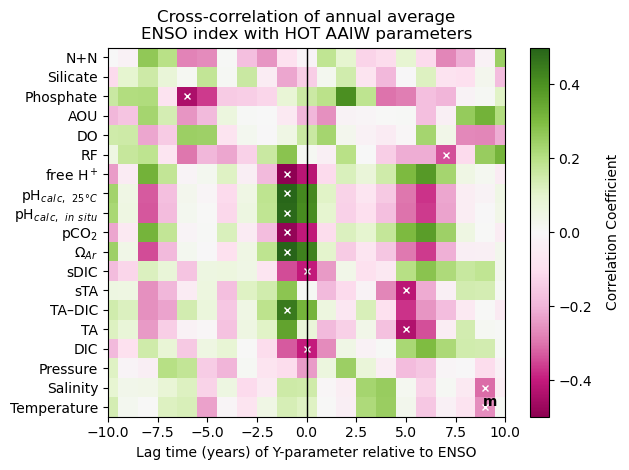

In [135]:
Z = np.array(aaiw_corrs)

x = aaiw_lags[1]
y = usecols_lag

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag, range(len(aaiw_maxlag))):
    ax.plot(aaiw_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(aaiw_corrs)), vmax=abs(np.amax(aaiw_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to ENSO')
ax.set_title('Cross-correlation of annual average\nENSO index with HOT AAIW parameters')

ax.text(0.98, 0.02, 'm', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3m.png", dpi=500)

### Surface

In [136]:
# calculate lags
surf_lags, surf_corrs, surf_maxlag = lagged_correlation(surf_ddi_final, usecols=usecols_lag_surf, xcol='enso')

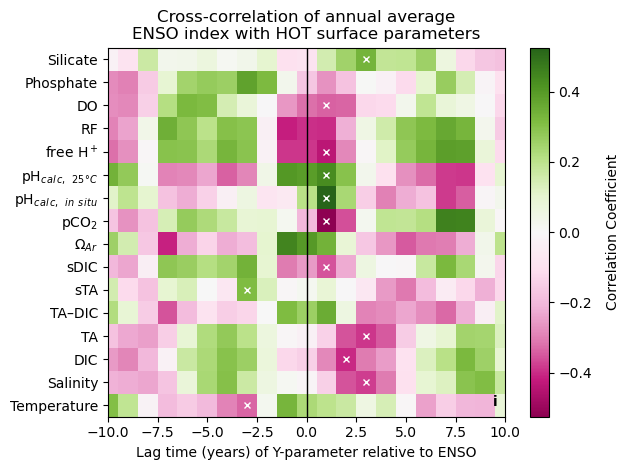

In [137]:
Z = np.array(surf_corrs)

x = surf_lags[1]
y = usecols_lag_surf

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x, y, Z, cmap=colors)

for column,i in zip(usecols_lag_surf, range(len(surf_maxlag))):
    ax.plot(surf_maxlag[i], column, 'x', color='white', markersize=5, linewidth=0)
    
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-10,10)
ax.set_yticks(y)  
ax.set_yticklabels(plotting_names_lag_surf)  


norm = mpl.colors.Normalize(vmin=-abs(np.amax(surf_corrs)), vmax=abs(np.amax(surf_corrs)))
mesh.set_norm(norm)

plt.colorbar(mesh).set_label('Correlation Coefficient', rotation=90, labelpad=10)

ax.set_xlabel('Lag time (years) of Y-parameter relative to ENSO')
ax.set_title('Cross-correlation of annual average\nENSO index with HOT surface parameters')

ax.text(0.98, 0.02, 'i', transform=ax.transAxes, fontsize=10, fontweight='bold',verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig("LK_FigS3n.png", dpi=500)

# Data Analysis: 2015-2020 Trends (Enhanced Acidification Period)

### Trend Decomposition with AOU, TA–DIC

In [138]:
## Compute trends up to 2015 ("pre") and between 2015-2020 ("post")

pre_trends_nptw, pre_slopes_nptw, pre_intercepts_nptw, pre_rs_nptw, pre_ps_nptw, pre_errs_nptw = trend(nptw_deseasoned[(nptw_deseasoned.index < pd.to_datetime('2015-01-01'))])
post_trends_nptw, post_slopes_nptw, post_intercepts_nptw, post_rs_nptw, post_ps_nptw, post_errs_nptw = trend(nptw_deseasoned[(nptw_deseasoned.index >= pd.to_datetime('2015-01-01')) & (nptw_deseasoned.index <= pd.to_datetime('2020-12-31'))])

pre_trends_surf, pre_slopes_surf, pre_intercepts_surf, pre_rs_surf, pre_ps_surf, pre_errs_surf = trend(surf_deseasoned[(surf_deseasoned.index < pd.to_datetime('2015-01-01'))])
post_trends_surf, post_slopes_surf, post_intercepts_surf, post_rs_surf, post_ps_surf, post_errs_surf = trend(surf_deseasoned[(surf_deseasoned.index >= pd.to_datetime('2015-01-01')) & (surf_deseasoned.index <= pd.to_datetime('2020-12-31'))])

pre_trends_ssm, pre_slopes_ssm, pre_intercepts_ssm, pre_rs_ssm, pre_ps_ssm, pre_errs_ssm = trend(ssm_deseasoned[(ssm_deseasoned.index < pd.to_datetime('2015-01-01'))])
post_trends_ssm, post_slopes_ssm, post_intercepts_ssm, post_rs_ssm, post_ps_ssm, post_errs_ssm = trend(ssm_deseasoned[(ssm_deseasoned.index >= pd.to_datetime('2015-01-01')) & (ssm_deseasoned.index <= pd.to_datetime('2020-12-31'))])

pre_trends_npiw, pre_slopes_npiw, pre_intercepts_npiw, pre_rs_npiw, pre_ps_npiw, pre_errs_npiw = trend(npiw_deseasoned[(npiw_deseasoned.index < pd.to_datetime('2015-01-01'))])
post_trends_npiw, post_slopes_npiw, post_intercepts_npiw, post_rs_npiw, post_ps_npiw, post_errs_npiw = trend(npiw_deseasoned[(npiw_deseasoned.index >= pd.to_datetime('2015-01-01')) & (npiw_deseasoned.index <= pd.to_datetime('2020-12-31'))])

pre_trends_aaiw, pre_slopes_aaiw, pre_intercepts_aaiw, pre_rs_aaiw, pre_ps_aaiw, pre_errs_aaiw = trend(aaiw_deseasoned[(aaiw_deseasoned.index < pd.to_datetime('2015-01-01'))])
post_trends_aaiw, post_slopes_aaiw, post_intercepts_aaiw, post_rs_aaiw, post_ps_aaiw, post_errs_aaiw = trend(aaiw_deseasoned[(aaiw_deseasoned.index >= pd.to_datetime('2015-01-01')) & (aaiw_deseasoned.index <= pd.to_datetime('2020-12-31'))])

In [139]:
## for "pre" period, create Dataframes with slopes and slope errors for each variable in each water mass (Table SXXX)

surf_slope_pre = pd.DataFrame([t[1] for t in pre_slopes_surf], index=[t[0] for t in pre_slopes_surf], columns=['surf_slope'])
surf_err_pre = pd.DataFrame([t[1] for t in pre_errs_surf], index=[t[0] for t in pre_errs_surf], columns=['surf_err'])

nptw_slope_pre = pd.DataFrame([t[1] for t in pre_slopes_nptw], index=[t[0] for t in pre_slopes_nptw], columns=['nptw_slope'])
nptw_err_pre = pd.DataFrame([t[1] for t in pre_errs_nptw], index=[t[0] for t in pre_errs_nptw], columns=['nptw_err'])

ssm_slope_pre = pd.DataFrame([t[1] for t in pre_slopes_ssm], index=[t[0] for t in pre_slopes_ssm], columns=['ssm_slope'])
ssm_err_pre = pd.DataFrame([t[1] for t in pre_errs_ssm], index=[t[0] for t in pre_errs_ssm], columns=['ssm_err'])

npiw_slope_pre = pd.DataFrame([t[1] for t in pre_slopes_npiw], index=[t[0] for t in pre_slopes_npiw], columns=['npiw_slope'])
npiw_err_pre = pd.DataFrame([t[1] for t in pre_errs_npiw], index=[t[0] for t in pre_errs_npiw], columns=['npiw_err'])

aaiw_slope_pre = pd.DataFrame([t[1] for t in pre_slopes_aaiw], index=[t[0] for t in pre_slopes_aaiw], columns=['aaiw_slope'])
aaiw_err_pre = pd.DataFrame([t[1] for t in pre_errs_aaiw], index=[t[0] for t in pre_errs_aaiw], columns=['aaiw_err'])

## Extract variables with significant slopes (p<0.005)
surf_sig_vars_pre = [t[0] for t in pre_ps_surf if t[1] < 0.005]
nptw_sig_vars_pre = [t[0] for t in pre_ps_nptw if t[1] < 0.005]
ssm_sig_vars_pre = [t[0] for t in pre_ps_ssm if t[1] < 0.005]
npiw_sig_vars_pre = [t[0] for t in pre_ps_npiw if t[1] < 0.005]
aaiw_sig_vars_pre = [t[0] for t in pre_ps_aaiw if t[1] < 0.005]

## Select only variables with significant slopes
surf_slope_pre = surf_slope_pre.loc[surf_sig_vars_pre].drop(['decimal_year', 'year'])
nptw_slope_pre = nptw_slope_pre.loc[nptw_sig_vars_pre].drop(['decimal_year','year'])
ssm_slope_pre = ssm_slope_pre.loc[ssm_sig_vars_pre].drop(['decimal_year','year'])
npiw_slope_pre = npiw_slope_pre.loc[npiw_sig_vars_pre].drop(['decimal_year','year'])
aaiw_slope_pre = aaiw_slope_pre.loc[aaiw_sig_vars_pre].drop(['decimal_year','year'])

## Select only variables with significant slopes
surf_err_pre = surf_err_pre.loc[surf_sig_vars_pre].drop(['decimal_year', 'year'])
nptw_err_pre = nptw_err_pre.loc[nptw_sig_vars_pre].drop(['decimal_year','year'])
ssm_err_pre = ssm_err_pre.loc[ssm_sig_vars_pre].drop(['decimal_year','year'])
npiw_err_pre = npiw_err_pre.loc[npiw_sig_vars_pre].drop(['decimal_year','year'])
aaiw_err_pre = aaiw_err_pre.loc[aaiw_sig_vars_pre].drop(['decimal_year','year'])

## Create DataFrame with significant slopes for all water masses – values in Table SI

all_slopes_pre = surf_slope_pre.merge(nptw_slope_pre, left_index=True, right_index = True, how='outer').merge(ssm_slope_pre, left_index=True, right_index = True, how='outer').merge(npiw_slope_pre, left_index=True, right_index = True, how='outer').merge(aaiw_slope_pre, left_index=True, right_index = True, how='outer')
all_slopes_pre = all_slopes_pre.transpose()
export = all_slopes_pre.to_csv('LK_TableSI_significant_trends_1988-2015.csv')

## Create DataFrame with slope errors for all water masses – uncertainty in Table SI

all_errs_pre = surf_err_pre.merge(nptw_err_pre, left_index=True, right_index = True, how='outer').merge(ssm_err_pre, left_index=True, right_index = True, how='outer').merge(npiw_err_pre, left_index=True, right_index = True, how='outer').merge(aaiw_err_pre, left_index=True, right_index = True, how='outer')
all_errs_pre = all_errs_pre.transpose()
export = all_errs_pre.to_csv('LK_TableSI_slope_errors_1988-2015.csv')

In [140]:
## for "post" period, create Dataframes with slopes and slope errors for each variable in each water mass (Table SXXX)

surf_slope_post = pd.DataFrame([t[1] for t in post_slopes_surf], index=[t[0] for t in post_slopes_surf], columns=['surf_slope'])
surf_err_post = pd.DataFrame([t[1] for t in post_errs_surf], index=[t[0] for t in post_errs_surf], columns=['surf_err'])

nptw_slope_post = pd.DataFrame([t[1] for t in post_slopes_nptw], index=[t[0] for t in post_slopes_nptw], columns=['nptw_slope'])
nptw_err_post = pd.DataFrame([t[1] for t in post_errs_nptw], index=[t[0] for t in post_errs_nptw], columns=['nptw_err'])

ssm_slope_post = pd.DataFrame([t[1] for t in post_slopes_ssm], index=[t[0] for t in post_slopes_ssm], columns=['ssm_slope'])
ssm_err_post = pd.DataFrame([t[1] for t in post_errs_ssm], index=[t[0] for t in post_errs_ssm], columns=['ssm_err'])

npiw_slope_post = pd.DataFrame([t[1] for t in post_slopes_npiw], index=[t[0] for t in post_slopes_npiw], columns=['npiw_slope'])
npiw_err_post = pd.DataFrame([t[1] for t in post_errs_npiw], index=[t[0] for t in post_errs_npiw], columns=['npiw_err'])

aaiw_slope_post = pd.DataFrame([t[1] for t in post_slopes_aaiw], index=[t[0] for t in post_slopes_aaiw], columns=['aaiw_slope'])
aaiw_err_post = pd.DataFrame([t[1] for t in post_errs_aaiw], index=[t[0] for t in post_errs_aaiw], columns=['aaiw_err'])

## Extract variables with significant slopes (p<0.005)
surf_sig_vars_post = [t[0] for t in post_ps_surf if t[1] < 0.005]
nptw_sig_vars_post = [t[0] for t in post_ps_nptw if t[1] < 0.005]
ssm_sig_vars_post = [t[0] for t in post_ps_ssm if t[1] < 0.005]
npiw_sig_vars_post = [t[0] for t in post_ps_npiw if t[1] < 0.005]
aaiw_sig_vars_post = [t[0] for t in post_ps_aaiw if t[1] < 0.005]

## Select only variables with significant slopes
surf_slope_post = surf_slope_post.loc[surf_sig_vars_post].drop(['decimal_year', 'year'])
nptw_slope_post = nptw_slope_post.loc[nptw_sig_vars_post].drop(['decimal_year','year'])
ssm_slope_post = ssm_slope_post.loc[ssm_sig_vars_post].drop(['decimal_year','year'])
npiw_slope_post = npiw_slope_post.loc[npiw_sig_vars_post].drop(['decimal_year','year'])
aaiw_slope_post = aaiw_slope_post.loc[aaiw_sig_vars_post].drop(['decimal_year','year'])

## Select only variables with significant slopes
surf_err_post = surf_err_post.loc[surf_sig_vars_post].drop(['decimal_year', 'year'])
nptw_err_post = nptw_err_post.loc[nptw_sig_vars_post].drop(['decimal_year','year'])
ssm_err_post = ssm_err_post.loc[ssm_sig_vars_post].drop(['decimal_year','year'])
npiw_err_post = npiw_err_post.loc[npiw_sig_vars_post].drop(['decimal_year','year'])
aaiw_err_post = aaiw_err_post.loc[aaiw_sig_vars_post].drop(['decimal_year','year'])

## Create DataFrame with significant slopes for all water masses – values in Table SI

all_slopes_post = surf_slope_post.merge(nptw_slope_post, left_index=True, right_index = True, how='outer').merge(ssm_slope_post, left_index=True, right_index = True, how='outer').merge(npiw_slope_post, left_index=True, right_index = True, how='outer').merge(aaiw_slope_post, left_index=True, right_index = True, how='outer')
all_slopes_post = all_slopes_post.transpose()
export = all_slopes_post.to_csv('LK_TableSI_significant_trends_2015-2020.csv')

## Create DataFrame with slope errors for all water masses – uncertainty in Table SI

all_errs_post = surf_err_post.merge(nptw_err_post, left_index=True, right_index = True, how='outer').merge(ssm_err_post, left_index=True, right_index = True, how='outer').merge(npiw_err_post, left_index=True, right_index = True, how='outer').merge(aaiw_err_post, left_index=True, right_index = True, how='outer')
all_errs_post = all_errs_post.transpose()
export = all_errs_post.to_csv('LK_TableSI_slope_errors_2015-2020.csv')

### Figure 2 & 3

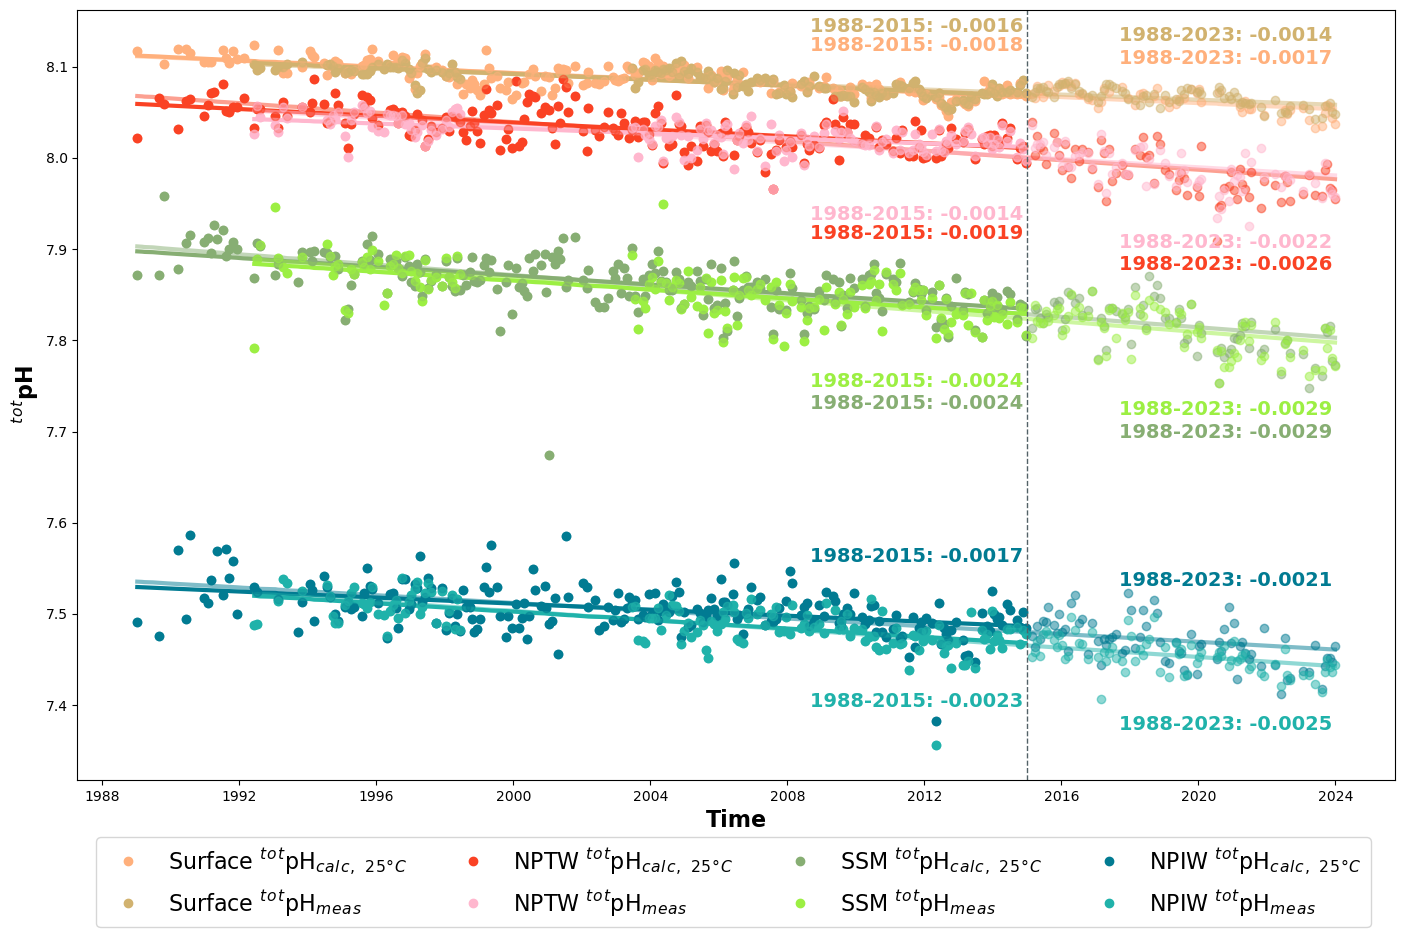

In [141]:
# Figure 2

fig, ax = plt.subplots(1, figsize=(17,10))

# cruise averages, full color (up to 2015)
ax.plot(surf_deseasoned[surf_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        surf_deseasoned[surf_deseasoned.index < pd.to_datetime('2015-01-01')].pHout, 
        'o', color='xkcd:peach')

ax.plot(surf_deseasoned[surf_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        surf_deseasoned[surf_deseasoned.index < pd.to_datetime('2015-01-01')].ph, 
        'o', color='xkcd:tan')

ax.plot(nptw_deseasoned[nptw_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        nptw_deseasoned[nptw_deseasoned.index < pd.to_datetime('2015-01-01')].pHout, 
        'o', color='xkcd:orangey red')

ax.plot(nptw_deseasoned[nptw_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        nptw_deseasoned[nptw_deseasoned.index < pd.to_datetime('2015-01-01')].ph, 
        'o', color='xkcd:baby pink')

ax.plot(ssm_deseasoned[ssm_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        ssm_deseasoned[ssm_deseasoned.index < pd.to_datetime('2015-01-01')].pHout, 
        'o', color='xkcd:sage')

ax.plot(ssm_deseasoned[ssm_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        ssm_deseasoned[ssm_deseasoned.index < pd.to_datetime('2015-01-01')].ph, 
        'o', color='xkcd:kiwi')

ax.plot(npiw_deseasoned[npiw_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        npiw_deseasoned[npiw_deseasoned.index < pd.to_datetime('2015-01-01')].pHout, 
        'o', color='xkcd:ocean')

ax.plot(npiw_deseasoned[npiw_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        npiw_deseasoned[npiw_deseasoned.index < pd.to_datetime('2015-01-01')].ph, 
        'o', color='lightseagreen')

## Trend lines: Full time series and up to 2015

# Surface
ax.plot(surf_trends.interpolate().index, surf_trends.interpolate().pHout, linewidth=3,
       color='xkcd:peach', alpha=0.5)

ax.plot(pre_trends_surf.interpolate().index, pre_trends_surf.interpolate().pHout,linewidth=3,
       color='xkcd:peach')

ax.plot(surf_trends.interpolate().index, surf_trends.interpolate().ph, linewidth=3,
       color='xkcd:tan', alpha=0.5)

ax.plot(pre_trends_surf.interpolate().index, pre_trends_surf.interpolate().ph,linewidth=3,
       color='xkcd:tan')

# NPTW
ax.plot(nptw_trends.interpolate().index, nptw_trends.interpolate().pHout,linewidth=3,
       color='xkcd:orangey red', alpha=0.5)

ax.plot(pre_trends_nptw.interpolate().index, pre_trends_nptw.interpolate().pHout,linewidth=3,
       color='xkcd:orangey red')

ax.plot(nptw_trends.interpolate().index, nptw_trends.interpolate().ph,linewidth=3,
       color='xkcd:baby pink', alpha=0.5)

ax.plot(pre_trends_nptw.interpolate().index, pre_trends_nptw.interpolate().ph,linewidth=3,
       color='xkcd:baby pink')

# SSM
ax.plot(ssm_trends.interpolate().index, ssm_trends.interpolate().pHout,linewidth=3,
       color='xkcd:sage', alpha=0.5)

ax.plot(pre_trends_ssm.interpolate().index, pre_trends_ssm.interpolate().pHout,linewidth=3,
       color='xkcd:sage')

ax.plot(ssm_trends.interpolate().index, ssm_trends.interpolate().ph,linewidth=3,
       color='xkcd:kiwi', alpha=0.5)

ax.plot(pre_trends_ssm.interpolate().index, pre_trends_ssm.interpolate().ph,linewidth=3,
       color='xkcd:kiwi')

# NPIW

ax.plot(npiw_trends.interpolate().index, npiw_trends.interpolate().pHout,linewidth=3,
       color='xkcd:ocean', alpha=0.5)

ax.plot(pre_trends_npiw.interpolate().index, pre_trends_npiw.interpolate().pHout,linewidth=3,
       color='xkcd:ocean')

ax.plot(npiw_trends.interpolate().index, npiw_trends.interpolate().ph,linewidth=3,
       color='lightseagreen', alpha=0.5)

ax.plot(pre_trends_npiw.interpolate().index, pre_trends_npiw.interpolate().ph,linewidth=3,
       color='lightseagreen')

# Full time series cruise averages  - reduced brightness 
ax.plot(surf_deseasoned.index, 
        surf_deseasoned.pHout, 
        'o', color='xkcd:peach', alpha=0.5)

ax.plot(surf_deseasoned.index, 
        surf_deseasoned.ph, 
        'o', color='xkcd:tan', alpha=0.5)

ax.plot(nptw_deseasoned.index, 
        nptw_deseasoned.pHout, 
        'o', color='xkcd:orangey red', alpha=0.5)

ax.plot(nptw_deseasoned.index, 
        nptw_deseasoned.ph, 
        'o', color='xkcd:baby pink', alpha=0.5)

ax.plot(ssm_deseasoned.index, 
        ssm_deseasoned.pHout, 
        'o', color='xkcd:sage', alpha=0.5)

ax.plot(ssm_deseasoned.index, 
        ssm_deseasoned.ph, 
        'o', color='xkcd:kiwi', alpha=0.5)

ax.plot(npiw_deseasoned.index, 
        npiw_deseasoned.pHout, 
        'o', color='xkcd:ocean', alpha=0.5)

ax.plot(npiw_deseasoned.index, 
        npiw_deseasoned.ph, 
        'o', color='lightseagreen', alpha=0.5)

# Adding slope labels for each category (pHcalc and pHmeas)

# Surface
add_slope_label(ax, surf_trends.interpolate().pHout, 'xkcd:peach', 
                f'1988-2023: {surf_slopes[28][1]:.4f} ', y_offset=+0.05)
add_slope_label(ax, pre_trends_surf.interpolate().pHout, 'xkcd:peach', 
                f'1988-2015: {pre_slopes_surf[28][1]:.4f} ', y_offset=+0.05)

add_slope_label(ax, surf_trends.interpolate().ph, 'xkcd:tan', 
                f'1988-2023: {surf_slopes[8][1]:.4f} ', y_offset=+0.07)
add_slope_label(ax, pre_trends_surf.interpolate().ph, 'xkcd:tan', 
                f'1988-2015: {pre_slopes_surf[8][1]:.4f} ', y_offset=+0.07)

# NPTW
add_slope_label(ax, nptw_trends.interpolate().pHout, 'xkcd:orangey red', 
                f'1988-2023: {nptw_slopes[28][1]:.4f} ', y_offset=-0.1)
add_slope_label(ax, pre_trends_nptw.interpolate().pHout, 'xkcd:orangey red', 
                f'1988-2015: {pre_slopes_nptw[28][1]:.4f} ', y_offset=-0.1)

add_slope_label(ax, nptw_trends.interpolate().ph, 'xkcd:baby pink', 
                f'1988-2023: {nptw_slopes[8][1]:.4f} ', y_offset=-0.08)
add_slope_label(ax, pre_trends_nptw.interpolate().ph, 'xkcd:baby pink', 
                f'1988-2015: {pre_slopes_nptw[8][1]:.4f} ', y_offset=-0.08)

# SSM
add_slope_label(ax, ssm_trends.interpolate().pHout, 'xkcd:sage', 
                f'1988-2023: {ssm_slopes[28][1]:.4f} ', y_offset=-0.11)
add_slope_label(ax, pre_trends_ssm.interpolate().pHout, 'xkcd:sage', 
                f'1988-2015: {pre_slopes_ssm[28][1]:.4f} ', y_offset=-0.11)

add_slope_label(ax, ssm_trends.interpolate().ph, 'xkcd:kiwi', 
                f'1988-2023: {ssm_slopes[8][1]:.4f} ', y_offset=-0.08)
add_slope_label(ax, pre_trends_ssm.interpolate().ph, 'xkcd:kiwi', 
                f'1988-2015: {pre_slopes_ssm[8][1]:.4f} ', y_offset=-0.08)

# NPIW
add_slope_label(ax, npiw_trends.interpolate().pHout, 'xkcd:ocean', 
                f'1988-2023: {npiw_slopes[26][1]:.4f} ', y_offset=+0.07)
add_slope_label(ax, pre_trends_npiw.interpolate().pHout, 'xkcd:ocean', 
                f'1988-2015: {pre_slopes_npiw[26][1]:.4f} ', y_offset=+0.07)

add_slope_label(ax, npiw_trends.interpolate().ph, 'lightseagreen', 
                f'1988-2023: {npiw_slopes[8][1]:.4f} ', y_offset=-0.07)
add_slope_label(ax, pre_trends_npiw.interpolate().ph, 'lightseagreen', 
                f'1988-2015: {pre_slopes_npiw[8][1]:.4f} ', y_offset=-0.07)


ax.legend(['Surface $^t$$^o$$^t$pH$_c$$_a$$_l$$_c$$_,$$_ $$_2$$_5$$_°$$_C$', 
           'Surface $^t$$^o$$^t$pH$_m$$_e$$_a$$_s$', 
         'NPTW $^t$$^o$$^t$pH$_c$$_a$$_l$$_c$$_,$$_ $$_2$$_5$$_°$$_C$', 
           'NPTW $^t$$^o$$^t$pH$_m$$_e$$_a$$_s$', 
         'SSM $^t$$^o$$^t$pH$_c$$_a$$_l$$_c$$_,$$_ $$_2$$_5$$_°$$_C$', 
           'SSM $^t$$^o$$^t$pH$_m$$_e$$_a$$_s$',
            'NPIW $^t$$^o$$^t$pH$_c$$_a$$_l$$_c$$_,$$_ $$_2$$_5$$_°$$_C$', 
           'NPIW $^t$$^o$$^t$pH$_m$$_e$$_a$$_s$',
          ], bbox_to_anchor=(0.99, -0.06), fontsize=16, ncols=4)

ax.axvline(pd.to_datetime('2015-01-01'), color='xkcd:gunmetal', linewidth=1, linestyle='--')
ax.set_xlabel('Time', fontsize=16, fontweight='bold')

ax.set_ylabel('$^t$$^o$$^t$pH', fontsize=16, fontweight='bold')
plt.savefig('LK_Fig2.png', bbox_inches='tight', dpi=500)

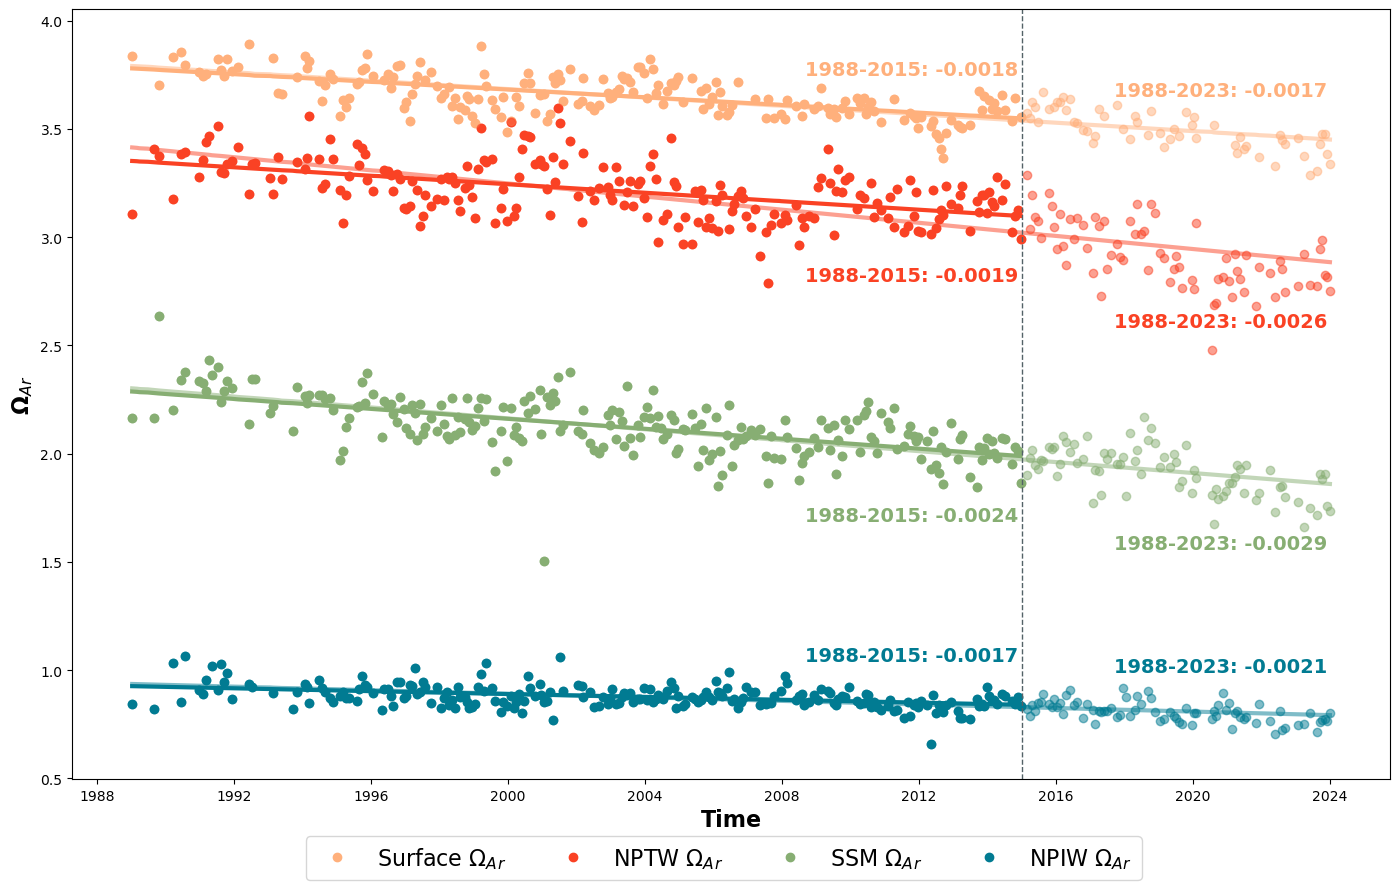

In [142]:
# Figure 3

fig, ax = plt.subplots(1, figsize=(17,10))

# cruise averages, full color (up to 2015)
ax.plot(surf_deseasoned[surf_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        surf_deseasoned[surf_deseasoned.index < pd.to_datetime('2015-01-01')].OmegaARin, 
        'o', color='xkcd:peach')


ax.plot(nptw_deseasoned[nptw_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        nptw_deseasoned[nptw_deseasoned.index < pd.to_datetime('2015-01-01')].OmegaARin, 
        'o', color='xkcd:orangey red')


ax.plot(ssm_deseasoned[ssm_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        ssm_deseasoned[ssm_deseasoned.index < pd.to_datetime('2015-01-01')].OmegaARin, 
        'o', color='xkcd:sage')

ax.plot(npiw_deseasoned[npiw_deseasoned.index < pd.to_datetime('2015-01-01')].index, 
        npiw_deseasoned[npiw_deseasoned.index < pd.to_datetime('2015-01-01')].OmegaARin, 
        'o', color='xkcd:ocean')


## Trend lines: Full time series and up to 2015

# Surface
ax.plot(surf_trends.interpolate().index, surf_trends.interpolate().OmegaARin, linewidth=3,
       color='xkcd:peach', alpha=0.5)

ax.plot(pre_trends_surf.interpolate().index, pre_trends_surf.interpolate().OmegaARin,linewidth=3,
       color='xkcd:peach')


# NPTW
ax.plot(nptw_trends.interpolate().index, nptw_trends.interpolate().OmegaARin,linewidth=3,
       color='xkcd:orangey red', alpha=0.5)

ax.plot(pre_trends_nptw.interpolate().index, pre_trends_nptw.interpolate().OmegaARin,linewidth=3,
       color='xkcd:orangey red')


# SSM
ax.plot(ssm_trends.interpolate().index, ssm_trends.interpolate().OmegaARin,linewidth=3,
       color='xkcd:sage', alpha=0.5)

ax.plot(pre_trends_ssm.interpolate().index, pre_trends_ssm.interpolate().OmegaARin,linewidth=3,
       color='xkcd:sage')

# NPIW

ax.plot(npiw_trends.interpolate().index, npiw_trends.interpolate().OmegaARin,linewidth=3,
       color='xkcd:ocean', alpha=0.5)

ax.plot(pre_trends_npiw.interpolate().index, pre_trends_npiw.interpolate().OmegaARin,linewidth=3,
       color='xkcd:ocean')


# Full time series cruise averages  - reduced brightness 
ax.plot(surf_deseasoned.index, 
        surf_deseasoned.OmegaARin, 
        'o', color='xkcd:peach', alpha=0.5)

ax.plot(nptw_deseasoned.index, 
        nptw_deseasoned.OmegaARin, 
        'o', color='xkcd:orangey red', alpha=0.5)

ax.plot(ssm_deseasoned.index, 
        ssm_deseasoned.OmegaARin, 
        'o', color='xkcd:sage', alpha=0.5)

ax.plot(npiw_deseasoned.index, 
        npiw_deseasoned.OmegaARin, 
        'o', color='xkcd:ocean', alpha=0.5)


# Adding slope labels 

# Surface
add_slope_label(ax, surf_trends.interpolate().OmegaARin, 'xkcd:peach', 
                f'1988-2023: {surf_slopes[28][1]:.4f} ', y_offset=+0.2)
add_slope_label(ax, pre_trends_surf.interpolate().OmegaARin, 'xkcd:peach', 
                f'1988-2015: {pre_slopes_surf[28][1]:.4f} ', y_offset=+0.2)

# NPTW
add_slope_label(ax, nptw_trends.interpolate().OmegaARin, 'xkcd:orangey red', 
                f'1988-2023: {nptw_slopes[28][1]:.4f} ', y_offset=-0.3)
add_slope_label(ax, pre_trends_nptw.interpolate().OmegaARin, 'xkcd:orangey red', 
                f'1988-2015: {pre_slopes_nptw[28][1]:.4f} ', y_offset=-0.3)

# SSM
add_slope_label(ax, ssm_trends.interpolate().OmegaARin, 'xkcd:sage', 
                f'1988-2023: {ssm_slopes[28][1]:.4f} ', y_offset=-0.3)
add_slope_label(ax, pre_trends_ssm.interpolate().OmegaARin, 'xkcd:sage', 
                f'1988-2015: {pre_slopes_ssm[28][1]:.4f} ', y_offset=-0.3)

# NPIW
add_slope_label(ax, npiw_trends.interpolate().OmegaARin, 'xkcd:ocean', 
                f'1988-2023: {npiw_slopes[26][1]:.4f} ', y_offset=+0.2)
add_slope_label(ax, pre_trends_npiw.interpolate().OmegaARin, 'xkcd:ocean', 
                f'1988-2015: {pre_slopes_npiw[26][1]:.4f} ', y_offset=+0.2)


ax.legend(['Surface Ω$_A$$_r$', 'NPTW Ω$_A$$_r$', 'SSM Ω$_A$$_r$', 'NPIW Ω$_A$$_r$'
          ], bbox_to_anchor=(0.82, -0.06), fontsize=16, ncols=4)

ax.axvline(pd.to_datetime('2015-01-01'), color='xkcd:gunmetal', linewidth=1, linestyle='--')
ax.set_xlabel('Time', fontsize=16, fontweight='bold')

ax.set_ylabel('Ω$_A$$_r$', fontsize=16, fontweight='bold')
plt.savefig('LK_Fig3.png', bbox_inches='tight', dpi=500)

### Figure 9

In [143]:
# check that we are calling the correct values for slopes and r values
nptw_deseasoned_slopes[11]

('alk_dic', -1.4537112315167287)

In [144]:
ssm_deseasoned_slopes[11]

('alk_dic', -1.3750369967825493)

In [145]:
npiw_deseasoned_slopes[11]

('alk_dic', -0.7124183256196328)

In [146]:
post_rs_nptw[16]

('aou', 0.590531664154218)

In [147]:
post_rs_ssm[16]

('aou', 0.24466477177637505)

In [148]:
post_rs_npiw[16]

('aou', 0.07969981226311584)

/var/folders/nj/szt8lwtn2rb8rksl6pt521wh0000gp/T/ipykernel_4973/1602203981.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atm_line = -0.84 * nptw_deseasoned_trends[nptw_deseasoned_trends['alk_dic'] >0]['decimal_year'] + nptw_deseasoned_trends[nptw_deseasoned_trends.index == pd.to_datetime('1989-01-08 14:36:37')]['alk_dic'][0] - (-0.84 * nptw_deseasoned_trends[nptw_deseasoned_trends['alk_dic'] >0]['decimal_year'][0])
/var/folders/nj/szt8lwtn2rb8rksl6pt521wh0000gp/T/ipykernel_4973/1602203981.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atm_line = -0.84 * ssm_deseasoned_trends[ssm_deseasoned_trends['alk_di

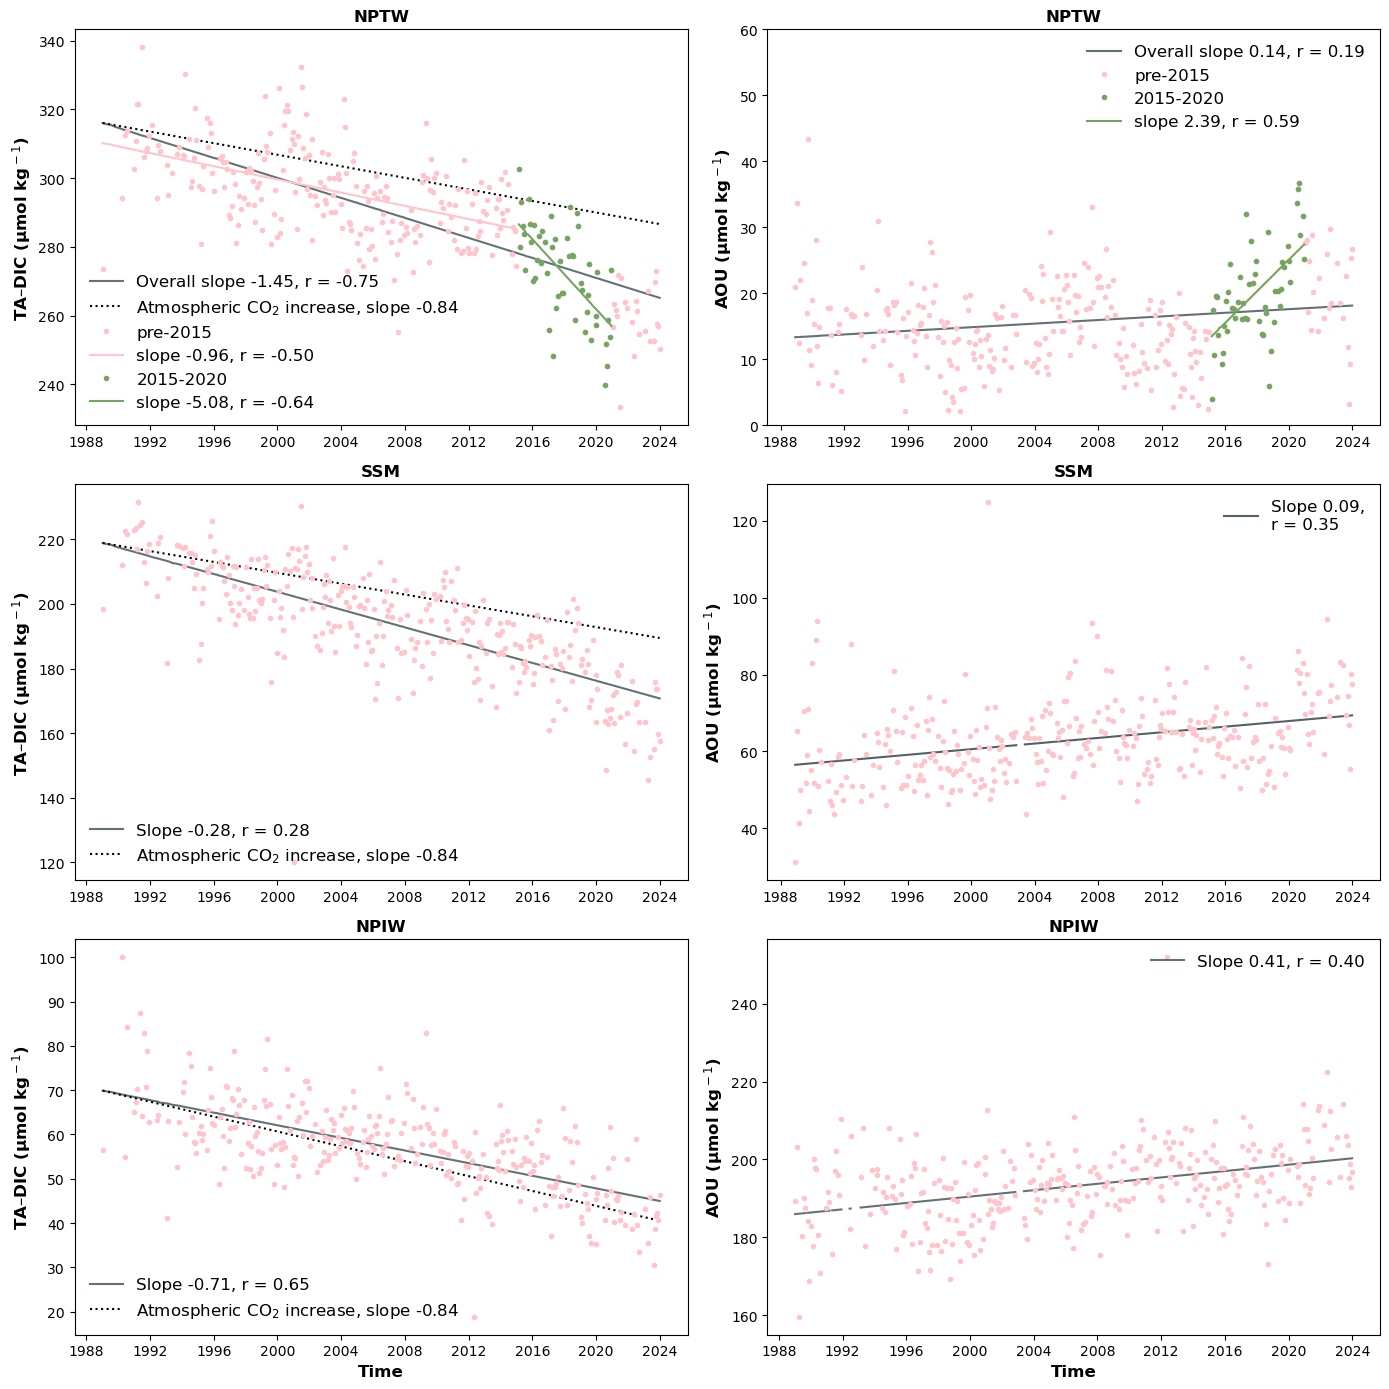

In [149]:
fig, axs = plt.subplots(3, 2, figsize=(14,14))

# Flatten the 2D array of axes for easier indexing
axs = axs.flatten()

## NPTW TA–DIC
ax = axs[0]

ax.plot(nptw_deseasoned_trends['alk_dic'].interpolate(), color='xkcd:gunmetal', alpha=0.9)

atm_line = -0.84 * nptw_deseasoned_trends[nptw_deseasoned_trends['alk_dic'] >0]['decimal_year'] + nptw_deseasoned_trends[nptw_deseasoned_trends.index == pd.to_datetime('1989-01-08 14:36:37')]['alk_dic'][0] - (-0.84 * nptw_deseasoned_trends[nptw_deseasoned_trends['alk_dic'] >0]['decimal_year'][0])
ax.plot(nptw_deseasoned_trends[nptw_deseasoned_trends['alk_dic'] >0].interpolate().index, 
        atm_line.interpolate(), color='black', linestyle='dotted')

ax.plot(nptw_deseasoned.index, nptw_deseasoned['alk_dic'], '.', color='xkcd:light rose')
ax.plot(pre_trends_nptw['alk_dic'].interpolate(), color='xkcd:light rose')

ax.plot(nptw_deseasoned[(nptw_deseasoned.index >= pd.to_datetime('2015-01-01')) & (nptw_deseasoned.index <= pd.to_datetime('2020-12-31'))].index, 
        nptw_deseasoned[(nptw_deseasoned.index >= pd.to_datetime('2015-01-01')) & (nptw_deseasoned.index <= pd.to_datetime('2020-12-31'))]['alk_dic'], 
        '.', color='xkcd:dull green')
ax.plot(post_trends_nptw['alk_dic'].interpolate(), color='xkcd:dull green')

ax.legend([f'Overall slope {nptw_deseasoned_slopes[11][1]:.2f}, r = {nptw_deseasoned_rs[11][1]:.2f}', 
           'Atmospheric CO$_2$ increase, slope -0.84',
           'pre-2015', f'slope {pre_slopes_nptw[11][1]:.2f}, r = {pre_rs_nptw[11][1]:.2f}', 
           '2015-2020',f'slope {post_slopes_nptw[11][1]:.2f}, r = {post_rs_nptw[11][1]:.2f}', 
          ], loc='lower left', fontsize=12, frameon=False)
ax.set_ylabel('TA–DIC (µmol kg$^-$$^1$)', fontsize=12, fontweight='bold')
#ax.set_xlabel('Time')
ax.set_title('NPTW', fontsize=12, fontweight='bold')

## NPTW AOU
ax = axs[1]

ax.plot(nptw_deseasoned_trends['aou'].interpolate(), color='xkcd:gunmetal', alpha=0.9)

ax.plot(nptw_deseasoned.index, nptw_deseasoned['aou'], '.', color='xkcd:light rose')
#ax.plot(pre_trends_nptw['aou'].interpolate(), color='xkcd:light rose')

ax.plot(nptw_deseasoned[(nptw_deseasoned.index >= pd.to_datetime('2015-01-01')) & (nptw_deseasoned.index <= pd.to_datetime('2020-12-31'))].index, 
        nptw_deseasoned[(nptw_deseasoned.index >= pd.to_datetime('2015-01-01')) & (nptw_deseasoned.index <= pd.to_datetime('2020-12-31'))]['aou'], 
        '.', color='xkcd:dull green')
ax.plot(post_trends_nptw['aou'].interpolate(), color='xkcd:dull green')

ax.legend([f'Overall slope {nptw_deseasoned_slopes[16][1]:.2f}, r = {abs(nptw_deseasoned_rs[16][1]):.2f}', 
           'pre-2015', #f'slope {pre_slopes_nptw[17][1]:.2f}, r = {pre_rs_nptw[22][1]:.2f}', 
           '2015-2020',f'slope {post_slopes_nptw[16][1]:.2f}, r = {abs(post_rs_nptw[16][1]):.2f}', 
          ], fontsize=12, loc='upper right', frameon=False)
ax.set_ylim(0,60)
ax.set_ylabel('AOU (µmol kg$^-$$^1$)', fontsize=12, fontweight='bold')
#ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_title('NPTW', fontsize=12, fontweight='bold')

## SSM TA–DIC
ax = axs[2]

ax.plot(ssm_deseasoned_trends['alk_dic'].interpolate(), color='xkcd:gunmetal', alpha=0.9)

atm_line = -0.84 * ssm_deseasoned_trends[ssm_deseasoned_trends['alk_dic'] >0]['decimal_year'] + ssm_deseasoned_trends[ssm_deseasoned_trends.index == pd.to_datetime('1989-01-08 14:36:37')]['alk_dic'][0] - (-0.84 * ssm_deseasoned_trends[ssm_deseasoned_trends['alk_dic'] >0]['decimal_year'][0])
ax.plot(ssm_deseasoned_trends[ssm_deseasoned_trends['alk_dic'] >0].index, 
        atm_line, color='black', linestyle='dotted')

ax.plot(ssm_deseasoned.index, ssm_deseasoned['alk_dic'], '.', color='xkcd:light rose')

ax.legend([f'Slope {ssm_deseasoned_slopes[12][1]:.2f}, r = {abs(ssm_deseasoned_rs[12][1]):.2f}','Atmospheric CO$_2$ increase, slope -0.84' 
          ], loc='lower left', fontsize=12, frameon=False)
ax.set_ylabel('TA–DIC (µmol kg$^-$$^1$)', fontsize=12, fontweight='bold')
#ax.set_xlabel('Time')
ax.set_title('SSM', fontsize=12, fontweight='bold')

## SSM AOU
ax = axs[3]

ax.plot(ssm_deseasoned_trends['aou'], color='xkcd:gunmetal')

ax.plot(ssm_deseasoned.index, ssm_deseasoned['aou'], '.', color='xkcd:light rose')
#ax.plot(pre_trends_ssm['aou'].interpolate(), color='xkcd:light rose')


ax.legend([f'Slope {ssm_deseasoned_slopes[17][1]:.2f},\nr = {abs(ssm_deseasoned_rs[17][1]):.2f}', 
          ], loc='upper right', fontsize=12, frameon=False)
ax.set_ylabel('AOU (µmol kg$^-$$^1$)', fontsize=12, fontweight='bold')
#ax.set_xlabel('Time')
ax.set_title('SSM', fontsize=12, fontweight='bold')

# NPIW TA–DIC
ax = axs[4]

ax.plot(npiw_deseasoned_trends['alk_dic'].interpolate(), color='xkcd:gunmetal', alpha=0.9)

atm_line = -0.84 * npiw_deseasoned_trends[npiw_deseasoned_trends['alk_dic'] >0]['decimal_year'] + npiw_deseasoned_trends[npiw_deseasoned_trends.index == pd.to_datetime('1989-01-08 14:36:37')]['alk_dic'][0] - (-0.84 * npiw_deseasoned_trends[npiw_deseasoned_trends['alk_dic'] >0]['decimal_year'][0])
ax.plot(npiw_deseasoned_trends[npiw_deseasoned_trends['alk_dic'] >0].index, 
        atm_line, color='black', linestyle='dotted')

ax.plot(npiw_deseasoned.index, npiw_deseasoned['alk_dic'], '.', color='xkcd:light rose')

ax.legend([f'Slope {npiw_deseasoned_slopes[11][1]:.2f}, r = {abs(npiw_deseasoned_rs[11][1]):.2f}','Atmospheric CO$_2$ increase, slope -0.84' 
          ], loc='lower left', fontsize=12, frameon=False)
ax.set_ylabel('TA–DIC (µmol kg$^-$$^1$)', fontsize=12, fontweight='bold')
ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_title('NPIW', fontsize=12, fontweight='bold')

# NPIW AOU
ax=axs[5]
ax.plot(npiw_deseasoned_trends['aou'], color='xkcd:gunmetal', alpha=0.9)

ax.plot(npiw_deseasoned.index, npiw_deseasoned['aou'], '.', color='xkcd:light rose')
#ax.plot(pre_trends_npiw['aou'].interpolate(), color='xkcd:light rose')


ax.legend([f'Slope {npiw_deseasoned_slopes[16][1]:.2f}, r = {npiw_deseasoned_rs[16][1]:.2f}', 
          ], loc='upper right', fontsize=12, frameon=False)
ax.set_ylabel('AOU (µmol kg$^-$$^1$)', fontsize=12, fontweight='bold')
ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_title('NPIW', fontsize=12, fontweight='bold')
#ax.set_ylim(150,260)

fig.tight_layout()

plt.savefig('LK_Fig9.png', dpi=500)

# Data Analysis: Spatial Features

## Winter outcropping regions of isopycnals corresponding to NPTW, SSM (based on Argo)

In [150]:
# From Roemmich-Gilson Argo Climatology 

rg_clim_surf = rg_clim.where(rg_clim.pressure <= 50)
rg_clim_surf_winter = rg_clim_surf.where(((rg_clim_surf['time.month'] == 12) |(rg_clim_surf['time.month'] == 1) | (rg_clim_surf['time.month'] == 2)), drop=True)
rg_clim_surf_winter = rg_clim_surf_winter.coarsen(time=3, boundary="trim").mean().resample(time='YE').mean()

In [151]:
# select water masses: Spice & density, winter only

rg_nptw = rg_clim_surf_winter.where((rg_clim_surf_winter['SIGMA_THETA'] >= 24.3) & (rg_clim_surf_winter['SIGMA_THETA'] <= 24.7) & (rg_clim_surf_winter['SPICE'] <= nptw['spice'].max()) & (rg_clim_surf_winter['SPICE'] >= nptw['spice'].min()))

rg_ssm = rg_clim_surf_winter.where((rg_clim_surf_winter['latitude'] >= 25) & (rg_clim_surf_winter['SIGMA_THETA'] >= 25.1) & (rg_clim_surf_winter['SIGMA_THETA'] <= 26.2) & (rg_clim_surf_winter['SPICE'] <= ssm['spice'].max()) & (rg_clim_surf_winter['SPICE'] >= ssm['spice'].min()))

rg_npiw = rg_clim_surf_winter.where((rg_clim_surf_winter['SIGMA_THETA'] >= 26.6) & (rg_clim_surf_winter['SIGMA_THETA'] <= 26.0) & (rg_clim_surf_winter['SPICE'] <= npiw['spice'].max()) & (rg_clim_surf_winter['SPICE'] >= npiw['spice'].min()))

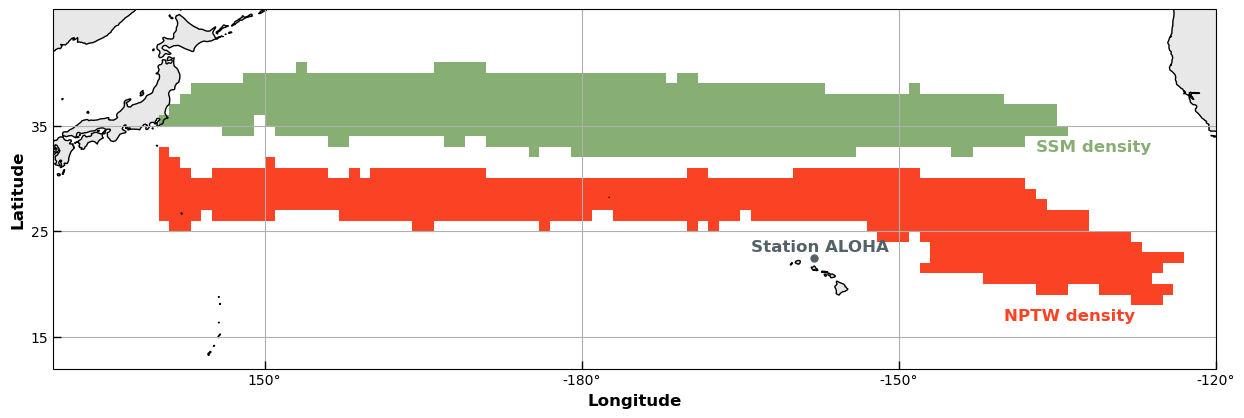

In [202]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, figsize=(15,10))  

# Define the colors for each dataset
color_nptw = 'xkcd:orangey red'  # Change to any named color
color_ssm = 'xkcd:sage'
color_npiw = 'xkcd:ocean'

# Convert named colors to colormap with just one color
cmap_nptw = mcolors.ListedColormap([color_nptw])
cmap_ssm = mcolors.ListedColormap([color_ssm])
cmap_npiw = mcolors.ListedColormap([color_npiw])


# Get coordinates
lon_nptw = rg_nptw['longitude']
lat_nptw = rg_nptw['latitude']
mask_nptw = np.isnan(rg_nptw.mean(dim=('time', 'pressure'))['ARGO_SALINITY'])

lon_ssm = rg_ssm['longitude']
lat_ssm = rg_ssm['latitude']
mask_ssm = np.isnan(rg_ssm.mean(dim=('time', 'pressure'))['ARGO_SALINITY'])

#lon_npiw = rg_npiw['longitude']
#lat_npiw = rg_npiw['latitude']
#mask_npiw = np.isnan(rg_npiw.mean(dim=('time', 'pressure'))['ARGO_SALINITY'])

# Create masked arrays filled with a constant value but respecting the original mask
fill_nptw = np.full_like(mask_nptw, 1, dtype=float)  # Value doesn't matter
fill_nptw[mask_nptw] = np.nan  # Preserve masked areas

fill_ssm = np.full_like(mask_ssm, 1, dtype=float)  # Value doesn't matter
fill_ssm[mask_ssm] = np.nan  # Preserve masked areas

#fill_npiw = np.full_like(mask_npiw, 1, dtype=float)  # Value doesn't matter
#fill_npiw[mask_npiw] = np.nan  # Preserve masked areas


# Plot the masked regions with solid colors
ax.pcolormesh(lon_nptw, lat_nptw, fill_nptw, cmap=cmap_nptw, transform=ccrs.PlateCarree())
ax.pcolormesh(lon_ssm, lat_ssm, fill_ssm, cmap=cmap_ssm, transform=ccrs.PlateCarree())
#ax.pcolormesh(lon_npiw, lat_npiw, fill_npiw, cmap=cmap_npiw, transform=ccrs.PlateCarree())


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add coastline contours
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

# Add land features (optional)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)

plt.scatter(202, 22.5, marker='.', s=100, color='xkcd:gunmetal', transform=ccrs.PlateCarree())

ax.text(202-6, 22.5+1, 'Station ALOHA', transform=ccrs.PlateCarree(),
        fontsize=12, fontweight='bold', color='xkcd:gunmetal', ha='left', va='center')

ax.text(223, 33, 'SSM density', transform=ccrs.PlateCarree(),
        fontsize=12, fontweight='bold', color='xkcd:sage', ha='left', va='center')

ax.text(220, 17, 'NPTW density', transform=ccrs.PlateCarree(),
        fontsize=12, fontweight='bold', color='xkcd:orangey red', ha='left', va='center')


# Set axis labels
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')

# Set ticks for longitude and latitude
xticks = np.arange(-180, 180, 30)
yticks = np.arange(15, 45, 10)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())  # Apply these ticks in the correct CRS
ax.set_xticklabels([f"{x}°" for x in xticks])  # Ensure the correct labels appear

ax.set_yticks(yticks)  

ax.set_ylim(12,46)
ax.set_xlim(-50,60)


# Enable gridlines
ax.grid(True)

# Set tick labels visibility
ax.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')

plt.savefig('LK_FigS3_map.png', dpi=500)

In [153]:
mask_nptw = rg_nptw.mean(dim=('time', 'pressure'))
mask_ssm = rg_ssm.mean(dim=('time', 'pressure'))

## Spatial Features in OceanSODA-ETHZ

In [166]:
## Subset: North Pacific Subtropical Gyre
npsg = soda.sel(lat = latslice, lon = lonslice)
npsg = npsg.rename({'lat':'latitude', 'lon':'longitude'})
npsg = npsg.drop_vars(('fgco2_global', 'area'))

In [167]:
npsg['sdic'] = npsg['dic'] / npsg['salinity'] * 35
npsg['salk'] = npsg['talk'] / npsg['salinity'] * 35
npsg['alk_dic'] = npsg['talk'] - npsg['dic']

In [168]:
npsg_dd = detrend_deseasonalize_dataset(npsg)

In [173]:
npsg_dd_ma = coastal_mask(npsg_dd)

In [174]:
# winter months 
npsg_dd_ma_winter = npsg_dd_ma.where(((npsg_dd_ma['time.month'] == 12) |(npsg_dd_ma['time.month'] == 1) | (npsg_dd_ma['time.month'] == 2)), drop=True)
npsg_dd_ma_winter = npsg_dd_ma_winter.coarsen(time=3, boundary="trim").mean().resample(time='YE').mean()

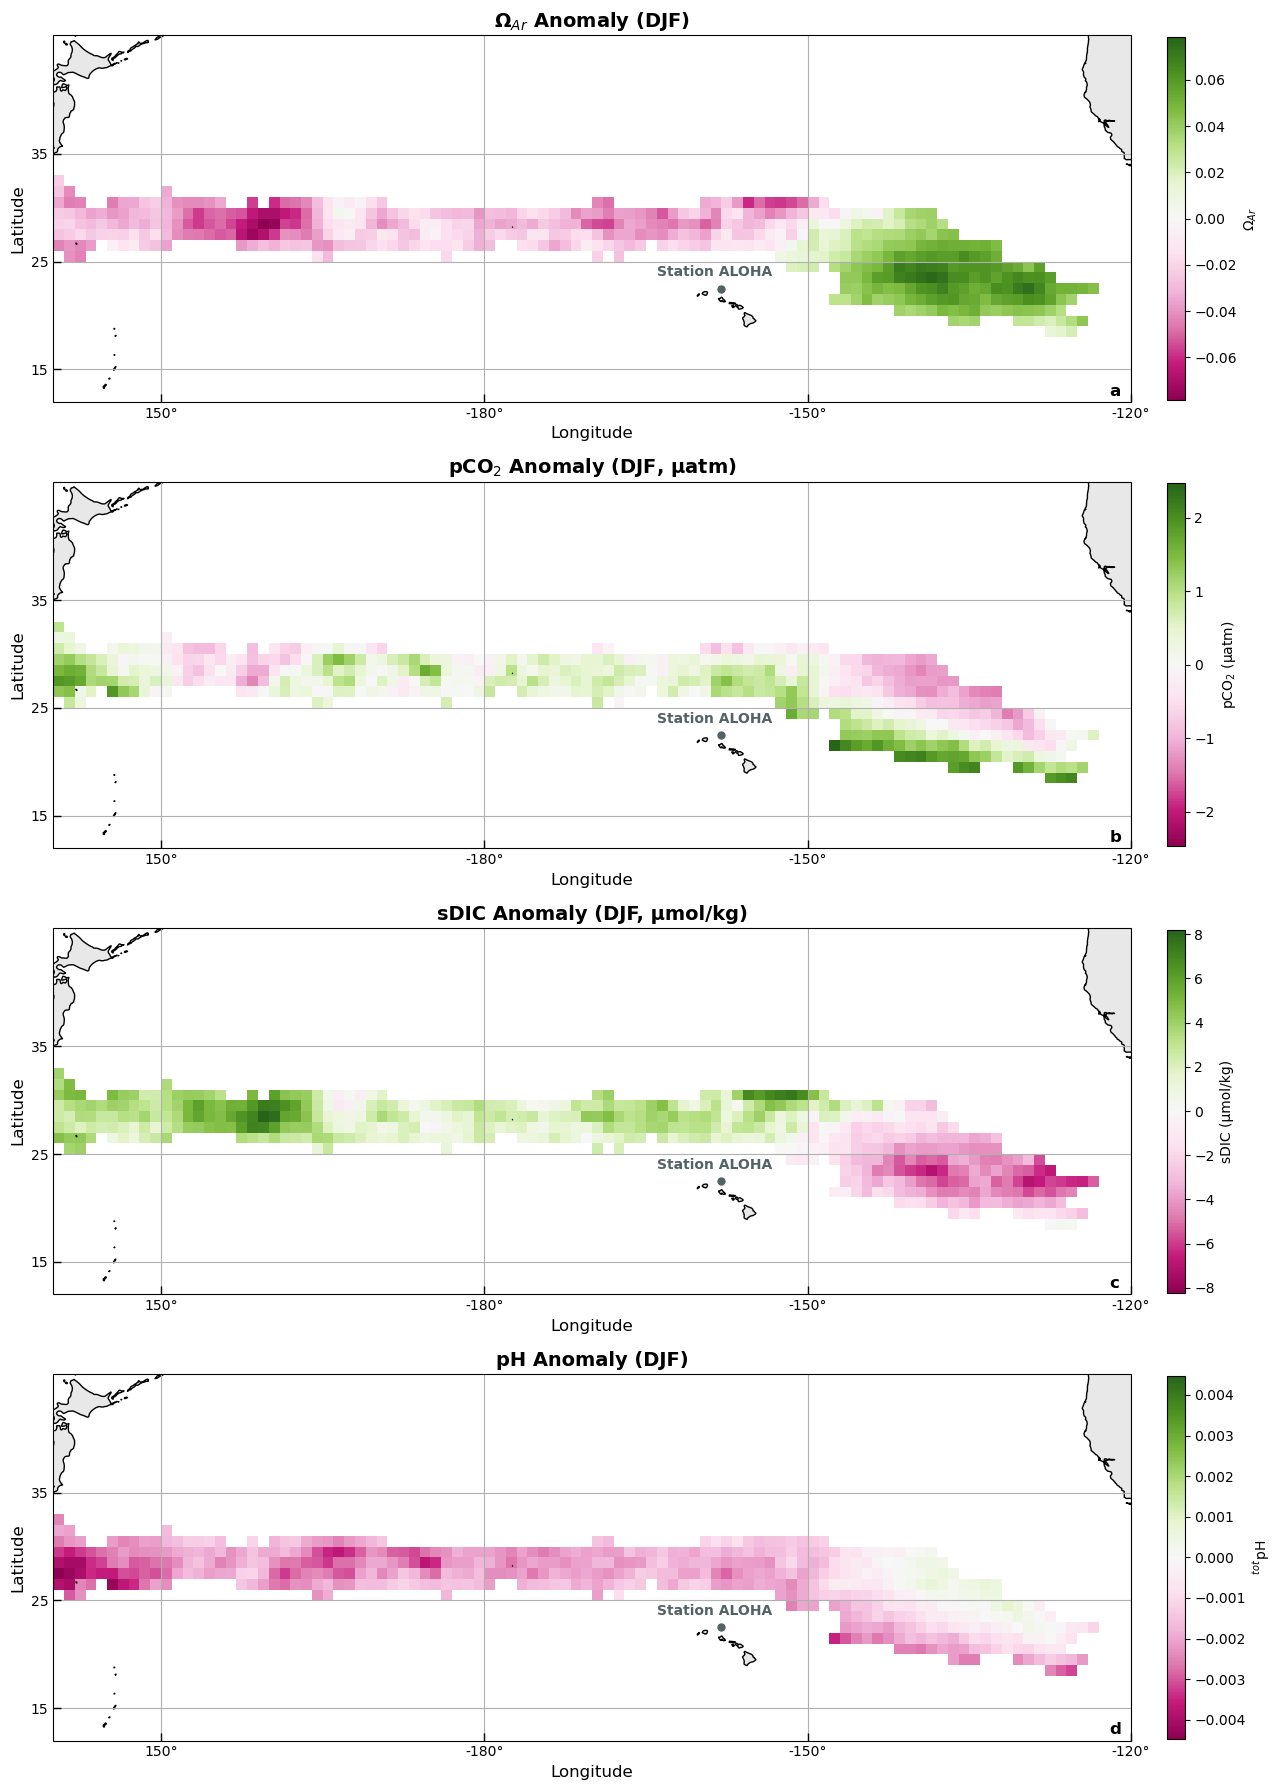

In [175]:
# Figure 11
fig, axs = plt.subplots(4, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, figsize=(18,18))  

axs = axs.flatten()

## OmegaARin
ax = axs[0]

# Get coordinates
lon_nptw = rg_nptw['longitude']
lat_nptw = rg_nptw['latitude']

npsg_dd_ma_winter.where(~np.isnan(mask_nptw['ARGO_SALINITY_ANOMALY'])).where(npsg_dd_ma_winter.time > pd.to_datetime('2014-01-01')).mean(dim='time').omega_ar.plot(x='longitude', 
y='latitude', cmap='PiYG', cbar_kwargs={'label': "Ω$_A$$_r$",'shrink': 0.99, 'pad': 0.02}, transform=ccrs.PlateCarree(), ax=ax)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add coastline contours
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

# Add land features (optional)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)

ax.scatter(202, 22.5, marker='.', s=100, color='xkcd:gunmetal', transform=ccrs.PlateCarree())

ax.text(202-6, 22.5+1.5, 'Station ALOHA', transform=ccrs.PlateCarree(),
        fontsize=10, fontweight='bold', color='xkcd:gunmetal', ha='left', va='center')

ax.text(238, 13, 'a', transform=ccrs.PlateCarree(),
        fontsize=12, fontweight='bold', color='black', ha='left', va='center')

# Set axis labels
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Set ticks for longitude and latitude
xticks = np.arange(-180, 180, 30)
yticks = np.arange(15, 45, 10)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())  # Apply these ticks in the correct CRS
ax.set_xticklabels([f"{x}°" for x in xticks])  # Ensure the correct labels appear

ax.set_yticks(yticks)  

ax.set_ylim(12,46)
ax.set_xlim(-40,60)

ax.grid(True)

ax.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax.set_title('Ω$_A$$_r$ Anomaly (DJF)', fontsize=14, fontweight='bold')

## pCO2
ax = axs[1]

# Get coordinates
lon_nptw = rg_nptw['longitude']
lat_nptw = rg_nptw['latitude']

npsg_dd_ma_winter.where(~np.isnan(mask_nptw['ARGO_SALINITY_ANOMALY'])).where(npsg_dd_ma_winter.time > pd.to_datetime('2014-01-01')).mean(dim='time').spco2.plot(x='longitude', 
y='latitude', cmap='PiYG', cbar_kwargs={'label': "pCO$_2$ (µatm)",'shrink': 0.99, 'pad': 0.02}, transform=ccrs.PlateCarree(), ax=ax)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add coastline contours
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

# Add land features (optional)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)

ax.scatter(202, 22.5, marker='.', s=100, color='xkcd:gunmetal', transform=ccrs.PlateCarree())

ax.text(202-6, 22.5+1.5, 'Station ALOHA', transform=ccrs.PlateCarree(),
        fontsize=10, fontweight='bold', color='xkcd:gunmetal', ha='left', va='center')

ax.text(238, 13, 'b', transform=ccrs.PlateCarree(),
        fontsize=12, fontweight='bold', color='black', ha='left', va='center')

# Set axis labels
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Set ticks for longitude and latitude
xticks = np.arange(-180, 180, 30)
yticks = np.arange(15, 45, 10)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())  # Apply these ticks in the correct CRS
ax.set_xticklabels([f"{x}°" for x in xticks])  # Ensure the correct labels appear

ax.set_yticks(yticks)  

ax.set_ylim(12,46)
ax.set_xlim(-40,60)

ax.grid(True)

ax.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax.set_title('pCO$_2$ Anomaly (DJF, µatm)', fontsize=14, fontweight='bold')

## sDIC
ax = axs[2]

# Get coordinates
lon_nptw = rg_nptw['longitude']
lat_nptw = rg_nptw['latitude']

npsg_dd_ma_winter.where(~np.isnan(mask_nptw['ARGO_SALINITY_ANOMALY'])).where(npsg_dd_ma_winter.time > pd.to_datetime('2014-01-01')).mean(dim='time').sdic.plot(x='longitude', 
y='latitude', cmap='PiYG', cbar_kwargs={'label': "sDIC (µmol/kg)",'shrink': 0.99, 'pad': 0.02}, transform=ccrs.PlateCarree(), ax=ax)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add coastline contours
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

# Add land features (optional)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)

ax.scatter(202, 22.5, marker='.', s=100, color='xkcd:gunmetal', transform=ccrs.PlateCarree())

ax.text(202-6, 22.5+1.5, 'Station ALOHA', transform=ccrs.PlateCarree(),
        fontsize=10, fontweight='bold', color='xkcd:gunmetal', ha='left', va='center')

ax.text(238, 13, 'c', transform=ccrs.PlateCarree(),
        fontsize=12, fontweight='bold', color='black', ha='left', va='center')

# Set axis labels
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Set ticks for longitude and latitude
xticks = np.arange(-180, 180, 30)
yticks = np.arange(15, 45, 10)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())  # Apply these ticks in the correct CRS
ax.set_xticklabels([f"{x}°" for x in xticks])  # Ensure the correct labels appear

ax.set_yticks(yticks)  

ax.set_ylim(12,46)
ax.set_xlim(-40,60)

ax.grid(True)

ax.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax.set_title('sDIC Anomaly (DJF, µmol/kg)', fontsize=14, fontweight='bold')

## pH
ax = axs[3]

# Get coordinates
lon_nptw = rg_nptw['longitude']
lat_nptw = rg_nptw['latitude']

npsg_dd_ma_winter.where(~np.isnan(mask_nptw['ARGO_SALINITY_ANOMALY'])).where(npsg_dd_ma_winter.time > pd.to_datetime('2014-01-01')).mean(dim='time').ph_total.plot(x='longitude', 
y='latitude', cmap='PiYG', cbar_kwargs={'label': "$^t$$^o$$^t$pH",'shrink': 0.99, 'pad': 0.02}, transform=ccrs.PlateCarree(), ax=ax)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add coastline contours
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

# Add land features (optional)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)

ax.scatter(202, 22.5, marker='.', s=100, color='xkcd:gunmetal', transform=ccrs.PlateCarree())

ax.text(202-6, 22.5+1.5, 'Station ALOHA', transform=ccrs.PlateCarree(),
        fontsize=10, fontweight='bold', color='xkcd:gunmetal', ha='left', va='center')

ax.text(238, 13, 'd', transform=ccrs.PlateCarree(),
        fontsize=12, fontweight='bold', color='black', ha='left', va='center')

# Set axis labels
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Set ticks for longitude and latitude
xticks = np.arange(-180, 180, 30)
yticks = np.arange(15, 45, 10)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())  # Apply these ticks in the correct CRS
ax.set_xticklabels([f"{x}°" for x in xticks])  # Ensure the correct labels appear

ax.set_yticks(yticks)  

ax.set_ylim(12,46)
ax.set_xlim(-40,60)

ax.grid(True)

ax.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax.set_title('pH Anomaly (DJF)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('LK_Fig11.png', dpi=500)

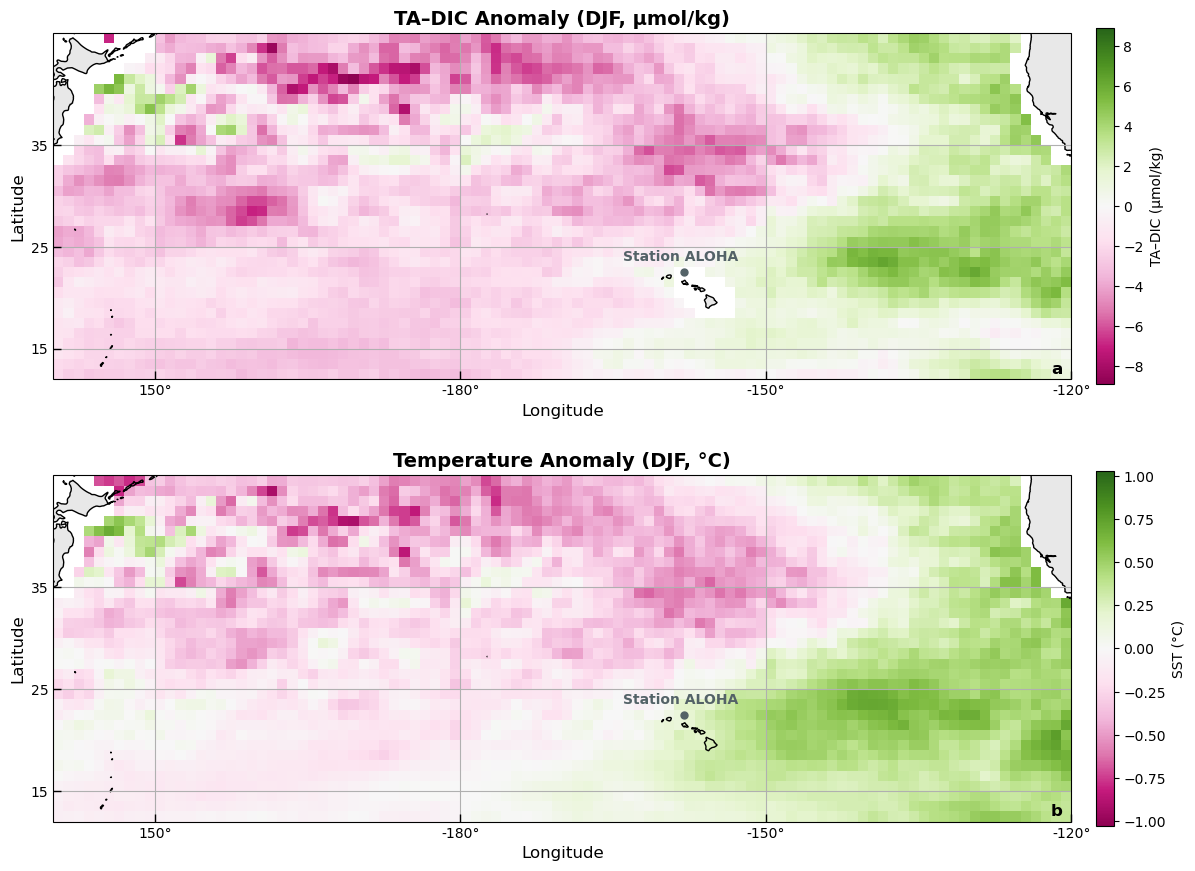

In [176]:
fig, axs = plt.subplots(2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, figsize=(13,9))  

axs = axs.flatten()

## TA–DIC
ax = axs[0]

# Get coordinates
lon_nptw = rg_nptw['longitude']
lat_nptw = rg_nptw['latitude']

npsg_dd_ma_winter.where(npsg_dd_ma_winter.time > pd.to_datetime('2014-01-01')).mean(dim='time').alk_dic.plot(x='longitude', 
y='latitude', cmap='PiYG', cbar_kwargs={'label': "TA–DIC (µmol/kg)",'shrink': 0.9, 'pad': 0.02}, transform=ccrs.PlateCarree(), ax=ax)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add coastline contours
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

# Add land features (optional)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)

ax.scatter(202, 22.5, marker='.', s=100, color='xkcd:gunmetal', transform=ccrs.PlateCarree())

ax.text(202-6, 22.5+1.5, 'Station ALOHA', transform=ccrs.PlateCarree(),
        fontsize=10, fontweight='bold', color='xkcd:gunmetal', ha='left', va='center')

ax.text(238, 13, 'a', transform=ccrs.PlateCarree(),
        fontsize=12, fontweight='bold', color='black', ha='left', va='center')

# Set axis labels
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Set ticks for longitude and latitude
xticks = np.arange(-180, 180, 30)
yticks = np.arange(15, 45, 10)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())  # Apply these ticks in the correct CRS
ax.set_xticklabels([f"{x}°" for x in xticks])  # Ensure the correct labels appear

ax.set_yticks(yticks)  

ax.set_ylim(12,46)
ax.set_xlim(-40,60)

ax.grid(True)

ax.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax.set_title('TA–DIC Anomaly (DJF, µmol/kg)', fontsize=14, fontweight='bold')

## pCO2
ax = axs[1]

# Get coordinates
lon_nptw = rg_nptw['longitude']
lat_nptw = rg_nptw['latitude']

npsg_dd_ma_winter.where(npsg_dd_ma_winter.time > pd.to_datetime('2014-01-01')).mean(dim='time').temperature.plot(x='longitude', 
y='latitude', cmap='PiYG', cbar_kwargs={'label': "SST (°C)",'shrink': 0.9, 'pad': 0.02}, transform=ccrs.PlateCarree(), ax=ax)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add coastline contours
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

# Add land features (optional)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)

ax.scatter(202, 22.5, marker='.', s=100, color='xkcd:gunmetal', transform=ccrs.PlateCarree())

ax.text(202-6, 22.5+1.5, 'Station ALOHA', transform=ccrs.PlateCarree(),
        fontsize=10, fontweight='bold', color='xkcd:gunmetal', ha='left', va='center')

ax.text(238, 13, 'b', transform=ccrs.PlateCarree(),
        fontsize=12, fontweight='bold', color='black', ha='left', va='center')

# Set axis labels
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Set ticks for longitude and latitude
xticks = np.arange(-180, 180, 30)
yticks = np.arange(15, 45, 10)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())  # Apply these ticks in the correct CRS
ax.set_xticklabels([f"{x}°" for x in xticks])  # Ensure the correct labels appear

ax.set_yticks(yticks)  

ax.set_ylim(12,46)
ax.set_xlim(-40,60)

ax.grid(True)

ax.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax.set_title('Temperature Anomaly (DJF, °C)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('LK_Fig10.png', dpi=500)

## Changes in NPTW and SSM "Source regions" as identified by winter outcrop of isopycnals

### TA-DIC in source regions of NPTW and SSM

In [177]:
nptw_source = npsg.where(~np.isnan(mask_nptw['ARGO_SALINITY_ANOMALY'])).where(npsg.time >= pd.to_datetime('1988-12-31')).mean(dim=('latitude','longitude')).to_dataframe()
ssm_source = npsg.where(~np.isnan(mask_ssm['ARGO_SALINITY_ANOMALY'])).where(npsg.time >= pd.to_datetime('1988-12-31')).mean(dim=('latitude','longitude')).to_dataframe()

In [178]:
nptw_source['year'] = nptw_source.index.year
nptw_source['month'] = nptw_source.index.month
nptw_source['day'] = nptw_source.index.day
nptw_source['decimal_month'] = decimal_month(nptw_source['year'], nptw_source['month'], nptw_source['day'])
nptw_source['decimal_year'] = nptw_source['year'] + (nptw_source['decimal_month'] - 1) / 12

In [179]:
ssm_source['year'] = ssm_source.index.year
ssm_source['month'] = ssm_source.index.month
ssm_source['day'] = ssm_source.index.day
ssm_source['decimal_month'] = decimal_month(ssm_source['year'], ssm_source['month'], ssm_source['day'])
ssm_source['decimal_year'] = ssm_source['year'] + (ssm_source['decimal_month'] - 1) / 12

In [180]:
nptw_source_trends, nptw_source_slopes, nptw_source_intercepts, nptw_source_rs, nptw_source_ps, nptw_source_errs = trend(nptw_source)

In [181]:
nptw_source_anom, nptw_source_fit = detrend_deseason(nptw_source, 2004) ## anomalies and model
nptw_source_season = nptw_source_fit - nptw_source_trends   ## seasonal cycle model 
nptw_source_deseasoned = nptw_source - nptw_source_season ## deseasoned data (with trend)

In [182]:
ssm_source_trends, ssm_source_slopes, ssm_source_intercepts, ssm_source_rs, ssm_source_ps, ssm_source_errs = trend(ssm_source)

In [183]:
ssm_source_anom, ssm_source_fit = detrend_deseason(ssm_source, 2004) ## anomalies and model
ssm_source_season = ssm_source_fit - ssm_source_trends   ## seasonal cycle model 
ssm_source_deseasoned = ssm_source - ssm_source_season ## deseasoned data (with trend)

In [184]:
## deseasoned
nptw_source_deseasoned_trends, nptw_source_deseasoned_slopes, nptw_source_deseasoned_intercepts, nptw_source_deseasoned_rs, nptw_source_deseasoned_ps, nptw_source_deseasoned_errs = trend(nptw_source_deseasoned)

In [185]:
## deseasoned
ssm_source_deseasoned_trends, ssm_source_deseasoned_slopes, ssm_source_deseasoned_intercepts, ssm_source_deseasoned_rs, ssm_source_deseasoned_ps, ssm_source_deseasoned_errs = trend(ssm_source_deseasoned)

In [186]:
nptw_source_deseasoned_trends['alk_dic'].notna().idxmax()

Timestamp('1989-01-01 00:00:00')

In [187]:
surf_deseasoned_trends['alk_dic'].notna().idxmax()

Timestamp('1989-01-08 14:36:37')

In [188]:
surf_deseasoned_slopes[11]

('alk_dic', -0.9468048245242596)

In [189]:
nptw_source_deseasoned_slopes[23]

('alk_dic', -0.8163757267562668)

/var/folders/nj/szt8lwtn2rb8rksl6pt521wh0000gp/T/ipykernel_4973/2600848088.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atm_line = -0.84 * surf_deseasoned_trends[surf_deseasoned_trends['alk_dic'] >0]['decimal_year'] + surf_deseasoned_trends[surf_deseasoned_trends.index == pd.to_datetime('1989-01-08 14:36:37')]['alk_dic'][0] - (-0.84 * surf_deseasoned_trends[surf_deseasoned_trends['alk_dic'] >0]['decimal_year'][0])
/var/folders/nj/szt8lwtn2rb8rksl6pt521wh0000gp/T/ipykernel_4973/2600848088.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atm_line = -0.84 * surf_deseasoned_trends[surf_deseasoned_trends['alk_d

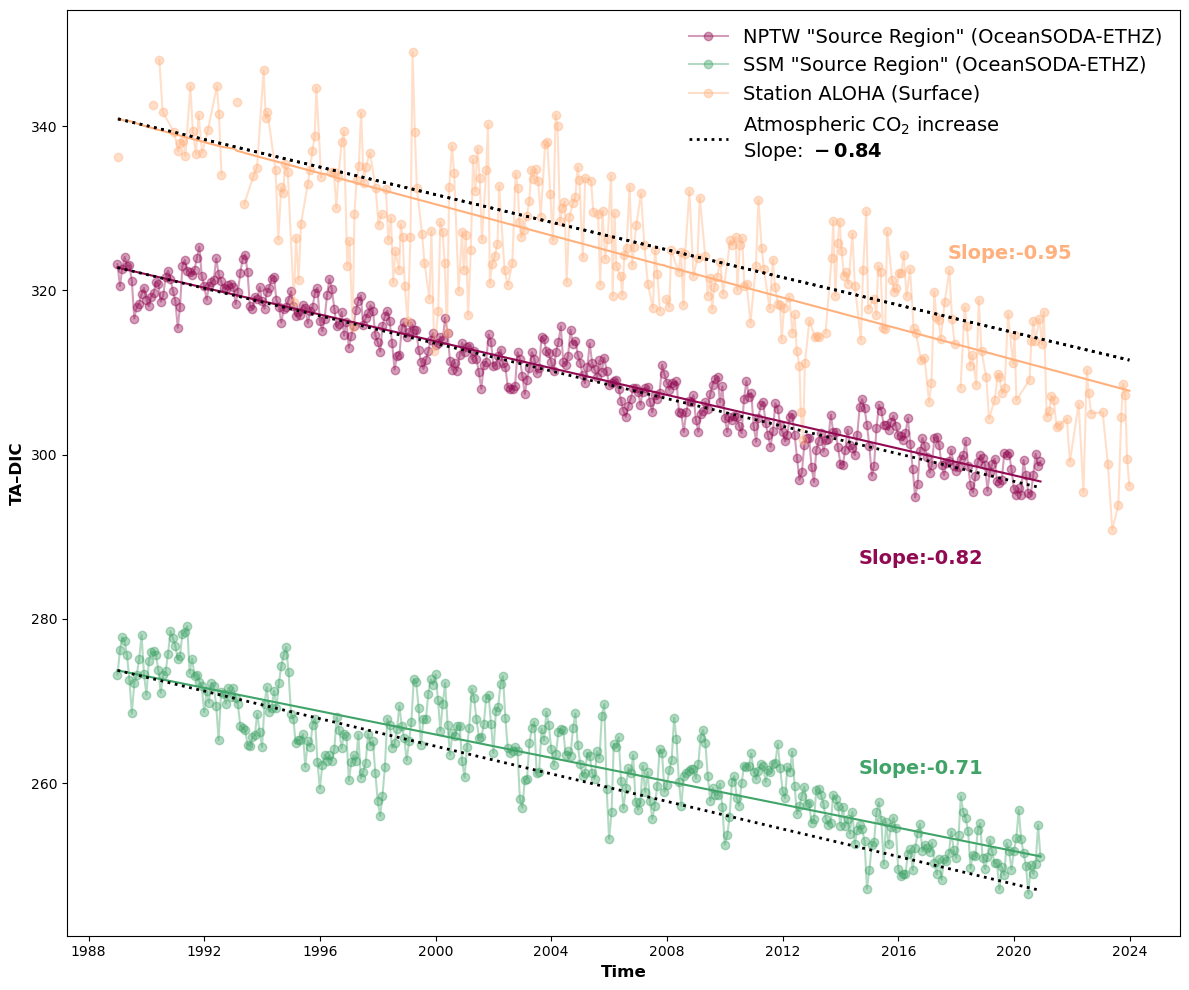

In [190]:
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(nptw_source_deseasoned.index, nptw_source_deseasoned['alk_dic'], marker='o', color='xkcd:reddish purple', alpha=0.4)
ax.plot(ssm_source_deseasoned.index, ssm_source_deseasoned['alk_dic'], marker='o', color='xkcd:greenish', alpha=0.4)
ax.plot(surf_deseasoned.index, surf_deseasoned['alk_dic'], marker='o', color='xkcd:peach', alpha=0.4)
atm_line = -0.84 * surf_deseasoned_trends[surf_deseasoned_trends['alk_dic'] >0]['decimal_year'] + surf_deseasoned_trends[surf_deseasoned_trends.index == pd.to_datetime('1989-01-08 14:36:37')]['alk_dic'][0] - (-0.84 * surf_deseasoned_trends[surf_deseasoned_trends['alk_dic'] >0]['decimal_year'][0])
ax.plot(surf_deseasoned_trends[surf_deseasoned_trends['alk_dic'] >0].index, 
        atm_line, color='black', linewidth=2, linestyle='dotted')

ax.plot(nptw_source_deseasoned_trends['alk_dic'], color='xkcd:reddish purple')

ax.plot(ssm_source_deseasoned_trends['alk_dic'], color='xkcd:greenish')

ax.plot(surf_deseasoned_trends['alk_dic'].interpolate(), color='xkcd:peach')


atm_line = -0.84 * surf_deseasoned_trends[surf_deseasoned_trends['alk_dic'] >0]['decimal_year'] + surf_deseasoned_trends[surf_deseasoned_trends.index == pd.to_datetime('1989-01-08 14:36:37')]['alk_dic'][0] - (-0.84 * surf_deseasoned_trends[surf_deseasoned_trends['alk_dic'] >0]['decimal_year'][0])
ax.plot(surf_deseasoned_trends[surf_deseasoned_trends['alk_dic'] >0].index, 
        atm_line, color='black', linewidth=2, linestyle='dotted')

atm_line1 = -0.84 * nptw_source_deseasoned_trends[nptw_source_deseasoned_trends['alk_dic'] >0]['decimal_year'] + nptw_source_deseasoned_trends[nptw_source_deseasoned_trends.index == pd.to_datetime('1989-01-01 00:00:00')]['alk_dic'][0] - (-0.84 * nptw_source_deseasoned_trends[nptw_source_deseasoned_trends['alk_dic'] >0]['decimal_year'][0])
ax.plot(nptw_source_deseasoned_trends[nptw_source_deseasoned_trends['alk_dic'] >0].index, 
        atm_line1, color='black', linewidth=2, linestyle='dotted')

atm_line2 = -0.84 * ssm_source_deseasoned_trends[ssm_source_deseasoned_trends['alk_dic'] >0]['decimal_year'] + ssm_source_deseasoned_trends[ssm_source_deseasoned_trends.index == pd.to_datetime('1989-01-01 00:00:00')]['alk_dic'][0] - (-0.84 * ssm_source_deseasoned_trends[ssm_source_deseasoned_trends['alk_dic'] >0]['decimal_year'][0])
ax.plot(ssm_source_deseasoned_trends[nptw_source_deseasoned_trends['alk_dic'] >0].index, 
        atm_line2, color='black', linewidth=2, linestyle='dotted')


add_slope_label(ax, surf_deseasoned_trends.interpolate().alk_dic, 'xkcd:peach', 
                f'Slope:{surf_deseasoned_slopes[11][1]:.2f}', y_offset=+16)

add_slope_label(ax, nptw_source_deseasoned_trends.interpolate().alk_dic, 'xkcd:reddish purple', 
                f'Slope:{nptw_source_deseasoned_slopes[23][1]:.2f}', y_offset=-10)

add_slope_label(ax, ssm_source_deseasoned_trends.interpolate().alk_dic, 'xkcd:greenish', 
                f'Slope:{ssm_source_deseasoned_slopes[23][1]:.2f}', y_offset=+10)



ax.legend(['NPTW "Source Region" (OceanSODA-ETHZ)', 
           'SSM "Source Region" (OceanSODA-ETHZ)', 
           'Station ALOHA (Surface)',  
           r'Atmospheric CO$_2$ increase'+'\n'+r'Slope: $\bf-0.84$', 
          ], fontsize=14, frameon=False)
ax.set_ylabel('TA–DIC', fontsize=12, fontweight='bold')
ax.set_xlabel('Time', fontsize=12, fontweight='bold')

fig.tight_layout()

plt.savefig('LK_FigSX_sourceregions_TA-DIC.png', dpi=500)

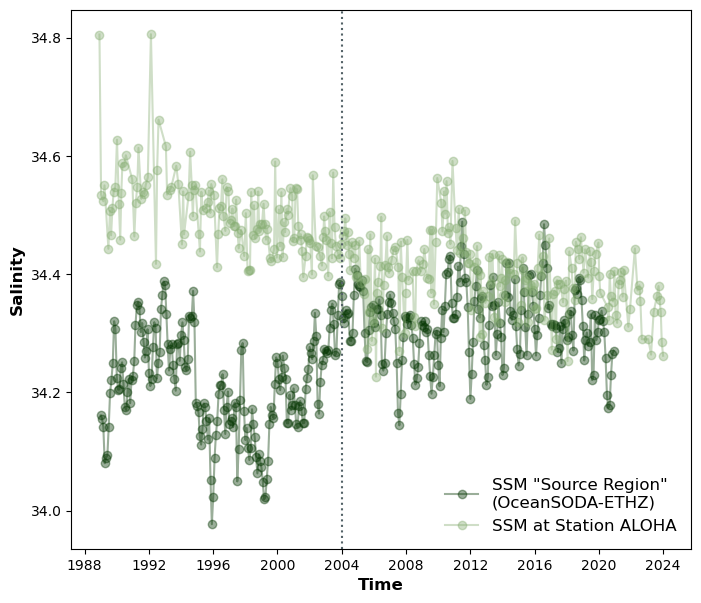

In [193]:
fig, ax = plt.subplots(figsize=(8,7))

ax.plot(ssm_source_deseasoned.index, ssm_source_deseasoned['salinity'], marker='o', color='xkcd:dark green', alpha=0.4)
ax.plot(ssm_deseasoned.index, ssm_deseasoned['csal'], marker='o', color='xkcd:sage', alpha=0.4)

#ax.plot(ssm_source_deseasoned_trends['salinity'], color='xkcd:greenish')

#ax.plot(ssm_deseasoned_trends['csal'].interpolate(), color='xkcd:sage')

#add_slope_label(ax, ssm_source_deseasoned_trends.interpolate().salinity, 'xkcd:greenish', 
#                f'Slope:{ssm_source_deseasoned_slopes[17][1]:.2f}', y_offset=+1)



ax.legend([
           'SSM "Source Region"\n(OceanSODA-ETHZ)', 
           'SSM at Station ALOHA',  
          ], fontsize=12, frameon=False, loc='lower right')
ax.set_ylabel('Salinity', fontsize=12, fontweight='bold')
ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.axvline(pd.to_datetime('2004-01-01'), color='xkcd:gunmetal', linestyle='dotted')

#fig.tight_layout()

plt.savefig('LK_FigSX_SSM_sourceregion_csal.png', dpi=500)

# Other Figures

In [194]:
# Figure 5
car_aloha_cr['Sal_anomaly'] = car_aloha_cr['csal'] - car_aloha_cr['csal'].mean(dim='time')

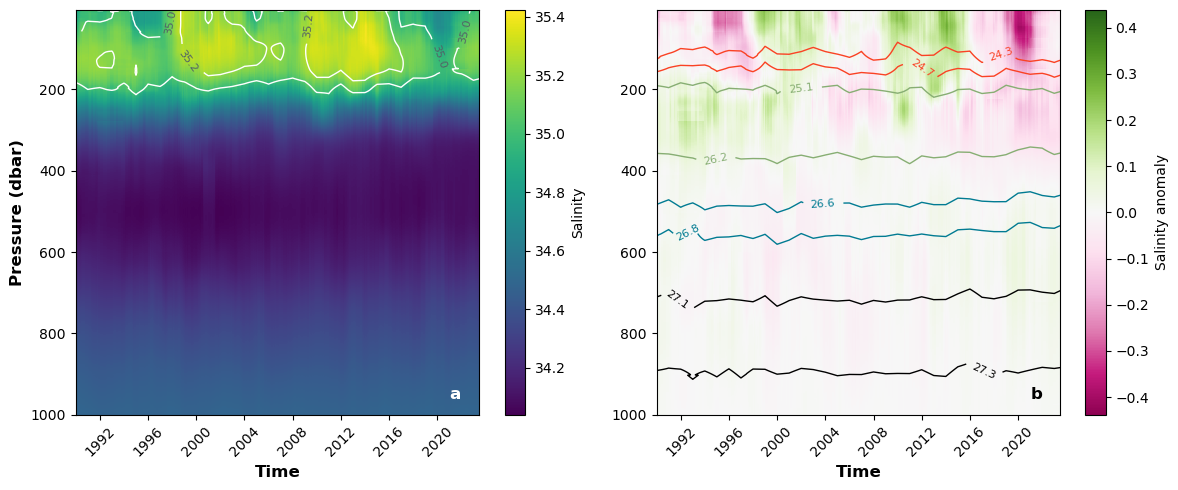

In [195]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

axs = axs.flatten()

## Salinity
ax = axs[0]

car_aloha_cr.interpolate_na(dim='time').rolling(time=12, center=True).mean()['csal'].plot(y='pressure', 
                                                        cbar_kwargs={'label': 'Salinity'}, 
                                                                                         ax=ax)


cs = ax.contour( 
                car_aloha_cr.resample(time='YE').mean()['time'], 
                car_aloha_cr.resample(time='YE').mean()['pressure'],
                car_aloha_cr.resample(time='YE').mean()['csal'].transpose(), 
                levels=[35, 35.2], colors='white', linewidths=1)

ax.invert_yaxis()
ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Pressure (dbar)', fontsize=12, fontweight='bold')
ax.set_xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('2023-06-30'))
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylim(1000,5)

# Label the contour line 
ax.clabel(cs, fmt='%1.1f', colors='xkcd:gunmetal', fontsize=8)
ax.text(pd.to_datetime('2020-12-31'), 950, 'a', 
        fontsize=12, fontweight='bold', color='white', ha='left', va='center')

## Salinity anomaly

ax=axs[1]

car_aloha_cr.interpolate_na(dim='time').rolling(time=12, center=True).mean()['Sal_anomaly'].plot(y='pressure', 
                                                                                                 cmap='PiYG',
                                                                                                cbar_kwargs={'label': 'Salinity anomaly'})


# wm contours
cs1 = ax.contour( 
                car_aloha_cr.resample(time='YE').mean()['time'], 
                car_aloha_cr.resample(time='YE').mean()['pressure'],
                car_aloha_cr.resample(time='YE').mean()['sigma'].transpose(), 
                levels=[24.3, 24.7], colors='xkcd:orangey red', linewidths=1)

cs2 = ax.contour( 
                car_aloha_cr.resample(time='YE').mean()['time'], 
                car_aloha_cr.resample(time='YE').mean()['pressure'],
                car_aloha_cr.resample(time='YE').mean()['sigma'].transpose(), 
                levels=[25.1, 26.2], colors='xkcd:sage', linewidths=1)

cs3 = ax.contour( 
                car_aloha_cr.resample(time='YE').mean()['time'], 
                car_aloha_cr.resample(time='YE').mean()['pressure'],
                car_aloha_cr.resample(time='YE').mean()['sigma'].transpose(), 
                levels=[26.6, 26.8], colors='xkcd:ocean', linewidths=1)

cs4 = ax.contour( 
                car_aloha_cr.resample(time='YE').mean()['time'], 
                car_aloha_cr.resample(time='YE').mean()['pressure'],
                car_aloha_cr.resample(time='YE').mean()['sigma'].transpose(), 
                levels=[27.1, 27.3], colors='black', linewidths=1)

ax.invert_yaxis()
ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('2023-06-30'))
ax.set_ylim(1000,5)
ax.set_ylabel(None)


# Label the contour line 
ax.clabel(cs1, fmt='%1.1f', colors='xkcd:orangey red', fontsize=8)
ax.clabel(cs2, fmt='%1.1f', colors='xkcd:sage', fontsize=8)
ax.clabel(cs3, fmt='%1.1f', colors='xkcd:ocean', fontsize=8)
ax.clabel(cs4, fmt='%1.1f', colors='black', fontsize=8)

ax.text(pd.to_datetime('2020-12-31'), 950, 'b', 
        fontsize=12, fontweight='bold', color='black', ha='left', va='center')

ax.tick_params(axis='x', labelrotation=45)

fig.tight_layout()
plt.savefig('LK_Fig5.png', dpi=500)

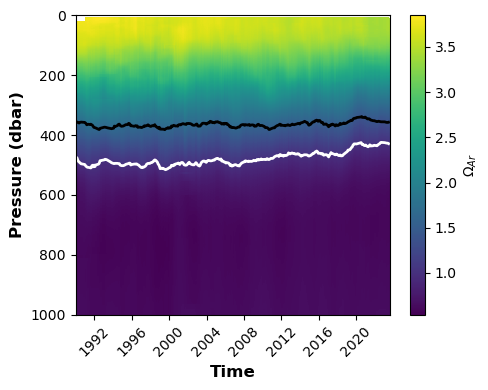

In [196]:
fig, ax = plt.subplots(figsize=(5,4))

car_aloha_cr.interpolate_na(dim='time').rolling(time=12, center=True).mean()['OmegaARin'].plot(y='pressure',
                                                                                               cbar_kwargs={'label': 'Ω$_A$$_r$',
                                                                                                })

# Create the contour plot for OmegaARin = 1
cs = ax.contour(
                car_aloha_cr.interpolate_na(dim='time').rolling(time=12, center=True).mean()['time'], 
                car_aloha_cr.interpolate_na(dim='time').rolling(time=12, center=True).mean()['pressure'], 
                car_aloha_cr.interpolate_na(dim='time').rolling(time=12, center=True).mean()['OmegaARin'].transpose(), 
                levels=[1], colors='white', linewidths=2)

# Max depth of SSM
cs = ax.contour( 
                car_aloha_cr.interpolate_na(dim='time').rolling(time=12, center=True).mean()['time'], 
                car_aloha_cr.interpolate_na(dim='time').rolling(time=12, center=True).mean()['pressure'],
                car_aloha_cr.interpolate_na(dim='time').rolling(time=12, center=True).mean()['sigma'].transpose(), 
                levels=[26.2], colors='black', linewidths=2)

ax.invert_yaxis()
ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Pressure (dbar)', fontsize=12, fontweight='bold')
ax.set_xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('2023-08-31'))

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('LK_Fig12.png', dpi=500)

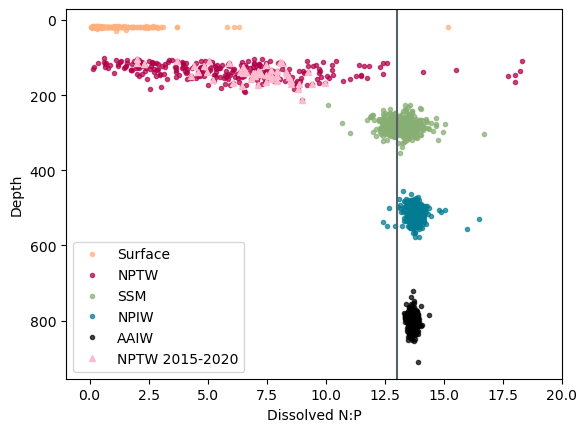

In [203]:
# Figure S7b

fig, ax = plt.subplots()
ax.plot( (surf['nit']/surf['phos']), surf['press'],'.', color='xkcd:peach', alpha=0.7)
ax.plot( (nptw['nit']/nptw['phos']), nptw['press'], '.', color='xkcd:raspberry', alpha=0.7)
ax.plot((ssm['nit']/ssm['phos']), ssm['press'], '.', color='xkcd:sage', alpha=0.7) 
ax.plot( (npiw['nit']/npiw['phos']), npiw['press'], '.', color='xkcd:ocean', alpha=0.7)
ax.plot( (aaiw['nit']/aaiw['phos']), aaiw['press'], '.', color='black', alpha=0.7)

ax.plot( (nptw[(nptw.index >= pd.to_datetime('2015-01-01')) & (nptw.index <= pd.to_datetime('2020-12-31'))]['nit']/nptw[(nptw.index >= pd.to_datetime('2015-01-01')) & (nptw.index <= pd.to_datetime('2020-12-31'))]['phos']), 
        nptw[(nptw.index >= pd.to_datetime('2015-01-01')) & (nptw.index <= pd.to_datetime('2020-12-31'))]['press'], '^', markersize=4, color='xkcd:pastel pink')

ax.legend(['Surface', 'NPTW','SSM','NPIW','AAIW','NPTW 2015-2020'])
ax.axvline(13, color='xkcd:gunmetal')
ax.invert_yaxis()
ax.set_xlim(-1, 20)
ax.set_ylabel('Depth')
ax.set_xlabel('Dissolved N:P')
plt.savefig('LK_FigS7b.png', dpi=500)

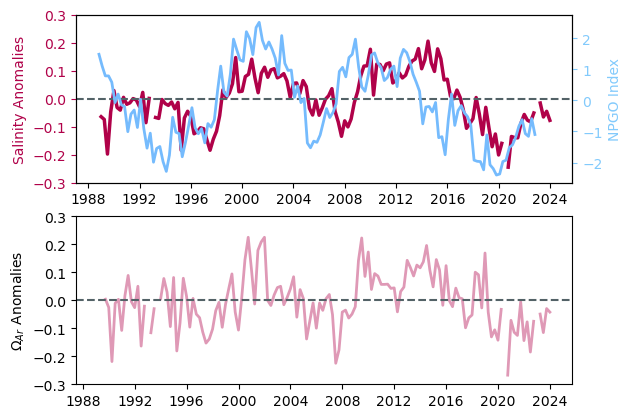

In [204]:
# Figure 6

fig, axs = plt.subplots(2)
axs[0].plot(nptw_anom.resample('3ME').mean().index, nptw_anom.resample('3ME').mean()['csal'], linewidth=2.5, color='xkcd:raspberry')
axs[0].set_ylim(-0.3,0.3)
#axs[0].spines['left'].set_color('xkcd:raspberry')
axs[0].tick_params(axis='y', colors='xkcd:raspberry')
axs[0].set_ylabel('Salinity Anomalies', color='xkcd:raspberry')

ax2 = axs[0].twinx()
ax2.plot(npgo_re.resample('3ME').mean().index, npgo_re.resample('3ME').mean()['npgo'], linewidth=2, color='xkcd:sky blue')

#ax2.spines['right'].set_color('xkcd:sky')
ax2.tick_params(axis='y', colors='xkcd:sky')
ax2.set_ylabel('NPGO Index', color='xkcd:sky')

axs[0].axhline(0, linestyle='--', color='xkcd:gunmetal')

axs[1].plot(nptw_anom.resample('3ME').mean().index, nptw_anom.resample('3ME').mean()['OmegaARin'], linewidth=2, color='xkcd:raspberry', alpha=0.4)
axs[1].set_ylim(-0.3,0.3)
axs[1].axhline(0, linestyle='--', color='xkcd:gunmetal')
axs[1].set_ylabel('Ω$_A$$_r$ Anomalies')
plt.savefig('LK_Fig6.png',dpi=300)